In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.preprocessing import sequence
import scipy.fftpack as spf
from peakfinder import detect_peaks
from matplotlib import style
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support

style.use('ggplot')
#%matplotlib inline
#%matplotlib qt
#%matplotlib notebook

Using TensorFlow backend.


In [2]:
df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\new labels1.txt',delimiter = '\s+',header = None,index_col = None)
#df_labels = pd.read_csv(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Scripts\modified_labels.txt',delimiter = '\s+',header = None,index_col = None)
df_labels.columns = ['File','Label']
len(df_labels['File'])

375

In [3]:
z = []
y = []

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

f_wav = 250

rootDir = r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations'
#rootDir = r'/Users/kunal/OneDrive - The Open University/SPIN/data/level_1p0_data/New occultations'
os.chdir(rootDir)
list_of_files = os.listdir(os.getcwd())

for each_file in list_of_files:
    for each_df_file in df_labels['File']:
        if each_file.startswith(each_df_file):
            
            file = h5py.File(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\data\level_1p0_data\New occultations\%s' %each_file,'r')
            #file = h5py.File(r'/Users/kunal/OneDrive - The Open University/SPIN/data/level_1p0_data/New occultations/%s' %each_file,'r')

            
            T = np.array(file['Science/Transmission'])
            TangAlt = np.array(file['Geometry/Point0/TangentAltSurface'])
            wav = np.array(file['Science/Wavelength'])

            avg_TangAlt = []

            for j in range(TangAlt.shape[0]):
                avg_TangAlt.append(np.mean(TangAlt[j,:]))



            T_wav = T[:,np.array(np.where(wav == find_nearest(wav,f_wav))).flatten()].reshape(-1,)

            if T_wav[0] > 0.5:
                T_wav = T_wav[::-1]

            z.append(T_wav)
            
            if avg_TangAlt[0] > 100:
                avg_TangAlt = avg_TangAlt[::-1]
            
            y.append(avg_TangAlt)

In [4]:
z = np.array(z)
y = np.array(y)
len_sequences = []
for one_seq in z:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    375.000000
mean     143.578667
std       77.556283
min       63.000000
25%       84.000000
50%      118.000000
75%      184.500000
max      514.000000
dtype: float64

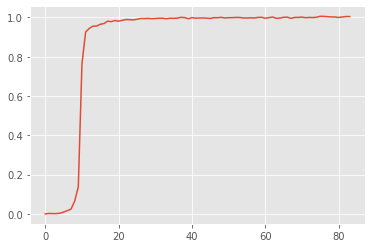

In [5]:
plt.plot(z[17])

In [6]:
af = []
for _ in y:
    af.append(max(_))
max(af)

273.02042100939343

In [7]:
alt_interp = np.arange(0,274,1)

In [8]:
t_interp = []
for i in range(len(z)):
    z_interp = np.interp(alt_interp,y[i],z[i])
    t_interp.append(z_interp)
t_interp = np.array(t_interp)

In [9]:
len_sequences = []
for one_seq in t_interp:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    375.0
mean     274.0
std        0.0
min      274.0
25%      274.0
50%      274.0
75%      274.0
max      274.0
dtype: float64

In [10]:
dist,path = fastdtw(t_interp[5],t_interp[82])
dist

0.7974739637121454

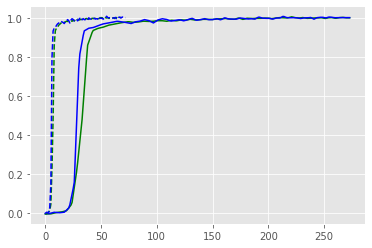

In [11]:
plt.plot(t_interp[5],'g')
plt.plot(t_interp[82],'b')
plt.plot(z[5],'g--')
plt.plot(z[82],'b--')

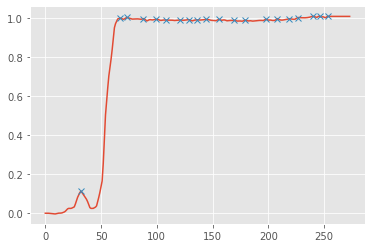

In [12]:
i = 27
plt.plot(t_interp[i])
peak_idx = detect_peaks(t_interp[i],mph=0.1,mpd=5) 
plt.plot(peak_idx,t_interp[i,peak_idx],'x')

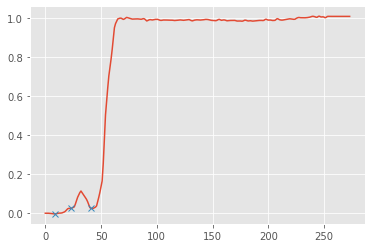

In [13]:
plt.plot(t_interp[i])
peak_idx = detect_peaks(t_interp[i],valley = True,mph=0.1,mpd=5) 
plt.plot(peak_idx,t_interp[i,peak_idx],'x')

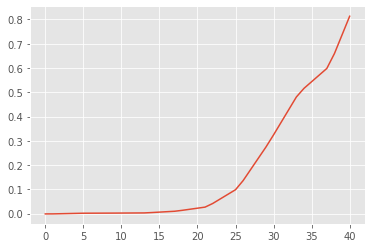

In [14]:
clip = np.array([])
for _ in t_interp[13,peak_idx]:
        clip = np.append(clip,_)
        if _ > 0.9:
            break

plt.plot(t_interp[13,:np.where(t_interp[13] == clip[-1])[0][0]])


In [15]:
t_clipped = []
for i,t in enumerate(t_interp):
    clip = np.array([])
    peak_idx = detect_peaks(t) 
    for _ in t[peak_idx]:
        clip = np.append(clip,_)
        if _ > 0.98:
            break
    t_clipped.append(t[:np.where(t == clip[-1])[0][0]])
t_clipped = np.array(t_clipped)

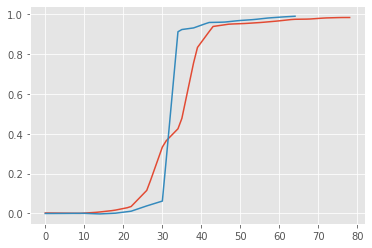

In [16]:
plt.plot(alt_interp[:len(t_clipped[9])],t_clipped[9])
plt.plot(alt_interp[:len(t_clipped[10])],t_clipped[10])

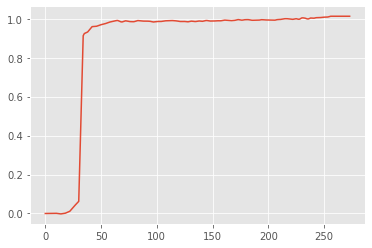

In [17]:
plt.plot(t_interp[10])

"plt.plot(t_interp[15])\npeak_idx = pf.detect_peaks(t_interp[15]) \nplt.plot(peak_idx,t_interp[15,peak_idx],'x')"

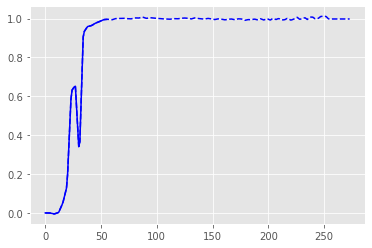

In [18]:
plt.plot(t_clipped[15],'b')
plt.plot(t_interp[15],'b--')
'''plt.plot(t_interp[15])
peak_idx = pf.detect_peaks(t_interp[15]) 
plt.plot(peak_idx,t_interp[15,peak_idx],'x')'''

In [19]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i][::self.subsample_step],
                                                      y[j][ ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i][::self.subsample_step],
                                                  y[j][::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
            #print(dm)
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        #print(x)
        #print(self.x)
        dm = self._dist_matrix(x, self.x)
        

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print (self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [21]:
indices = np.arange(len(np.array(df_labels['Label'])))
#X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_interp, np.array(df_labels['Label']),indices, test_size=0.33)

X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_clipped, np.array(df_labels['Label']),indices, test_size=0.33)
#X_train, X_test, y_train, y_test,id_train,id_test = train_test_split(t_fft, np.array(df_labels['Label']),indices, test_size=0.33)

In [28]:
m = KnnDtw(n_neighbors=5,max_warping_window=10)
m.fit(X_train,y_train)
label, prob = m.predict(X_test)

[                  0%                  ]
[                  0%                  ]  2 of 31124 complete
[                  0%                  ]  3 of 31124 complete
[                  0%                  ]  4 of 31124 complete
[                  0%                  ]  5 of 31124 complete
[                  0%                  ]  6 of 31124 complete
[                  0%                  ]  7 of 31124 complete
[                  0%                  ]  8 of 31124 complete
[                  0%                  ]  9 of 31124 complete
[                  0%                  ]  10 of 31124 complete
[                  0%                  ]  11 of 31124 complete
[                  0%                  ]  12 of 31124 complete
[                  0%                  ]  13 of 31124 complete
[                  0%                  ]  14 of 31124 complete
[                  0%                  ]  15 of 31124 complete
[                  0%                  ]  16 of 31124 complete
[                  0% 

[                  0%                  ]  132 of 31124 complete
[                  0%                  ]  133 of 31124 complete
[                  0%                  ]  134 of 31124 complete
[                  0%                  ]  135 of 31124 complete
[                  0%                  ]  136 of 31124 complete
[                  0%                  ]  137 of 31124 complete
[                  0%                  ]  138 of 31124 complete
[                  0%                  ]  139 of 31124 complete
[                  0%                  ]  140 of 31124 complete
[                  0%                  ]  141 of 31124 complete
[                  0%                  ]  142 of 31124 complete
[                  0%                  ]  143 of 31124 complete
[                  0%                  ]  144 of 31124 complete
[                  0%                  ]  145 of 31124 complete
[                  0%                  ]  146 of 31124 complete
[                  0%                  ]

[                  1%                  ]  261 of 31124 complete
[                  1%                  ]  262 of 31124 complete
[                  1%                  ]  263 of 31124 complete
[                  1%                  ]  264 of 31124 complete
[                  1%                  ]  265 of 31124 complete
[                  1%                  ]  266 of 31124 complete
[                  1%                  ]  267 of 31124 complete
[                  1%                  ]  268 of 31124 complete
[                  1%                  ]  269 of 31124 complete
[                  1%                  ]  270 of 31124 complete
[                  1%                  ]  271 of 31124 complete
[                  1%                  ]  272 of 31124 complete
[                  1%                  ]  273 of 31124 complete
[                  1%                  ]  274 of 31124 complete
[                  1%                  ]  275 of 31124 complete
[                  1%                  ]

[                  1%                  ]  390 of 31124 complete
[                  1%                  ]  391 of 31124 complete
[                  1%                  ]  392 of 31124 complete
[                  1%                  ]  393 of 31124 complete
[                  1%                  ]  394 of 31124 complete
[                  1%                  ]  395 of 31124 complete
[                  1%                  ]  396 of 31124 complete
[                  1%                  ]  397 of 31124 complete
[                  1%                  ]  398 of 31124 complete
[                  1%                  ]  399 of 31124 complete
[                  1%                  ]  400 of 31124 complete
[                  1%                  ]  401 of 31124 complete
[                  1%                  ]  402 of 31124 complete
[                  1%                  ]  403 of 31124 complete
[                  1%                  ]  404 of 31124 complete
[                  1%                  ]

[*                 2%                  ]  519 of 31124 complete
[*                 2%                  ]  520 of 31124 complete
[*                 2%                  ]  521 of 31124 complete
[*                 2%                  ]  522 of 31124 complete
[*                 2%                  ]  523 of 31124 complete
[*                 2%                  ]  524 of 31124 complete
[*                 2%                  ]  525 of 31124 complete
[*                 2%                  ]  526 of 31124 complete
[*                 2%                  ]  527 of 31124 complete
[*                 2%                  ]  528 of 31124 complete
[*                 2%                  ]  529 of 31124 complete
[*                 2%                  ]  530 of 31124 complete
[*                 2%                  ]  531 of 31124 complete
[*                 2%                  ]  532 of 31124 complete
[*                 2%                  ]  533 of 31124 complete
[*                 2%                  ]

[*                 2%                  ]  648 of 31124 complete
[*                 2%                  ]  649 of 31124 complete
[*                 2%                  ]  650 of 31124 complete
[*                 2%                  ]  651 of 31124 complete
[*                 2%                  ]  652 of 31124 complete
[*                 2%                  ]  653 of 31124 complete
[*                 2%                  ]  654 of 31124 complete
[*                 2%                  ]  655 of 31124 complete
[*                 2%                  ]  656 of 31124 complete
[*                 2%                  ]  657 of 31124 complete
[*                 2%                  ]  658 of 31124 complete
[*                 2%                  ]  659 of 31124 complete
[*                 2%                  ]  660 of 31124 complete
[*                 2%                  ]  661 of 31124 complete
[*                 2%                  ]  662 of 31124 complete
[*                 2%                  ]

[*                 2%                  ]  777 of 31124 complete
[*                 2%                  ]  778 of 31124 complete
[*                 3%                  ]  779 of 31124 complete
[*                 3%                  ]  780 of 31124 complete
[*                 3%                  ]  781 of 31124 complete
[*                 3%                  ]  782 of 31124 complete
[*                 3%                  ]  783 of 31124 complete
[*                 3%                  ]  784 of 31124 complete
[*                 3%                  ]  785 of 31124 complete
[*                 3%                  ]  786 of 31124 complete
[*                 3%                  ]  787 of 31124 complete
[*                 3%                  ]  788 of 31124 complete
[*                 3%                  ]  789 of 31124 complete
[*                 3%                  ]  790 of 31124 complete
[*                 3%                  ]  791 of 31124 complete
[*                 3%                  ]

[*                 3%                  ]  906 of 31124 complete
[*                 3%                  ]  907 of 31124 complete
[*                 3%                  ]  908 of 31124 complete
[*                 3%                  ]  909 of 31124 complete
[*                 3%                  ]  910 of 31124 complete
[*                 3%                  ]  911 of 31124 complete
[*                 3%                  ]  912 of 31124 complete
[*                 3%                  ]  913 of 31124 complete
[*                 3%                  ]  914 of 31124 complete
[*                 3%                  ]  915 of 31124 complete
[*                 3%                  ]  916 of 31124 complete
[*                 3%                  ]  917 of 31124 complete
[*                 3%                  ]  918 of 31124 complete
[*                 3%                  ]  919 of 31124 complete
[*                 3%                  ]  920 of 31124 complete
[*                 3%                  ]

[*                 3%                  ]  1034 of 31124 complete
[*                 3%                  ]  1035 of 31124 complete
[*                 3%                  ]  1036 of 31124 complete
[*                 3%                  ]  1037 of 31124 complete
[*                 3%                  ]  1038 of 31124 complete
[*                 3%                  ]  1039 of 31124 complete
[*                 3%                  ]  1040 of 31124 complete
[*                 3%                  ]  1041 of 31124 complete
[*                 3%                  ]  1042 of 31124 complete
[*                 3%                  ]  1043 of 31124 complete
[*                 3%                  ]  1044 of 31124 complete
[*                 3%                  ]  1045 of 31124 complete
[*                 3%                  ]  1046 of 31124 complete
[*                 3%                  ]  1047 of 31124 complete
[*                 3%                  ]  1048 of 31124 complete
[*                 3%    

[**                4%                  ]  1161 of 31124 complete
[**                4%                  ]  1162 of 31124 complete
[**                4%                  ]  1163 of 31124 complete
[**                4%                  ]  1164 of 31124 complete
[**                4%                  ]  1165 of 31124 complete
[**                4%                  ]  1166 of 31124 complete
[**                4%                  ]  1167 of 31124 complete
[**                4%                  ]  1168 of 31124 complete
[**                4%                  ]  1169 of 31124 complete
[**                4%                  ]  1170 of 31124 complete
[**                4%                  ]  1171 of 31124 complete
[**                4%                  ]  1172 of 31124 complete
[**                4%                  ]  1173 of 31124 complete
[**                4%                  ]  1174 of 31124 complete
[**                4%                  ]  1175 of 31124 complete
[**                4%    

[**                4%                  ]  1288 of 31124 complete
[**                4%                  ]  1289 of 31124 complete
[**                4%                  ]  1290 of 31124 complete
[**                4%                  ]  1291 of 31124 complete
[**                4%                  ]  1292 of 31124 complete
[**                4%                  ]  1293 of 31124 complete
[**                4%                  ]  1294 of 31124 complete
[**                4%                  ]  1295 of 31124 complete
[**                4%                  ]  1296 of 31124 complete
[**                4%                  ]  1297 of 31124 complete
[**                4%                  ]  1298 of 31124 complete
[**                4%                  ]  1299 of 31124 complete
[**                4%                  ]  1300 of 31124 complete
[**                4%                  ]  1301 of 31124 complete
[**                4%                  ]  1302 of 31124 complete
[**                4%    

[**                5%                  ]  1415 of 31124 complete
[**                5%                  ]  1416 of 31124 complete
[**                5%                  ]  1417 of 31124 complete
[**                5%                  ]  1418 of 31124 complete
[**                5%                  ]  1419 of 31124 complete
[**                5%                  ]  1420 of 31124 complete
[**                5%                  ]  1421 of 31124 complete
[**                5%                  ]  1422 of 31124 complete
[**                5%                  ]  1423 of 31124 complete
[**                5%                  ]  1424 of 31124 complete
[**                5%                  ]  1425 of 31124 complete
[**                5%                  ]  1426 of 31124 complete
[**                5%                  ]  1427 of 31124 complete
[**                5%                  ]  1428 of 31124 complete
[**                5%                  ]  1429 of 31124 complete
[**                5%    

[**                5%                  ]  1542 of 31124 complete
[**                5%                  ]  1543 of 31124 complete
[**                5%                  ]  1544 of 31124 complete
[**                5%                  ]  1545 of 31124 complete
[**                5%                  ]  1546 of 31124 complete
[**                5%                  ]  1547 of 31124 complete
[**                5%                  ]  1548 of 31124 complete
[**                5%                  ]  1549 of 31124 complete
[**                5%                  ]  1550 of 31124 complete
[**                5%                  ]  1551 of 31124 complete
[**                5%                  ]  1552 of 31124 complete
[**                5%                  ]  1553 of 31124 complete
[**                5%                  ]  1554 of 31124 complete
[**                5%                  ]  1555 of 31124 complete
[**                5%                  ]  1556 of 31124 complete
[**                5%    

[**                5%                  ]  1669 of 31124 complete
[**                5%                  ]  1670 of 31124 complete
[**                5%                  ]  1671 of 31124 complete
[**                5%                  ]  1672 of 31124 complete
[**                5%                  ]  1673 of 31124 complete
[**                5%                  ]  1674 of 31124 complete
[**                5%                  ]  1675 of 31124 complete
[**                5%                  ]  1676 of 31124 complete
[**                5%                  ]  1677 of 31124 complete
[**                5%                  ]  1678 of 31124 complete
[**                5%                  ]  1679 of 31124 complete
[**                5%                  ]  1680 of 31124 complete
[**                5%                  ]  1681 of 31124 complete
[**                5%                  ]  1682 of 31124 complete
[**                5%                  ]  1683 of 31124 complete
[**                5%    

[**                6%                  ]  1796 of 31124 complete
[**                6%                  ]  1797 of 31124 complete
[**                6%                  ]  1798 of 31124 complete
[**                6%                  ]  1799 of 31124 complete
[**                6%                  ]  1800 of 31124 complete
[**                6%                  ]  1801 of 31124 complete
[**                6%                  ]  1802 of 31124 complete
[**                6%                  ]  1803 of 31124 complete
[**                6%                  ]  1804 of 31124 complete
[**                6%                  ]  1805 of 31124 complete
[**                6%                  ]  1806 of 31124 complete
[**                6%                  ]  1807 of 31124 complete
[**                6%                  ]  1808 of 31124 complete
[**                6%                  ]  1809 of 31124 complete
[**                6%                  ]  1810 of 31124 complete
[**                6%    

[**                6%                  ]  1923 of 31124 complete
[**                6%                  ]  1924 of 31124 complete
[**                6%                  ]  1925 of 31124 complete
[**                6%                  ]  1926 of 31124 complete
[**                6%                  ]  1927 of 31124 complete
[**                6%                  ]  1928 of 31124 complete
[**                6%                  ]  1929 of 31124 complete
[**                6%                  ]  1930 of 31124 complete
[**                6%                  ]  1931 of 31124 complete
[**                6%                  ]  1932 of 31124 complete
[**                6%                  ]  1933 of 31124 complete
[**                6%                  ]  1934 of 31124 complete
[**                6%                  ]  1935 of 31124 complete
[**                6%                  ]  1936 of 31124 complete
[**                6%                  ]  1937 of 31124 complete
[**                6%    

[***               7%                  ]  2049 of 31124 complete
[***               7%                  ]  2050 of 31124 complete
[***               7%                  ]  2051 of 31124 complete
[***               7%                  ]  2052 of 31124 complete
[***               7%                  ]  2053 of 31124 complete
[***               7%                  ]  2054 of 31124 complete
[***               7%                  ]  2055 of 31124 complete
[***               7%                  ]  2056 of 31124 complete
[***               7%                  ]  2057 of 31124 complete
[***               7%                  ]  2058 of 31124 complete
[***               7%                  ]  2059 of 31124 complete
[***               7%                  ]  2060 of 31124 complete
[***               7%                  ]  2061 of 31124 complete
[***               7%                  ]  2062 of 31124 complete
[***               7%                  ]  2063 of 31124 complete
[***               7%    

[***               7%                  ]  2176 of 31124 complete
[***               7%                  ]  2177 of 31124 complete
[***               7%                  ]  2178 of 31124 complete
[***               7%                  ]  2179 of 31124 complete
[***               7%                  ]  2180 of 31124 complete
[***               7%                  ]  2181 of 31124 complete
[***               7%                  ]  2182 of 31124 complete
[***               7%                  ]  2183 of 31124 complete
[***               7%                  ]  2184 of 31124 complete
[***               7%                  ]  2185 of 31124 complete
[***               7%                  ]  2186 of 31124 complete
[***               7%                  ]  2187 of 31124 complete
[***               7%                  ]  2188 of 31124 complete
[***               7%                  ]  2189 of 31124 complete
[***               7%                  ]  2190 of 31124 complete
[***               7%    

[***               7%                  ]  2303 of 31124 complete
[***               7%                  ]  2304 of 31124 complete
[***               7%                  ]  2305 of 31124 complete
[***               7%                  ]  2306 of 31124 complete
[***               7%                  ]  2307 of 31124 complete
[***               7%                  ]  2308 of 31124 complete
[***               7%                  ]  2309 of 31124 complete
[***               7%                  ]  2310 of 31124 complete
[***               7%                  ]  2311 of 31124 complete
[***               7%                  ]  2312 of 31124 complete
[***               7%                  ]  2313 of 31124 complete
[***               7%                  ]  2314 of 31124 complete
[***               7%                  ]  2315 of 31124 complete
[***               7%                  ]  2316 of 31124 complete
[***               7%                  ]  2317 of 31124 complete
[***               7%    

[***               8%                  ]  2430 of 31124 complete
[***               8%                  ]  2431 of 31124 complete
[***               8%                  ]  2432 of 31124 complete
[***               8%                  ]  2433 of 31124 complete
[***               8%                  ]  2434 of 31124 complete
[***               8%                  ]  2435 of 31124 complete
[***               8%                  ]  2436 of 31124 complete
[***               8%                  ]  2437 of 31124 complete
[***               8%                  ]  2438 of 31124 complete
[***               8%                  ]  2439 of 31124 complete
[***               8%                  ]  2440 of 31124 complete
[***               8%                  ]  2441 of 31124 complete
[***               8%                  ]  2442 of 31124 complete
[***               8%                  ]  2443 of 31124 complete
[***               8%                  ]  2444 of 31124 complete
[***               8%    

[***               8%                  ]  2557 of 31124 complete
[***               8%                  ]  2558 of 31124 complete
[***               8%                  ]  2559 of 31124 complete
[***               8%                  ]  2560 of 31124 complete
[***               8%                  ]  2561 of 31124 complete
[***               8%                  ]  2562 of 31124 complete
[***               8%                  ]  2563 of 31124 complete
[***               8%                  ]  2564 of 31124 complete
[***               8%                  ]  2565 of 31124 complete
[***               8%                  ]  2566 of 31124 complete
[***               8%                  ]  2567 of 31124 complete
[***               8%                  ]  2568 of 31124 complete
[***               8%                  ]  2569 of 31124 complete
[***               8%                  ]  2570 of 31124 complete
[***               8%                  ]  2571 of 31124 complete
[***               8%    

[***               9%                  ]  2684 of 31124 complete
[***               9%                  ]  2685 of 31124 complete
[***               9%                  ]  2686 of 31124 complete
[***               9%                  ]  2687 of 31124 complete
[***               9%                  ]  2688 of 31124 complete
[***               9%                  ]  2689 of 31124 complete
[***               9%                  ]  2690 of 31124 complete
[***               9%                  ]  2691 of 31124 complete
[***               9%                  ]  2692 of 31124 complete
[***               9%                  ]  2693 of 31124 complete
[***               9%                  ]  2694 of 31124 complete
[***               9%                  ]  2695 of 31124 complete
[***               9%                  ]  2696 of 31124 complete
[***               9%                  ]  2697 of 31124 complete
[***               9%                  ]  2698 of 31124 complete
[***               9%    

[***               9%                  ]  2811 of 31124 complete
[***               9%                  ]  2812 of 31124 complete
[***               9%                  ]  2813 of 31124 complete
[***               9%                  ]  2814 of 31124 complete
[***               9%                  ]  2815 of 31124 complete
[***               9%                  ]  2816 of 31124 complete
[***               9%                  ]  2817 of 31124 complete
[***               9%                  ]  2818 of 31124 complete
[***               9%                  ]  2819 of 31124 complete
[***               9%                  ]  2820 of 31124 complete
[***               9%                  ]  2821 of 31124 complete
[***               9%                  ]  2822 of 31124 complete
[***               9%                  ]  2823 of 31124 complete
[***               9%                  ]  2824 of 31124 complete
[***               9%                  ]  2825 of 31124 complete
[***               9%    

[***               9%                  ]  2938 of 31124 complete
[***               9%                  ]  2939 of 31124 complete
[***               9%                  ]  2940 of 31124 complete
[***               9%                  ]  2941 of 31124 complete
[***               9%                  ]  2942 of 31124 complete
[***               9%                  ]  2943 of 31124 complete
[***               9%                  ]  2944 of 31124 complete
[***               9%                  ]  2945 of 31124 complete
[***               9%                  ]  2946 of 31124 complete
[***               9%                  ]  2947 of 31124 complete
[***               9%                  ]  2948 of 31124 complete
[***               9%                  ]  2949 of 31124 complete
[***               9%                  ]  2950 of 31124 complete
[***               9%                  ]  2951 of 31124 complete
[***               9%                  ]  2952 of 31124 complete
[***               9%    

[****             10%                  ]  3064 of 31124 complete
[****             10%                  ]  3065 of 31124 complete
[****             10%                  ]  3066 of 31124 complete
[****             10%                  ]  3067 of 31124 complete
[****             10%                  ]  3068 of 31124 complete
[****             10%                  ]  3069 of 31124 complete
[****             10%                  ]  3070 of 31124 complete
[****             10%                  ]  3071 of 31124 complete
[****             10%                  ]  3072 of 31124 complete
[****             10%                  ]  3073 of 31124 complete
[****             10%                  ]  3074 of 31124 complete
[****             10%                  ]  3075 of 31124 complete
[****             10%                  ]  3076 of 31124 complete
[****             10%                  ]  3077 of 31124 complete
[****             10%                  ]  3078 of 31124 complete
[****             10%    

[****             10%                  ]  3190 of 31124 complete
[****             10%                  ]  3191 of 31124 complete
[****             10%                  ]  3192 of 31124 complete
[****             10%                  ]  3193 of 31124 complete
[****             10%                  ]  3194 of 31124 complete
[****             10%                  ]  3195 of 31124 complete
[****             10%                  ]  3196 of 31124 complete
[****             10%                  ]  3197 of 31124 complete
[****             10%                  ]  3198 of 31124 complete
[****             10%                  ]  3199 of 31124 complete
[****             10%                  ]  3200 of 31124 complete
[****             10%                  ]  3201 of 31124 complete
[****             10%                  ]  3202 of 31124 complete
[****             10%                  ]  3203 of 31124 complete
[****             10%                  ]  3204 of 31124 complete
[****             10%    

[****             11%                  ]  3317 of 31124 complete
[****             11%                  ]  3318 of 31124 complete
[****             11%                  ]  3319 of 31124 complete
[****             11%                  ]  3320 of 31124 complete
[****             11%                  ]  3321 of 31124 complete
[****             11%                  ]  3322 of 31124 complete
[****             11%                  ]  3323 of 31124 complete
[****             11%                  ]  3324 of 31124 complete
[****             11%                  ]  3325 of 31124 complete
[****             11%                  ]  3326 of 31124 complete
[****             11%                  ]  3327 of 31124 complete
[****             11%                  ]  3328 of 31124 complete
[****             11%                  ]  3329 of 31124 complete
[****             11%                  ]  3330 of 31124 complete
[****             11%                  ]  3331 of 31124 complete
[****             11%    

[****             11%                  ]  3444 of 31124 complete
[****             11%                  ]  3445 of 31124 complete
[****             11%                  ]  3446 of 31124 complete
[****             11%                  ]  3447 of 31124 complete
[****             11%                  ]  3448 of 31124 complete
[****             11%                  ]  3449 of 31124 complete
[****             11%                  ]  3450 of 31124 complete
[****             11%                  ]  3451 of 31124 complete
[****             11%                  ]  3452 of 31124 complete
[****             11%                  ]  3453 of 31124 complete
[****             11%                  ]  3454 of 31124 complete
[****             11%                  ]  3455 of 31124 complete
[****             11%                  ]  3456 of 31124 complete
[****             11%                  ]  3457 of 31124 complete
[****             11%                  ]  3458 of 31124 complete
[****             11%    

[****             11%                  ]  3571 of 31124 complete
[****             11%                  ]  3572 of 31124 complete
[****             11%                  ]  3573 of 31124 complete
[****             11%                  ]  3574 of 31124 complete
[****             11%                  ]  3575 of 31124 complete
[****             11%                  ]  3576 of 31124 complete
[****             11%                  ]  3577 of 31124 complete
[****             11%                  ]  3578 of 31124 complete
[****             11%                  ]  3579 of 31124 complete
[*****            12%                  ]  3580 of 31124 complete
[*****            12%                  ]  3581 of 31124 complete
[*****            12%                  ]  3582 of 31124 complete
[*****            12%                  ]  3583 of 31124 complete
[*****            12%                  ]  3584 of 31124 complete
[*****            12%                  ]  3585 of 31124 complete
[*****            12%    

[*****            12%                  ]  3698 of 31124 complete
[*****            12%                  ]  3699 of 31124 complete
[*****            12%                  ]  3700 of 31124 complete
[*****            12%                  ]  3701 of 31124 complete
[*****            12%                  ]  3702 of 31124 complete
[*****            12%                  ]  3703 of 31124 complete
[*****            12%                  ]  3704 of 31124 complete
[*****            12%                  ]  3705 of 31124 complete
[*****            12%                  ]  3706 of 31124 complete
[*****            12%                  ]  3707 of 31124 complete
[*****            12%                  ]  3708 of 31124 complete
[*****            12%                  ]  3709 of 31124 complete
[*****            12%                  ]  3710 of 31124 complete
[*****            12%                  ]  3711 of 31124 complete
[*****            12%                  ]  3712 of 31124 complete
[*****            12%    

[*****            12%                  ]  3824 of 31124 complete
[*****            12%                  ]  3825 of 31124 complete
[*****            12%                  ]  3826 of 31124 complete
[*****            12%                  ]  3827 of 31124 complete
[*****            12%                  ]  3828 of 31124 complete
[*****            12%                  ]  3829 of 31124 complete
[*****            12%                  ]  3830 of 31124 complete
[*****            12%                  ]  3831 of 31124 complete
[*****            12%                  ]  3832 of 31124 complete
[*****            12%                  ]  3833 of 31124 complete
[*****            12%                  ]  3834 of 31124 complete
[*****            12%                  ]  3835 of 31124 complete
[*****            12%                  ]  3836 of 31124 complete
[*****            12%                  ]  3837 of 31124 complete
[*****            12%                  ]  3838 of 31124 complete
[*****            12%    

[*****            13%                  ]  3951 of 31124 complete
[*****            13%                  ]  3952 of 31124 complete
[*****            13%                  ]  3953 of 31124 complete
[*****            13%                  ]  3954 of 31124 complete
[*****            13%                  ]  3955 of 31124 complete
[*****            13%                  ]  3956 of 31124 complete
[*****            13%                  ]  3957 of 31124 complete
[*****            13%                  ]  3958 of 31124 complete
[*****            13%                  ]  3959 of 31124 complete
[*****            13%                  ]  3960 of 31124 complete
[*****            13%                  ]  3961 of 31124 complete
[*****            13%                  ]  3962 of 31124 complete
[*****            13%                  ]  3963 of 31124 complete
[*****            13%                  ]  3964 of 31124 complete
[*****            13%                  ]  3965 of 31124 complete
[*****            13%    

[*****            13%                  ]  4078 of 31124 complete
[*****            13%                  ]  4079 of 31124 complete
[*****            13%                  ]  4080 of 31124 complete
[*****            13%                  ]  4081 of 31124 complete
[*****            13%                  ]  4082 of 31124 complete
[*****            13%                  ]  4083 of 31124 complete
[*****            13%                  ]  4084 of 31124 complete
[*****            13%                  ]  4085 of 31124 complete
[*****            13%                  ]  4086 of 31124 complete
[*****            13%                  ]  4087 of 31124 complete
[*****            13%                  ]  4088 of 31124 complete
[*****            13%                  ]  4089 of 31124 complete
[*****            13%                  ]  4090 of 31124 complete
[*****            13%                  ]  4091 of 31124 complete
[*****            13%                  ]  4092 of 31124 complete
[*****            13%    

[*****            14%                  ]  4204 of 31124 complete
[*****            14%                  ]  4205 of 31124 complete
[*****            14%                  ]  4206 of 31124 complete
[*****            14%                  ]  4207 of 31124 complete
[*****            14%                  ]  4208 of 31124 complete
[*****            14%                  ]  4209 of 31124 complete
[*****            14%                  ]  4210 of 31124 complete
[*****            14%                  ]  4211 of 31124 complete
[*****            14%                  ]  4212 of 31124 complete
[*****            14%                  ]  4213 of 31124 complete
[*****            14%                  ]  4214 of 31124 complete
[*****            14%                  ]  4215 of 31124 complete
[*****            14%                  ]  4216 of 31124 complete
[*****            14%                  ]  4217 of 31124 complete
[*****            14%                  ]  4218 of 31124 complete
[*****            14%    

[*****            14%                  ]  4331 of 31124 complete
[*****            14%                  ]  4332 of 31124 complete
[*****            14%                  ]  4333 of 31124 complete
[*****            14%                  ]  4334 of 31124 complete
[*****            14%                  ]  4335 of 31124 complete
[*****            14%                  ]  4336 of 31124 complete
[*****            14%                  ]  4337 of 31124 complete
[*****            14%                  ]  4338 of 31124 complete
[*****            14%                  ]  4339 of 31124 complete
[*****            14%                  ]  4340 of 31124 complete
[*****            14%                  ]  4341 of 31124 complete
[*****            14%                  ]  4342 of 31124 complete
[*****            14%                  ]  4343 of 31124 complete
[*****            14%                  ]  4344 of 31124 complete
[*****            14%                  ]  4345 of 31124 complete
[*****            14%    

[*****            14%                  ]  4458 of 31124 complete
[*****            14%                  ]  4459 of 31124 complete
[*****            14%                  ]  4460 of 31124 complete
[*****            14%                  ]  4461 of 31124 complete
[*****            14%                  ]  4462 of 31124 complete
[*****            14%                  ]  4463 of 31124 complete
[*****            14%                  ]  4464 of 31124 complete
[*****            14%                  ]  4465 of 31124 complete
[*****            14%                  ]  4466 of 31124 complete
[*****            14%                  ]  4467 of 31124 complete
[*****            14%                  ]  4468 of 31124 complete
[*****            14%                  ]  4469 of 31124 complete
[*****            14%                  ]  4470 of 31124 complete
[*****            14%                  ]  4471 of 31124 complete
[*****            14%                  ]  4472 of 31124 complete
[*****            14%    

[******           15%                  ]  4585 of 31124 complete
[******           15%                  ]  4586 of 31124 complete
[******           15%                  ]  4587 of 31124 complete
[******           15%                  ]  4588 of 31124 complete
[******           15%                  ]  4589 of 31124 complete
[******           15%                  ]  4590 of 31124 complete
[******           15%                  ]  4591 of 31124 complete
[******           15%                  ]  4592 of 31124 complete
[******           15%                  ]  4593 of 31124 complete
[******           15%                  ]  4594 of 31124 complete
[******           15%                  ]  4595 of 31124 complete
[******           15%                  ]  4596 of 31124 complete
[******           15%                  ]  4597 of 31124 complete
[******           15%                  ]  4598 of 31124 complete
[******           15%                  ]  4599 of 31124 complete
[******           15%    

[******           15%                  ]  4711 of 31124 complete
[******           15%                  ]  4712 of 31124 complete
[******           15%                  ]  4713 of 31124 complete
[******           15%                  ]  4714 of 31124 complete
[******           15%                  ]  4715 of 31124 complete
[******           15%                  ]  4716 of 31124 complete
[******           15%                  ]  4717 of 31124 complete
[******           15%                  ]  4718 of 31124 complete
[******           15%                  ]  4719 of 31124 complete
[******           15%                  ]  4720 of 31124 complete
[******           15%                  ]  4721 of 31124 complete
[******           15%                  ]  4722 of 31124 complete
[******           15%                  ]  4723 of 31124 complete
[******           15%                  ]  4724 of 31124 complete
[******           15%                  ]  4725 of 31124 complete
[******           15%    

[******           16%                  ]  4838 of 31124 complete
[******           16%                  ]  4839 of 31124 complete
[******           16%                  ]  4840 of 31124 complete
[******           16%                  ]  4841 of 31124 complete
[******           16%                  ]  4842 of 31124 complete
[******           16%                  ]  4843 of 31124 complete
[******           16%                  ]  4844 of 31124 complete
[******           16%                  ]  4845 of 31124 complete
[******           16%                  ]  4846 of 31124 complete
[******           16%                  ]  4847 of 31124 complete
[******           16%                  ]  4848 of 31124 complete
[******           16%                  ]  4849 of 31124 complete
[******           16%                  ]  4850 of 31124 complete
[******           16%                  ]  4851 of 31124 complete
[******           16%                  ]  4852 of 31124 complete
[******           16%    

[******           16%                  ]  4965 of 31124 complete
[******           16%                  ]  4966 of 31124 complete
[******           16%                  ]  4967 of 31124 complete
[******           16%                  ]  4968 of 31124 complete
[******           16%                  ]  4969 of 31124 complete
[******           16%                  ]  4970 of 31124 complete
[******           16%                  ]  4971 of 31124 complete
[******           16%                  ]  4972 of 31124 complete
[******           16%                  ]  4973 of 31124 complete
[******           16%                  ]  4974 of 31124 complete
[******           16%                  ]  4975 of 31124 complete
[******           16%                  ]  4976 of 31124 complete
[******           16%                  ]  4977 of 31124 complete
[******           16%                  ]  4978 of 31124 complete
[******           16%                  ]  4979 of 31124 complete
[******           16%    

[******           16%                  ]  5092 of 31124 complete
[******           16%                  ]  5093 of 31124 complete
[******           16%                  ]  5094 of 31124 complete
[******           16%                  ]  5095 of 31124 complete
[******           16%                  ]  5096 of 31124 complete
[******           16%                  ]  5097 of 31124 complete
[******           16%                  ]  5098 of 31124 complete
[******           16%                  ]  5099 of 31124 complete
[******           16%                  ]  5100 of 31124 complete
[******           16%                  ]  5101 of 31124 complete
[******           16%                  ]  5102 of 31124 complete
[******           16%                  ]  5103 of 31124 complete
[******           16%                  ]  5104 of 31124 complete
[******           16%                  ]  5105 of 31124 complete
[******           16%                  ]  5106 of 31124 complete
[******           16%    

[******           17%                  ]  5219 of 31124 complete
[******           17%                  ]  5220 of 31124 complete
[******           17%                  ]  5221 of 31124 complete
[******           17%                  ]  5222 of 31124 complete
[******           17%                  ]  5223 of 31124 complete
[******           17%                  ]  5224 of 31124 complete
[******           17%                  ]  5225 of 31124 complete
[******           17%                  ]  5226 of 31124 complete
[******           17%                  ]  5227 of 31124 complete
[******           17%                  ]  5228 of 31124 complete
[******           17%                  ]  5229 of 31124 complete
[******           17%                  ]  5230 of 31124 complete
[******           17%                  ]  5231 of 31124 complete
[******           17%                  ]  5232 of 31124 complete
[******           17%                  ]  5233 of 31124 complete
[******           17%    

[******           17%                  ]  5345 of 31124 complete
[******           17%                  ]  5346 of 31124 complete
[******           17%                  ]  5347 of 31124 complete
[******           17%                  ]  5348 of 31124 complete
[******           17%                  ]  5349 of 31124 complete
[******           17%                  ]  5350 of 31124 complete
[******           17%                  ]  5351 of 31124 complete
[******           17%                  ]  5352 of 31124 complete
[******           17%                  ]  5353 of 31124 complete
[******           17%                  ]  5354 of 31124 complete
[******           17%                  ]  5355 of 31124 complete
[******           17%                  ]  5356 of 31124 complete
[******           17%                  ]  5357 of 31124 complete
[******           17%                  ]  5358 of 31124 complete
[******           17%                  ]  5359 of 31124 complete
[******           17%    

[*******          18%                  ]  5472 of 31124 complete
[*******          18%                  ]  5473 of 31124 complete
[*******          18%                  ]  5474 of 31124 complete
[*******          18%                  ]  5475 of 31124 complete
[*******          18%                  ]  5476 of 31124 complete
[*******          18%                  ]  5477 of 31124 complete
[*******          18%                  ]  5478 of 31124 complete
[*******          18%                  ]  5479 of 31124 complete
[*******          18%                  ]  5480 of 31124 complete
[*******          18%                  ]  5481 of 31124 complete
[*******          18%                  ]  5482 of 31124 complete
[*******          18%                  ]  5483 of 31124 complete
[*******          18%                  ]  5484 of 31124 complete
[*******          18%                  ]  5485 of 31124 complete
[*******          18%                  ]  5486 of 31124 complete
[*******          18%    

[*******          18%                  ]  5599 of 31124 complete
[*******          18%                  ]  5600 of 31124 complete
[*******          18%                  ]  5601 of 31124 complete
[*******          18%                  ]  5602 of 31124 complete
[*******          18%                  ]  5603 of 31124 complete
[*******          18%                  ]  5604 of 31124 complete
[*******          18%                  ]  5605 of 31124 complete
[*******          18%                  ]  5606 of 31124 complete
[*******          18%                  ]  5607 of 31124 complete
[*******          18%                  ]  5608 of 31124 complete
[*******          18%                  ]  5609 of 31124 complete
[*******          18%                  ]  5610 of 31124 complete
[*******          18%                  ]  5611 of 31124 complete
[*******          18%                  ]  5612 of 31124 complete
[*******          18%                  ]  5613 of 31124 complete
[*******          18%    

[*******          18%                  ]  5726 of 31124 complete
[*******          18%                  ]  5727 of 31124 complete
[*******          18%                  ]  5728 of 31124 complete
[*******          18%                  ]  5729 of 31124 complete
[*******          18%                  ]  5730 of 31124 complete
[*******          18%                  ]  5731 of 31124 complete
[*******          18%                  ]  5732 of 31124 complete
[*******          18%                  ]  5733 of 31124 complete
[*******          18%                  ]  5734 of 31124 complete
[*******          18%                  ]  5735 of 31124 complete
[*******          18%                  ]  5736 of 31124 complete
[*******          18%                  ]  5737 of 31124 complete
[*******          18%                  ]  5738 of 31124 complete
[*******          18%                  ]  5739 of 31124 complete
[*******          18%                  ]  5740 of 31124 complete
[*******          18%    

[*******          19%                  ]  5853 of 31124 complete
[*******          19%                  ]  5854 of 31124 complete
[*******          19%                  ]  5855 of 31124 complete
[*******          19%                  ]  5856 of 31124 complete
[*******          19%                  ]  5857 of 31124 complete
[*******          19%                  ]  5858 of 31124 complete
[*******          19%                  ]  5859 of 31124 complete
[*******          19%                  ]  5860 of 31124 complete
[*******          19%                  ]  5861 of 31124 complete
[*******          19%                  ]  5862 of 31124 complete
[*******          19%                  ]  5863 of 31124 complete
[*******          19%                  ]  5864 of 31124 complete
[*******          19%                  ]  5865 of 31124 complete
[*******          19%                  ]  5866 of 31124 complete
[*******          19%                  ]  5867 of 31124 complete
[*******          19%    

[*******          19%                  ]  5980 of 31124 complete
[*******          19%                  ]  5981 of 31124 complete
[*******          19%                  ]  5982 of 31124 complete
[*******          19%                  ]  5983 of 31124 complete
[*******          19%                  ]  5984 of 31124 complete
[*******          19%                  ]  5985 of 31124 complete
[*******          19%                  ]  5986 of 31124 complete
[*******          19%                  ]  5987 of 31124 complete
[*******          19%                  ]  5988 of 31124 complete
[*******          19%                  ]  5989 of 31124 complete
[*******          19%                  ]  5990 of 31124 complete
[*******          19%                  ]  5991 of 31124 complete
[*******          19%                  ]  5992 of 31124 complete
[*******          19%                  ]  5993 of 31124 complete
[*******          19%                  ]  5994 of 31124 complete
[*******          19%    

[********         20%                  ]  6106 of 31124 complete
[********         20%                  ]  6107 of 31124 complete
[********         20%                  ]  6108 of 31124 complete
[********         20%                  ]  6109 of 31124 complete
[********         20%                  ]  6110 of 31124 complete
[********         20%                  ]  6111 of 31124 complete
[********         20%                  ]  6112 of 31124 complete
[********         20%                  ]  6113 of 31124 complete
[********         20%                  ]  6114 of 31124 complete
[********         20%                  ]  6115 of 31124 complete
[********         20%                  ]  6116 of 31124 complete
[********         20%                  ]  6117 of 31124 complete
[********         20%                  ]  6118 of 31124 complete
[********         20%                  ]  6119 of 31124 complete
[********         20%                  ]  6120 of 31124 complete
[********         20%    

[********         20%                  ]  6232 of 31124 complete
[********         20%                  ]  6233 of 31124 complete
[********         20%                  ]  6234 of 31124 complete
[********         20%                  ]  6235 of 31124 complete
[********         20%                  ]  6236 of 31124 complete
[********         20%                  ]  6237 of 31124 complete
[********         20%                  ]  6238 of 31124 complete
[********         20%                  ]  6239 of 31124 complete
[********         20%                  ]  6240 of 31124 complete
[********         20%                  ]  6241 of 31124 complete
[********         20%                  ]  6242 of 31124 complete
[********         20%                  ]  6243 of 31124 complete
[********         20%                  ]  6244 of 31124 complete
[********         20%                  ]  6245 of 31124 complete
[********         20%                  ]  6246 of 31124 complete
[********         20%    

[********         20%                  ]  6358 of 31124 complete
[********         20%                  ]  6359 of 31124 complete
[********         20%                  ]  6360 of 31124 complete
[********         20%                  ]  6361 of 31124 complete
[********         20%                  ]  6362 of 31124 complete
[********         20%                  ]  6363 of 31124 complete
[********         20%                  ]  6364 of 31124 complete
[********         20%                  ]  6365 of 31124 complete
[********         20%                  ]  6366 of 31124 complete
[********         20%                  ]  6367 of 31124 complete
[********         20%                  ]  6368 of 31124 complete
[********         20%                  ]  6369 of 31124 complete
[********         20%                  ]  6370 of 31124 complete
[********         20%                  ]  6371 of 31124 complete
[********         20%                  ]  6372 of 31124 complete
[********         20%    

[********         21%                  ]  6485 of 31124 complete
[********         21%                  ]  6486 of 31124 complete
[********         21%                  ]  6487 of 31124 complete
[********         21%                  ]  6488 of 31124 complete
[********         21%                  ]  6489 of 31124 complete
[********         21%                  ]  6490 of 31124 complete
[********         21%                  ]  6491 of 31124 complete
[********         21%                  ]  6492 of 31124 complete
[********         21%                  ]  6493 of 31124 complete
[********         21%                  ]  6494 of 31124 complete
[********         21%                  ]  6495 of 31124 complete
[********         21%                  ]  6496 of 31124 complete
[********         21%                  ]  6497 of 31124 complete
[********         21%                  ]  6498 of 31124 complete
[********         21%                  ]  6499 of 31124 complete
[********         21%    

[********         21%                  ]  6612 of 31124 complete
[********         21%                  ]  6613 of 31124 complete
[********         21%                  ]  6614 of 31124 complete
[********         21%                  ]  6615 of 31124 complete
[********         21%                  ]  6616 of 31124 complete
[********         21%                  ]  6617 of 31124 complete
[********         21%                  ]  6618 of 31124 complete
[********         21%                  ]  6619 of 31124 complete
[********         21%                  ]  6620 of 31124 complete
[********         21%                  ]  6621 of 31124 complete
[********         21%                  ]  6622 of 31124 complete
[********         21%                  ]  6623 of 31124 complete
[********         21%                  ]  6624 of 31124 complete
[********         21%                  ]  6625 of 31124 complete
[********         21%                  ]  6626 of 31124 complete
[********         21%    

[********         22%                  ]  6739 of 31124 complete
[********         22%                  ]  6740 of 31124 complete
[********         22%                  ]  6741 of 31124 complete
[********         22%                  ]  6742 of 31124 complete
[********         22%                  ]  6743 of 31124 complete
[********         22%                  ]  6744 of 31124 complete
[********         22%                  ]  6745 of 31124 complete
[********         22%                  ]  6746 of 31124 complete
[********         22%                  ]  6747 of 31124 complete
[********         22%                  ]  6748 of 31124 complete
[********         22%                  ]  6749 of 31124 complete
[********         22%                  ]  6750 of 31124 complete
[********         22%                  ]  6751 of 31124 complete
[********         22%                  ]  6752 of 31124 complete
[********         22%                  ]  6753 of 31124 complete
[********         22%    

[********         22%                  ]  6866 of 31124 complete
[********         22%                  ]  6867 of 31124 complete
[********         22%                  ]  6868 of 31124 complete
[********         22%                  ]  6869 of 31124 complete
[********         22%                  ]  6870 of 31124 complete
[********         22%                  ]  6871 of 31124 complete
[********         22%                  ]  6872 of 31124 complete
[********         22%                  ]  6873 of 31124 complete
[********         22%                  ]  6874 of 31124 complete
[********         22%                  ]  6875 of 31124 complete
[********         22%                  ]  6876 of 31124 complete
[********         22%                  ]  6877 of 31124 complete
[********         22%                  ]  6878 of 31124 complete
[********         22%                  ]  6879 of 31124 complete
[********         22%                  ]  6880 of 31124 complete
[********         22%    

[********         22%                  ]  6993 of 31124 complete
[********         22%                  ]  6994 of 31124 complete
[********         22%                  ]  6995 of 31124 complete
[********         22%                  ]  6996 of 31124 complete
[********         22%                  ]  6997 of 31124 complete
[********         22%                  ]  6998 of 31124 complete
[********         22%                  ]  6999 of 31124 complete
[********         22%                  ]  7000 of 31124 complete
[********         22%                  ]  7001 of 31124 complete
[********         22%                  ]  7002 of 31124 complete
[*********        23%                  ]  7003 of 31124 complete
[*********        23%                  ]  7004 of 31124 complete
[*********        23%                  ]  7005 of 31124 complete
[*********        23%                  ]  7006 of 31124 complete
[*********        23%                  ]  7007 of 31124 complete
[*********        23%    

[*********        23%                  ]  7120 of 31124 complete
[*********        23%                  ]  7121 of 31124 complete
[*********        23%                  ]  7122 of 31124 complete
[*********        23%                  ]  7123 of 31124 complete
[*********        23%                  ]  7124 of 31124 complete
[*********        23%                  ]  7125 of 31124 complete
[*********        23%                  ]  7126 of 31124 complete
[*********        23%                  ]  7127 of 31124 complete
[*********        23%                  ]  7128 of 31124 complete
[*********        23%                  ]  7129 of 31124 complete
[*********        23%                  ]  7130 of 31124 complete
[*********        23%                  ]  7131 of 31124 complete
[*********        23%                  ]  7132 of 31124 complete
[*********        23%                  ]  7133 of 31124 complete
[*********        23%                  ]  7134 of 31124 complete
[*********        23%    

[*********        23%                  ]  7247 of 31124 complete
[*********        23%                  ]  7248 of 31124 complete
[*********        23%                  ]  7249 of 31124 complete
[*********        23%                  ]  7250 of 31124 complete
[*********        23%                  ]  7251 of 31124 complete
[*********        23%                  ]  7252 of 31124 complete
[*********        23%                  ]  7253 of 31124 complete
[*********        23%                  ]  7254 of 31124 complete
[*********        23%                  ]  7255 of 31124 complete
[*********        23%                  ]  7256 of 31124 complete
[*********        23%                  ]  7257 of 31124 complete
[*********        23%                  ]  7258 of 31124 complete
[*********        23%                  ]  7259 of 31124 complete
[*********        23%                  ]  7260 of 31124 complete
[*********        23%                  ]  7261 of 31124 complete
[*********        23%    

[*********        24%                  ]  7374 of 31124 complete
[*********        24%                  ]  7375 of 31124 complete
[*********        24%                  ]  7376 of 31124 complete
[*********        24%                  ]  7377 of 31124 complete
[*********        24%                  ]  7378 of 31124 complete
[*********        24%                  ]  7379 of 31124 complete
[*********        24%                  ]  7380 of 31124 complete
[*********        24%                  ]  7381 of 31124 complete
[*********        24%                  ]  7382 of 31124 complete
[*********        24%                  ]  7383 of 31124 complete
[*********        24%                  ]  7384 of 31124 complete
[*********        24%                  ]  7385 of 31124 complete
[*********        24%                  ]  7386 of 31124 complete
[*********        24%                  ]  7387 of 31124 complete
[*********        24%                  ]  7388 of 31124 complete
[*********        24%    

[*********        24%                  ]  7501 of 31124 complete
[*********        24%                  ]  7502 of 31124 complete
[*********        24%                  ]  7503 of 31124 complete
[*********        24%                  ]  7504 of 31124 complete
[*********        24%                  ]  7505 of 31124 complete
[*********        24%                  ]  7506 of 31124 complete
[*********        24%                  ]  7507 of 31124 complete
[*********        24%                  ]  7508 of 31124 complete
[*********        24%                  ]  7509 of 31124 complete
[*********        24%                  ]  7510 of 31124 complete
[*********        24%                  ]  7511 of 31124 complete
[*********        24%                  ]  7512 of 31124 complete
[*********        24%                  ]  7513 of 31124 complete
[*********        24%                  ]  7514 of 31124 complete
[*********        24%                  ]  7515 of 31124 complete
[*********        24%    

[**********       25%                  ]  7628 of 31124 complete
[**********       25%                  ]  7629 of 31124 complete
[**********       25%                  ]  7630 of 31124 complete
[**********       25%                  ]  7631 of 31124 complete
[**********       25%                  ]  7632 of 31124 complete
[**********       25%                  ]  7633 of 31124 complete
[**********       25%                  ]  7634 of 31124 complete
[**********       25%                  ]  7635 of 31124 complete
[**********       25%                  ]  7636 of 31124 complete
[**********       25%                  ]  7637 of 31124 complete
[**********       25%                  ]  7638 of 31124 complete
[**********       25%                  ]  7639 of 31124 complete
[**********       25%                  ]  7640 of 31124 complete
[**********       25%                  ]  7641 of 31124 complete
[**********       25%                  ]  7642 of 31124 complete
[**********       25%    

[**********       25%                  ]  7755 of 31124 complete
[**********       25%                  ]  7756 of 31124 complete
[**********       25%                  ]  7757 of 31124 complete
[**********       25%                  ]  7758 of 31124 complete
[**********       25%                  ]  7759 of 31124 complete
[**********       25%                  ]  7760 of 31124 complete
[**********       25%                  ]  7761 of 31124 complete
[**********       25%                  ]  7762 of 31124 complete
[**********       25%                  ]  7763 of 31124 complete
[**********       25%                  ]  7764 of 31124 complete
[**********       25%                  ]  7765 of 31124 complete
[**********       25%                  ]  7766 of 31124 complete
[**********       25%                  ]  7767 of 31124 complete
[**********       25%                  ]  7768 of 31124 complete
[**********       25%                  ]  7769 of 31124 complete
[**********       25%    

[**********       25%                  ]  7882 of 31124 complete
[**********       25%                  ]  7883 of 31124 complete
[**********       25%                  ]  7884 of 31124 complete
[**********       25%                  ]  7885 of 31124 complete
[**********       25%                  ]  7886 of 31124 complete
[**********       25%                  ]  7887 of 31124 complete
[**********       25%                  ]  7888 of 31124 complete
[**********       25%                  ]  7889 of 31124 complete
[**********       25%                  ]  7890 of 31124 complete
[**********       25%                  ]  7891 of 31124 complete
[**********       25%                  ]  7892 of 31124 complete
[**********       25%                  ]  7893 of 31124 complete
[**********       25%                  ]  7894 of 31124 complete
[**********       25%                  ]  7895 of 31124 complete
[**********       25%                  ]  7896 of 31124 complete
[**********       25%    

[**********       26%                  ]  8009 of 31124 complete
[**********       26%                  ]  8010 of 31124 complete
[**********       26%                  ]  8011 of 31124 complete
[**********       26%                  ]  8012 of 31124 complete
[**********       26%                  ]  8013 of 31124 complete
[**********       26%                  ]  8014 of 31124 complete
[**********       26%                  ]  8015 of 31124 complete
[**********       26%                  ]  8016 of 31124 complete
[**********       26%                  ]  8017 of 31124 complete
[**********       26%                  ]  8018 of 31124 complete
[**********       26%                  ]  8019 of 31124 complete
[**********       26%                  ]  8020 of 31124 complete
[**********       26%                  ]  8021 of 31124 complete
[**********       26%                  ]  8022 of 31124 complete
[**********       26%                  ]  8023 of 31124 complete
[**********       26%    

[**********       26%                  ]  8136 of 31124 complete
[**********       26%                  ]  8137 of 31124 complete
[**********       26%                  ]  8138 of 31124 complete
[**********       26%                  ]  8139 of 31124 complete
[**********       26%                  ]  8140 of 31124 complete
[**********       26%                  ]  8141 of 31124 complete
[**********       26%                  ]  8142 of 31124 complete
[**********       26%                  ]  8143 of 31124 complete
[**********       26%                  ]  8144 of 31124 complete
[**********       26%                  ]  8145 of 31124 complete
[**********       26%                  ]  8146 of 31124 complete
[**********       26%                  ]  8147 of 31124 complete
[**********       26%                  ]  8148 of 31124 complete
[**********       26%                  ]  8149 of 31124 complete
[**********       26%                  ]  8150 of 31124 complete
[**********       26%    

[**********       27%                  ]  8263 of 31124 complete
[**********       27%                  ]  8264 of 31124 complete
[**********       27%                  ]  8265 of 31124 complete
[**********       27%                  ]  8266 of 31124 complete
[**********       27%                  ]  8267 of 31124 complete
[**********       27%                  ]  8268 of 31124 complete
[**********       27%                  ]  8269 of 31124 complete
[**********       27%                  ]  8270 of 31124 complete
[**********       27%                  ]  8271 of 31124 complete
[**********       27%                  ]  8272 of 31124 complete
[**********       27%                  ]  8273 of 31124 complete
[**********       27%                  ]  8274 of 31124 complete
[**********       27%                  ]  8275 of 31124 complete
[**********       27%                  ]  8276 of 31124 complete
[**********       27%                  ]  8277 of 31124 complete
[**********       27%    

[**********       27%                  ]  8390 of 31124 complete
[**********       27%                  ]  8391 of 31124 complete
[**********       27%                  ]  8392 of 31124 complete
[**********       27%                  ]  8393 of 31124 complete
[**********       27%                  ]  8394 of 31124 complete
[**********       27%                  ]  8395 of 31124 complete
[**********       27%                  ]  8396 of 31124 complete
[**********       27%                  ]  8397 of 31124 complete
[**********       27%                  ]  8398 of 31124 complete
[**********       27%                  ]  8399 of 31124 complete
[**********       27%                  ]  8400 of 31124 complete
[**********       27%                  ]  8401 of 31124 complete
[**********       27%                  ]  8402 of 31124 complete
[**********       27%                  ]  8403 of 31124 complete
[**********       27%                  ]  8404 of 31124 complete
[**********       27%    

[**********       27%                  ]  8516 of 31124 complete
[**********       27%                  ]  8517 of 31124 complete
[**********       27%                  ]  8518 of 31124 complete
[**********       27%                  ]  8519 of 31124 complete
[**********       27%                  ]  8520 of 31124 complete
[**********       27%                  ]  8521 of 31124 complete
[**********       27%                  ]  8522 of 31124 complete
[**********       27%                  ]  8523 of 31124 complete
[**********       27%                  ]  8524 of 31124 complete
[**********       27%                  ]  8525 of 31124 complete
[**********       27%                  ]  8526 of 31124 complete
[**********       27%                  ]  8527 of 31124 complete
[**********       27%                  ]  8528 of 31124 complete
[**********       27%                  ]  8529 of 31124 complete
[**********       27%                  ]  8530 of 31124 complete
[**********       27%    

[***********      28%                  ]  8643 of 31124 complete
[***********      28%                  ]  8644 of 31124 complete
[***********      28%                  ]  8645 of 31124 complete
[***********      28%                  ]  8646 of 31124 complete
[***********      28%                  ]  8647 of 31124 complete
[***********      28%                  ]  8648 of 31124 complete
[***********      28%                  ]  8649 of 31124 complete
[***********      28%                  ]  8650 of 31124 complete
[***********      28%                  ]  8651 of 31124 complete
[***********      28%                  ]  8652 of 31124 complete
[***********      28%                  ]  8653 of 31124 complete
[***********      28%                  ]  8654 of 31124 complete
[***********      28%                  ]  8655 of 31124 complete
[***********      28%                  ]  8656 of 31124 complete
[***********      28%                  ]  8657 of 31124 complete
[***********      28%    

[***********      28%                  ]  8770 of 31124 complete
[***********      28%                  ]  8771 of 31124 complete
[***********      28%                  ]  8772 of 31124 complete
[***********      28%                  ]  8773 of 31124 complete
[***********      28%                  ]  8774 of 31124 complete
[***********      28%                  ]  8775 of 31124 complete
[***********      28%                  ]  8776 of 31124 complete
[***********      28%                  ]  8777 of 31124 complete
[***********      28%                  ]  8778 of 31124 complete
[***********      28%                  ]  8779 of 31124 complete
[***********      28%                  ]  8780 of 31124 complete
[***********      28%                  ]  8781 of 31124 complete
[***********      28%                  ]  8782 of 31124 complete
[***********      28%                  ]  8783 of 31124 complete
[***********      28%                  ]  8784 of 31124 complete
[***********      28%    

[***********      29%                  ]  8897 of 31124 complete
[***********      29%                  ]  8898 of 31124 complete
[***********      29%                  ]  8899 of 31124 complete
[***********      29%                  ]  8900 of 31124 complete
[***********      29%                  ]  8901 of 31124 complete
[***********      29%                  ]  8902 of 31124 complete
[***********      29%                  ]  8903 of 31124 complete
[***********      29%                  ]  8904 of 31124 complete
[***********      29%                  ]  8905 of 31124 complete
[***********      29%                  ]  8906 of 31124 complete
[***********      29%                  ]  8907 of 31124 complete
[***********      29%                  ]  8908 of 31124 complete
[***********      29%                  ]  8909 of 31124 complete
[***********      29%                  ]  8910 of 31124 complete
[***********      29%                  ]  8911 of 31124 complete
[***********      29%    

[***********      29%                  ]  9024 of 31124 complete
[***********      29%                  ]  9025 of 31124 complete
[***********      29%                  ]  9026 of 31124 complete
[***********      29%                  ]  9027 of 31124 complete
[***********      29%                  ]  9028 of 31124 complete
[***********      29%                  ]  9029 of 31124 complete
[***********      29%                  ]  9030 of 31124 complete
[***********      29%                  ]  9031 of 31124 complete
[***********      29%                  ]  9032 of 31124 complete
[***********      29%                  ]  9033 of 31124 complete
[***********      29%                  ]  9034 of 31124 complete
[***********      29%                  ]  9035 of 31124 complete
[***********      29%                  ]  9036 of 31124 complete
[***********      29%                  ]  9037 of 31124 complete
[***********      29%                  ]  9038 of 31124 complete
[***********      29%    

[***********      29%                  ]  9150 of 31124 complete
[***********      29%                  ]  9151 of 31124 complete
[***********      29%                  ]  9152 of 31124 complete
[***********      29%                  ]  9153 of 31124 complete
[***********      29%                  ]  9154 of 31124 complete
[***********      29%                  ]  9155 of 31124 complete
[***********      29%                  ]  9156 of 31124 complete
[***********      29%                  ]  9157 of 31124 complete
[***********      29%                  ]  9158 of 31124 complete
[***********      29%                  ]  9159 of 31124 complete
[***********      29%                  ]  9160 of 31124 complete
[***********      29%                  ]  9161 of 31124 complete
[***********      29%                  ]  9162 of 31124 complete
[***********      29%                  ]  9163 of 31124 complete
[***********      29%                  ]  9164 of 31124 complete
[***********      29%    

[***********      30%                  ]  9277 of 31124 complete
[***********      30%                  ]  9278 of 31124 complete
[***********      30%                  ]  9279 of 31124 complete
[***********      30%                  ]  9280 of 31124 complete
[***********      30%                  ]  9281 of 31124 complete
[***********      30%                  ]  9282 of 31124 complete
[***********      30%                  ]  9283 of 31124 complete
[***********      30%                  ]  9284 of 31124 complete
[***********      30%                  ]  9285 of 31124 complete
[***********      30%                  ]  9286 of 31124 complete
[***********      30%                  ]  9287 of 31124 complete
[***********      30%                  ]  9288 of 31124 complete
[***********      30%                  ]  9289 of 31124 complete
[***********      30%                  ]  9290 of 31124 complete
[***********      30%                  ]  9291 of 31124 complete
[***********      30%    

[***********      30%                  ]  9403 of 31124 complete
[***********      30%                  ]  9404 of 31124 complete
[***********      30%                  ]  9405 of 31124 complete
[***********      30%                  ]  9406 of 31124 complete
[***********      30%                  ]  9407 of 31124 complete
[***********      30%                  ]  9408 of 31124 complete
[***********      30%                  ]  9409 of 31124 complete
[***********      30%                  ]  9410 of 31124 complete
[***********      30%                  ]  9411 of 31124 complete
[***********      30%                  ]  9412 of 31124 complete
[***********      30%                  ]  9413 of 31124 complete
[***********      30%                  ]  9414 of 31124 complete
[***********      30%                  ]  9415 of 31124 complete
[***********      30%                  ]  9416 of 31124 complete
[***********      30%                  ]  9417 of 31124 complete
[***********      30%    

[************     31%                  ]  9530 of 31124 complete
[************     31%                  ]  9531 of 31124 complete
[************     31%                  ]  9532 of 31124 complete
[************     31%                  ]  9533 of 31124 complete
[************     31%                  ]  9534 of 31124 complete
[************     31%                  ]  9535 of 31124 complete
[************     31%                  ]  9536 of 31124 complete
[************     31%                  ]  9537 of 31124 complete
[************     31%                  ]  9538 of 31124 complete
[************     31%                  ]  9539 of 31124 complete
[************     31%                  ]  9540 of 31124 complete
[************     31%                  ]  9541 of 31124 complete
[************     31%                  ]  9542 of 31124 complete
[************     31%                  ]  9543 of 31124 complete
[************     31%                  ]  9544 of 31124 complete
[************     31%    

[************     31%                  ]  9657 of 31124 complete
[************     31%                  ]  9658 of 31124 complete
[************     31%                  ]  9659 of 31124 complete
[************     31%                  ]  9660 of 31124 complete
[************     31%                  ]  9661 of 31124 complete
[************     31%                  ]  9662 of 31124 complete
[************     31%                  ]  9663 of 31124 complete
[************     31%                  ]  9664 of 31124 complete
[************     31%                  ]  9665 of 31124 complete
[************     31%                  ]  9666 of 31124 complete
[************     31%                  ]  9667 of 31124 complete
[************     31%                  ]  9668 of 31124 complete
[************     31%                  ]  9669 of 31124 complete
[************     31%                  ]  9670 of 31124 complete
[************     31%                  ]  9671 of 31124 complete
[************     31%    

[************     31%                  ]  9783 of 31124 complete
[************     31%                  ]  9784 of 31124 complete
[************     31%                  ]  9785 of 31124 complete
[************     31%                  ]  9786 of 31124 complete
[************     31%                  ]  9787 of 31124 complete
[************     31%                  ]  9788 of 31124 complete
[************     31%                  ]  9789 of 31124 complete
[************     31%                  ]  9790 of 31124 complete
[************     31%                  ]  9791 of 31124 complete
[************     31%                  ]  9792 of 31124 complete
[************     31%                  ]  9793 of 31124 complete
[************     31%                  ]  9794 of 31124 complete
[************     31%                  ]  9795 of 31124 complete
[************     31%                  ]  9796 of 31124 complete
[************     31%                  ]  9797 of 31124 complete
[************     31%    

[************     32%                  ]  9910 of 31124 complete
[************     32%                  ]  9911 of 31124 complete
[************     32%                  ]  9912 of 31124 complete
[************     32%                  ]  9913 of 31124 complete
[************     32%                  ]  9914 of 31124 complete
[************     32%                  ]  9915 of 31124 complete
[************     32%                  ]  9916 of 31124 complete
[************     32%                  ]  9917 of 31124 complete
[************     32%                  ]  9918 of 31124 complete
[************     32%                  ]  9919 of 31124 complete
[************     32%                  ]  9920 of 31124 complete
[************     32%                  ]  9921 of 31124 complete
[************     32%                  ]  9922 of 31124 complete
[************     32%                  ]  9923 of 31124 complete
[************     32%                  ]  9924 of 31124 complete
[************     32%    

[************     32%                  ]  10035 of 31124 complete
[************     32%                  ]  10036 of 31124 complete
[************     32%                  ]  10037 of 31124 complete
[************     32%                  ]  10038 of 31124 complete
[************     32%                  ]  10039 of 31124 complete
[************     32%                  ]  10040 of 31124 complete
[************     32%                  ]  10041 of 31124 complete
[************     32%                  ]  10042 of 31124 complete
[************     32%                  ]  10043 of 31124 complete
[************     32%                  ]  10044 of 31124 complete
[************     32%                  ]  10045 of 31124 complete
[************     32%                  ]  10046 of 31124 complete
[************     32%                  ]  10047 of 31124 complete
[************     32%                  ]  10048 of 31124 complete
[************     32%                  ]  10049 of 31124 complete
[*********

[*************    33%                  ]  10159 of 31124 complete
[*************    33%                  ]  10160 of 31124 complete
[*************    33%                  ]  10161 of 31124 complete
[*************    33%                  ]  10162 of 31124 complete
[*************    33%                  ]  10163 of 31124 complete
[*************    33%                  ]  10164 of 31124 complete
[*************    33%                  ]  10165 of 31124 complete
[*************    33%                  ]  10166 of 31124 complete
[*************    33%                  ]  10167 of 31124 complete
[*************    33%                  ]  10168 of 31124 complete
[*************    33%                  ]  10169 of 31124 complete
[*************    33%                  ]  10170 of 31124 complete
[*************    33%                  ]  10171 of 31124 complete
[*************    33%                  ]  10172 of 31124 complete
[*************    33%                  ]  10173 of 31124 complete
[*********

[*************    33%                  ]  10284 of 31124 complete
[*************    33%                  ]  10285 of 31124 complete
[*************    33%                  ]  10286 of 31124 complete
[*************    33%                  ]  10287 of 31124 complete
[*************    33%                  ]  10288 of 31124 complete
[*************    33%                  ]  10289 of 31124 complete
[*************    33%                  ]  10290 of 31124 complete
[*************    33%                  ]  10291 of 31124 complete
[*************    33%                  ]  10292 of 31124 complete
[*************    33%                  ]  10293 of 31124 complete
[*************    33%                  ]  10294 of 31124 complete
[*************    33%                  ]  10295 of 31124 complete
[*************    33%                  ]  10296 of 31124 complete
[*************    33%                  ]  10297 of 31124 complete
[*************    33%                  ]  10298 of 31124 complete
[*********

[*************    33%                  ]  10409 of 31124 complete
[*************    33%                  ]  10410 of 31124 complete
[*************    33%                  ]  10411 of 31124 complete
[*************    33%                  ]  10412 of 31124 complete
[*************    33%                  ]  10413 of 31124 complete
[*************    33%                  ]  10414 of 31124 complete
[*************    33%                  ]  10415 of 31124 complete
[*************    33%                  ]  10416 of 31124 complete
[*************    33%                  ]  10417 of 31124 complete
[*************    33%                  ]  10418 of 31124 complete
[*************    33%                  ]  10419 of 31124 complete
[*************    33%                  ]  10420 of 31124 complete
[*************    33%                  ]  10421 of 31124 complete
[*************    33%                  ]  10422 of 31124 complete
[*************    33%                  ]  10423 of 31124 complete
[*********

[*************    34%                  ]  10534 of 31124 complete
[*************    34%                  ]  10535 of 31124 complete
[*************    34%                  ]  10536 of 31124 complete
[*************    34%                  ]  10537 of 31124 complete
[*************    34%                  ]  10538 of 31124 complete
[*************    34%                  ]  10539 of 31124 complete
[*************    34%                  ]  10540 of 31124 complete
[*************    34%                  ]  10541 of 31124 complete
[*************    34%                  ]  10542 of 31124 complete
[*************    34%                  ]  10543 of 31124 complete
[*************    34%                  ]  10544 of 31124 complete
[*************    34%                  ]  10545 of 31124 complete
[*************    34%                  ]  10546 of 31124 complete
[*************    34%                  ]  10547 of 31124 complete
[*************    34%                  ]  10548 of 31124 complete
[*********

[*************    34%                  ]  10659 of 31124 complete
[*************    34%                  ]  10660 of 31124 complete
[*************    34%                  ]  10661 of 31124 complete
[*************    34%                  ]  10662 of 31124 complete
[*************    34%                  ]  10663 of 31124 complete
[*************    34%                  ]  10664 of 31124 complete
[*************    34%                  ]  10665 of 31124 complete
[*************    34%                  ]  10666 of 31124 complete
[*************    34%                  ]  10667 of 31124 complete
[*************    34%                  ]  10668 of 31124 complete
[*************    34%                  ]  10669 of 31124 complete
[*************    34%                  ]  10670 of 31124 complete
[*************    34%                  ]  10671 of 31124 complete
[*************    34%                  ]  10672 of 31124 complete
[*************    34%                  ]  10673 of 31124 complete
[*********

[*************    35%                  ]  10784 of 31124 complete
[*************    35%                  ]  10785 of 31124 complete
[*************    35%                  ]  10786 of 31124 complete
[*************    35%                  ]  10787 of 31124 complete
[*************    35%                  ]  10788 of 31124 complete
[*************    35%                  ]  10789 of 31124 complete
[*************    35%                  ]  10790 of 31124 complete
[*************    35%                  ]  10791 of 31124 complete
[*************    35%                  ]  10792 of 31124 complete
[*************    35%                  ]  10793 of 31124 complete
[*************    35%                  ]  10794 of 31124 complete
[*************    35%                  ]  10795 of 31124 complete
[*************    35%                  ]  10796 of 31124 complete
[*************    35%                  ]  10797 of 31124 complete
[*************    35%                  ]  10798 of 31124 complete
[*********

[*************    35%                  ]  10908 of 31124 complete
[*************    35%                  ]  10909 of 31124 complete
[*************    35%                  ]  10910 of 31124 complete
[*************    35%                  ]  10911 of 31124 complete
[*************    35%                  ]  10912 of 31124 complete
[*************    35%                  ]  10913 of 31124 complete
[*************    35%                  ]  10914 of 31124 complete
[*************    35%                  ]  10915 of 31124 complete
[*************    35%                  ]  10916 of 31124 complete
[*************    35%                  ]  10917 of 31124 complete
[*************    35%                  ]  10918 of 31124 complete
[*************    35%                  ]  10919 of 31124 complete
[*************    35%                  ]  10920 of 31124 complete
[*************    35%                  ]  10921 of 31124 complete
[*************    35%                  ]  10922 of 31124 complete
[*********

[*************    35%                  ]  11033 of 31124 complete
[*************    35%                  ]  11034 of 31124 complete
[*************    35%                  ]  11035 of 31124 complete
[*************    35%                  ]  11036 of 31124 complete
[*************    35%                  ]  11037 of 31124 complete
[*************    35%                  ]  11038 of 31124 complete
[*************    35%                  ]  11039 of 31124 complete
[*************    35%                  ]  11040 of 31124 complete
[*************    35%                  ]  11041 of 31124 complete
[*************    35%                  ]  11042 of 31124 complete
[*************    35%                  ]  11043 of 31124 complete
[*************    35%                  ]  11044 of 31124 complete
[*************    35%                  ]  11045 of 31124 complete
[*************    35%                  ]  11046 of 31124 complete
[*************    35%                  ]  11047 of 31124 complete
[*********

[**************   36%                  ]  11158 of 31124 complete
[**************   36%                  ]  11159 of 31124 complete
[**************   36%                  ]  11160 of 31124 complete
[**************   36%                  ]  11161 of 31124 complete
[**************   36%                  ]  11162 of 31124 complete
[**************   36%                  ]  11163 of 31124 complete
[**************   36%                  ]  11164 of 31124 complete
[**************   36%                  ]  11165 of 31124 complete
[**************   36%                  ]  11166 of 31124 complete
[**************   36%                  ]  11167 of 31124 complete
[**************   36%                  ]  11168 of 31124 complete
[**************   36%                  ]  11169 of 31124 complete
[**************   36%                  ]  11170 of 31124 complete
[**************   36%                  ]  11171 of 31124 complete
[**************   36%                  ]  11172 of 31124 complete
[*********

[**************   36%                  ]  11283 of 31124 complete
[**************   36%                  ]  11284 of 31124 complete
[**************   36%                  ]  11285 of 31124 complete
[**************   36%                  ]  11286 of 31124 complete
[**************   36%                  ]  11287 of 31124 complete
[**************   36%                  ]  11288 of 31124 complete
[**************   36%                  ]  11289 of 31124 complete
[**************   36%                  ]  11290 of 31124 complete
[**************   36%                  ]  11291 of 31124 complete
[**************   36%                  ]  11292 of 31124 complete
[**************   36%                  ]  11293 of 31124 complete
[**************   36%                  ]  11294 of 31124 complete
[**************   36%                  ]  11295 of 31124 complete
[**************   36%                  ]  11296 of 31124 complete
[**************   36%                  ]  11297 of 31124 complete
[*********

[**************   37%                  ]  11408 of 31124 complete
[**************   37%                  ]  11409 of 31124 complete
[**************   37%                  ]  11410 of 31124 complete
[**************   37%                  ]  11411 of 31124 complete
[**************   37%                  ]  11412 of 31124 complete
[**************   37%                  ]  11413 of 31124 complete
[**************   37%                  ]  11414 of 31124 complete
[**************   37%                  ]  11415 of 31124 complete
[**************   37%                  ]  11416 of 31124 complete
[**************   37%                  ]  11417 of 31124 complete
[**************   37%                  ]  11418 of 31124 complete
[**************   37%                  ]  11419 of 31124 complete
[**************   37%                  ]  11420 of 31124 complete
[**************   37%                  ]  11421 of 31124 complete
[**************   37%                  ]  11422 of 31124 complete
[*********

[**************   37%                  ]  11533 of 31124 complete
[**************   37%                  ]  11534 of 31124 complete
[**************   37%                  ]  11535 of 31124 complete
[**************   37%                  ]  11536 of 31124 complete
[**************   37%                  ]  11537 of 31124 complete
[**************   37%                  ]  11538 of 31124 complete
[**************   37%                  ]  11539 of 31124 complete
[**************   37%                  ]  11540 of 31124 complete
[**************   37%                  ]  11541 of 31124 complete
[**************   37%                  ]  11542 of 31124 complete
[**************   37%                  ]  11543 of 31124 complete
[**************   37%                  ]  11544 of 31124 complete
[**************   37%                  ]  11545 of 31124 complete
[**************   37%                  ]  11546 of 31124 complete
[**************   37%                  ]  11547 of 31124 complete
[*********

[**************   37%                  ]  11658 of 31124 complete
[**************   37%                  ]  11659 of 31124 complete
[**************   37%                  ]  11660 of 31124 complete
[**************   37%                  ]  11661 of 31124 complete
[**************   37%                  ]  11662 of 31124 complete
[**************   37%                  ]  11663 of 31124 complete
[**************   37%                  ]  11664 of 31124 complete
[**************   37%                  ]  11665 of 31124 complete
[**************   37%                  ]  11666 of 31124 complete
[**************   37%                  ]  11667 of 31124 complete
[**************   37%                  ]  11668 of 31124 complete
[**************   37%                  ]  11669 of 31124 complete
[**************   37%                  ]  11670 of 31124 complete
[**************   37%                  ]  11671 of 31124 complete
[**************   38%                  ]  11672 of 31124 complete
[*********

[**************   38%                  ]  11783 of 31124 complete
[**************   38%                  ]  11784 of 31124 complete
[**************   38%                  ]  11785 of 31124 complete
[**************   38%                  ]  11786 of 31124 complete
[**************   38%                  ]  11787 of 31124 complete
[**************   38%                  ]  11788 of 31124 complete
[**************   38%                  ]  11789 of 31124 complete
[**************   38%                  ]  11790 of 31124 complete
[**************   38%                  ]  11791 of 31124 complete
[**************   38%                  ]  11792 of 31124 complete
[**************   38%                  ]  11793 of 31124 complete
[**************   38%                  ]  11794 of 31124 complete
[**************   38%                  ]  11795 of 31124 complete
[**************   38%                  ]  11796 of 31124 complete
[**************   38%                  ]  11797 of 31124 complete
[*********

[**************   38%                  ]  11908 of 31124 complete
[**************   38%                  ]  11909 of 31124 complete
[**************   38%                  ]  11910 of 31124 complete
[**************   38%                  ]  11911 of 31124 complete
[**************   38%                  ]  11912 of 31124 complete
[**************   38%                  ]  11913 of 31124 complete
[**************   38%                  ]  11914 of 31124 complete
[**************   38%                  ]  11915 of 31124 complete
[**************   38%                  ]  11916 of 31124 complete
[**************   38%                  ]  11917 of 31124 complete
[**************   38%                  ]  11918 of 31124 complete
[**************   38%                  ]  11919 of 31124 complete
[**************   38%                  ]  11920 of 31124 complete
[**************   38%                  ]  11921 of 31124 complete
[**************   38%                  ]  11922 of 31124 complete
[*********

[***************  39%                  ]  12032 of 31124 complete
[***************  39%                  ]  12033 of 31124 complete
[***************  39%                  ]  12034 of 31124 complete
[***************  39%                  ]  12035 of 31124 complete
[***************  39%                  ]  12036 of 31124 complete
[***************  39%                  ]  12037 of 31124 complete
[***************  39%                  ]  12038 of 31124 complete
[***************  39%                  ]  12039 of 31124 complete
[***************  39%                  ]  12040 of 31124 complete
[***************  39%                  ]  12041 of 31124 complete
[***************  39%                  ]  12042 of 31124 complete
[***************  39%                  ]  12043 of 31124 complete
[***************  39%                  ]  12044 of 31124 complete
[***************  39%                  ]  12045 of 31124 complete
[***************  39%                  ]  12046 of 31124 complete
[*********

[***************  39%                  ]  12157 of 31124 complete
[***************  39%                  ]  12158 of 31124 complete
[***************  39%                  ]  12159 of 31124 complete
[***************  39%                  ]  12160 of 31124 complete
[***************  39%                  ]  12161 of 31124 complete
[***************  39%                  ]  12162 of 31124 complete
[***************  39%                  ]  12163 of 31124 complete
[***************  39%                  ]  12164 of 31124 complete
[***************  39%                  ]  12165 of 31124 complete
[***************  39%                  ]  12166 of 31124 complete
[***************  39%                  ]  12167 of 31124 complete
[***************  39%                  ]  12168 of 31124 complete
[***************  39%                  ]  12169 of 31124 complete
[***************  39%                  ]  12170 of 31124 complete
[***************  39%                  ]  12171 of 31124 complete
[*********

[***************  39%                  ]  12282 of 31124 complete
[***************  39%                  ]  12283 of 31124 complete
[***************  39%                  ]  12284 of 31124 complete
[***************  39%                  ]  12285 of 31124 complete
[***************  39%                  ]  12286 of 31124 complete
[***************  39%                  ]  12287 of 31124 complete
[***************  39%                  ]  12288 of 31124 complete
[***************  39%                  ]  12289 of 31124 complete
[***************  39%                  ]  12290 of 31124 complete
[***************  39%                  ]  12291 of 31124 complete
[***************  39%                  ]  12292 of 31124 complete
[***************  39%                  ]  12293 of 31124 complete
[***************  40%                  ]  12294 of 31124 complete
[***************  40%                  ]  12295 of 31124 complete
[***************  40%                  ]  12296 of 31124 complete
[*********

[***************  40%                  ]  12407 of 31124 complete
[***************  40%                  ]  12408 of 31124 complete
[***************  40%                  ]  12409 of 31124 complete
[***************  40%                  ]  12410 of 31124 complete
[***************  40%                  ]  12411 of 31124 complete
[***************  40%                  ]  12412 of 31124 complete
[***************  40%                  ]  12413 of 31124 complete
[***************  40%                  ]  12414 of 31124 complete
[***************  40%                  ]  12415 of 31124 complete
[***************  40%                  ]  12416 of 31124 complete
[***************  40%                  ]  12417 of 31124 complete
[***************  40%                  ]  12418 of 31124 complete
[***************  40%                  ]  12419 of 31124 complete
[***************  40%                  ]  12420 of 31124 complete
[***************  40%                  ]  12421 of 31124 complete
[*********

[***************  40%                  ]  12531 of 31124 complete
[***************  40%                  ]  12532 of 31124 complete
[***************  40%                  ]  12533 of 31124 complete
[***************  40%                  ]  12534 of 31124 complete
[***************  40%                  ]  12535 of 31124 complete
[***************  40%                  ]  12536 of 31124 complete
[***************  40%                  ]  12537 of 31124 complete
[***************  40%                  ]  12538 of 31124 complete
[***************  40%                  ]  12539 of 31124 complete
[***************  40%                  ]  12540 of 31124 complete
[***************  40%                  ]  12541 of 31124 complete
[***************  40%                  ]  12542 of 31124 complete
[***************  40%                  ]  12543 of 31124 complete
[***************  40%                  ]  12544 of 31124 complete
[***************  40%                  ]  12545 of 31124 complete
[*********

[**************** 41%                  ]  12656 of 31124 complete
[**************** 41%                  ]  12657 of 31124 complete
[**************** 41%                  ]  12658 of 31124 complete
[**************** 41%                  ]  12659 of 31124 complete
[**************** 41%                  ]  12660 of 31124 complete
[**************** 41%                  ]  12661 of 31124 complete
[**************** 41%                  ]  12662 of 31124 complete
[**************** 41%                  ]  12663 of 31124 complete
[**************** 41%                  ]  12664 of 31124 complete
[**************** 41%                  ]  12665 of 31124 complete
[**************** 41%                  ]  12666 of 31124 complete
[**************** 41%                  ]  12667 of 31124 complete
[**************** 41%                  ]  12668 of 31124 complete
[**************** 41%                  ]  12669 of 31124 complete
[**************** 41%                  ]  12670 of 31124 complete
[*********

[**************** 41%                  ]  12781 of 31124 complete
[**************** 41%                  ]  12782 of 31124 complete
[**************** 41%                  ]  12783 of 31124 complete
[**************** 41%                  ]  12784 of 31124 complete
[**************** 41%                  ]  12785 of 31124 complete
[**************** 41%                  ]  12786 of 31124 complete
[**************** 41%                  ]  12787 of 31124 complete
[**************** 41%                  ]  12788 of 31124 complete
[**************** 41%                  ]  12789 of 31124 complete
[**************** 41%                  ]  12790 of 31124 complete
[**************** 41%                  ]  12791 of 31124 complete
[**************** 41%                  ]  12792 of 31124 complete
[**************** 41%                  ]  12793 of 31124 complete
[**************** 41%                  ]  12794 of 31124 complete
[**************** 41%                  ]  12795 of 31124 complete
[*********

[**************** 41%                  ]  12906 of 31124 complete
[**************** 41%                  ]  12907 of 31124 complete
[**************** 41%                  ]  12908 of 31124 complete
[**************** 41%                  ]  12909 of 31124 complete
[**************** 41%                  ]  12910 of 31124 complete
[**************** 41%                  ]  12911 of 31124 complete
[**************** 41%                  ]  12912 of 31124 complete
[**************** 41%                  ]  12913 of 31124 complete
[**************** 41%                  ]  12914 of 31124 complete
[**************** 41%                  ]  12915 of 31124 complete
[**************** 41%                  ]  12916 of 31124 complete
[**************** 42%                  ]  12917 of 31124 complete
[**************** 42%                  ]  12918 of 31124 complete
[**************** 42%                  ]  12919 of 31124 complete
[**************** 42%                  ]  12920 of 31124 complete
[*********

[**************** 42%                  ]  13031 of 31124 complete
[**************** 42%                  ]  13032 of 31124 complete
[**************** 42%                  ]  13033 of 31124 complete
[**************** 42%                  ]  13034 of 31124 complete
[**************** 42%                  ]  13035 of 31124 complete
[**************** 42%                  ]  13036 of 31124 complete
[**************** 42%                  ]  13037 of 31124 complete
[**************** 42%                  ]  13038 of 31124 complete
[**************** 42%                  ]  13039 of 31124 complete
[**************** 42%                  ]  13040 of 31124 complete
[**************** 42%                  ]  13041 of 31124 complete
[**************** 42%                  ]  13042 of 31124 complete
[**************** 42%                  ]  13043 of 31124 complete
[**************** 42%                  ]  13044 of 31124 complete
[**************** 42%                  ]  13045 of 31124 complete
[*********

[**************** 42%                  ]  13156 of 31124 complete
[**************** 42%                  ]  13157 of 31124 complete
[**************** 42%                  ]  13158 of 31124 complete
[**************** 42%                  ]  13159 of 31124 complete
[**************** 42%                  ]  13160 of 31124 complete
[**************** 42%                  ]  13161 of 31124 complete
[**************** 42%                  ]  13162 of 31124 complete
[**************** 42%                  ]  13163 of 31124 complete
[**************** 42%                  ]  13164 of 31124 complete
[**************** 42%                  ]  13165 of 31124 complete
[**************** 42%                  ]  13166 of 31124 complete
[**************** 42%                  ]  13167 of 31124 complete
[**************** 42%                  ]  13168 of 31124 complete
[**************** 42%                  ]  13169 of 31124 complete
[**************** 42%                  ]  13170 of 31124 complete
[*********

[**************** 43%                  ]  13281 of 31124 complete
[**************** 43%                  ]  13282 of 31124 complete
[**************** 43%                  ]  13283 of 31124 complete
[**************** 43%                  ]  13284 of 31124 complete
[**************** 43%                  ]  13285 of 31124 complete
[**************** 43%                  ]  13286 of 31124 complete
[**************** 43%                  ]  13287 of 31124 complete
[**************** 43%                  ]  13288 of 31124 complete
[**************** 43%                  ]  13289 of 31124 complete
[**************** 43%                  ]  13290 of 31124 complete
[**************** 43%                  ]  13291 of 31124 complete
[**************** 43%                  ]  13292 of 31124 complete
[**************** 43%                  ]  13293 of 31124 complete
[**************** 43%                  ]  13294 of 31124 complete
[**************** 43%                  ]  13295 of 31124 complete
[*********

[**************** 43%                  ]  13406 of 31124 complete
[**************** 43%                  ]  13407 of 31124 complete
[**************** 43%                  ]  13408 of 31124 complete
[**************** 43%                  ]  13409 of 31124 complete
[**************** 43%                  ]  13410 of 31124 complete
[**************** 43%                  ]  13411 of 31124 complete
[**************** 43%                  ]  13412 of 31124 complete
[**************** 43%                  ]  13413 of 31124 complete
[**************** 43%                  ]  13414 of 31124 complete
[**************** 43%                  ]  13415 of 31124 complete
[**************** 43%                  ]  13416 of 31124 complete
[**************** 43%                  ]  13417 of 31124 complete
[**************** 43%                  ]  13418 of 31124 complete
[**************** 43%                  ]  13419 of 31124 complete
[**************** 43%                  ]  13420 of 31124 complete
[*********

[**************** 43%                  ]  13531 of 31124 complete
[**************** 43%                  ]  13532 of 31124 complete
[**************** 43%                  ]  13533 of 31124 complete
[**************** 43%                  ]  13534 of 31124 complete
[**************** 43%                  ]  13535 of 31124 complete
[**************** 43%                  ]  13536 of 31124 complete
[**************** 43%                  ]  13537 of 31124 complete
[**************** 43%                  ]  13538 of 31124 complete
[*****************44%                  ]  13539 of 31124 complete
[*****************44%                  ]  13540 of 31124 complete
[*****************44%                  ]  13541 of 31124 complete
[*****************44%                  ]  13542 of 31124 complete
[*****************44%                  ]  13543 of 31124 complete
[*****************44%                  ]  13544 of 31124 complete
[*****************44%                  ]  13545 of 31124 complete
[*********

[*****************44%                  ]  13656 of 31124 complete
[*****************44%                  ]  13657 of 31124 complete
[*****************44%                  ]  13658 of 31124 complete
[*****************44%                  ]  13659 of 31124 complete
[*****************44%                  ]  13660 of 31124 complete
[*****************44%                  ]  13661 of 31124 complete
[*****************44%                  ]  13662 of 31124 complete
[*****************44%                  ]  13663 of 31124 complete
[*****************44%                  ]  13664 of 31124 complete
[*****************44%                  ]  13665 of 31124 complete
[*****************44%                  ]  13666 of 31124 complete
[*****************44%                  ]  13667 of 31124 complete
[*****************44%                  ]  13668 of 31124 complete
[*****************44%                  ]  13669 of 31124 complete
[*****************44%                  ]  13670 of 31124 complete
[*********

[*****************44%                  ]  13780 of 31124 complete
[*****************44%                  ]  13781 of 31124 complete
[*****************44%                  ]  13782 of 31124 complete
[*****************44%                  ]  13783 of 31124 complete
[*****************44%                  ]  13784 of 31124 complete
[*****************44%                  ]  13785 of 31124 complete
[*****************44%                  ]  13786 of 31124 complete
[*****************44%                  ]  13787 of 31124 complete
[*****************44%                  ]  13788 of 31124 complete
[*****************44%                  ]  13789 of 31124 complete
[*****************44%                  ]  13790 of 31124 complete
[*****************44%                  ]  13791 of 31124 complete
[*****************44%                  ]  13792 of 31124 complete
[*****************44%                  ]  13793 of 31124 complete
[*****************44%                  ]  13794 of 31124 complete
[*********

[*****************45%                  ]  13905 of 31124 complete
[*****************45%                  ]  13906 of 31124 complete
[*****************45%                  ]  13907 of 31124 complete
[*****************45%                  ]  13908 of 31124 complete
[*****************45%                  ]  13909 of 31124 complete
[*****************45%                  ]  13910 of 31124 complete
[*****************45%                  ]  13911 of 31124 complete
[*****************45%                  ]  13912 of 31124 complete
[*****************45%                  ]  13913 of 31124 complete
[*****************45%                  ]  13914 of 31124 complete
[*****************45%                  ]  13915 of 31124 complete
[*****************45%                  ]  13916 of 31124 complete
[*****************45%                  ]  13917 of 31124 complete
[*****************45%                  ]  13918 of 31124 complete
[*****************45%                  ]  13919 of 31124 complete
[*********

[*****************45%                  ]  14030 of 31124 complete
[*****************45%                  ]  14031 of 31124 complete
[*****************45%                  ]  14032 of 31124 complete
[*****************45%                  ]  14033 of 31124 complete
[*****************45%                  ]  14034 of 31124 complete
[*****************45%                  ]  14035 of 31124 complete
[*****************45%                  ]  14036 of 31124 complete
[*****************45%                  ]  14037 of 31124 complete
[*****************45%                  ]  14038 of 31124 complete
[*****************45%                  ]  14039 of 31124 complete
[*****************45%                  ]  14040 of 31124 complete
[*****************45%                  ]  14041 of 31124 complete
[*****************45%                  ]  14042 of 31124 complete
[*****************45%                  ]  14043 of 31124 complete
[*****************45%                  ]  14044 of 31124 complete
[*********

[*****************45%                  ]  14154 of 31124 complete
[*****************45%                  ]  14155 of 31124 complete
[*****************45%                  ]  14156 of 31124 complete
[*****************45%                  ]  14157 of 31124 complete
[*****************45%                  ]  14158 of 31124 complete
[*****************45%                  ]  14159 of 31124 complete
[*****************45%                  ]  14160 of 31124 complete
[*****************45%                  ]  14161 of 31124 complete
[*****************46%                  ]  14162 of 31124 complete
[*****************46%                  ]  14163 of 31124 complete
[*****************46%                  ]  14164 of 31124 complete
[*****************46%                  ]  14165 of 31124 complete
[*****************46%                  ]  14166 of 31124 complete
[*****************46%                  ]  14167 of 31124 complete
[*****************46%                  ]  14168 of 31124 complete
[*********

[*****************46%                  ]  14279 of 31124 complete
[*****************46%                  ]  14280 of 31124 complete
[*****************46%                  ]  14281 of 31124 complete
[*****************46%                  ]  14282 of 31124 complete
[*****************46%                  ]  14283 of 31124 complete
[*****************46%                  ]  14284 of 31124 complete
[*****************46%                  ]  14285 of 31124 complete
[*****************46%                  ]  14286 of 31124 complete
[*****************46%                  ]  14287 of 31124 complete
[*****************46%                  ]  14288 of 31124 complete
[*****************46%                  ]  14289 of 31124 complete
[*****************46%                  ]  14290 of 31124 complete
[*****************46%                  ]  14291 of 31124 complete
[*****************46%                  ]  14292 of 31124 complete
[*****************46%                  ]  14293 of 31124 complete
[*********

[*****************46%                  ]  14404 of 31124 complete
[*****************46%                  ]  14405 of 31124 complete
[*****************46%                  ]  14406 of 31124 complete
[*****************46%                  ]  14407 of 31124 complete
[*****************46%                  ]  14408 of 31124 complete
[*****************46%                  ]  14409 of 31124 complete
[*****************46%                  ]  14410 of 31124 complete
[*****************46%                  ]  14411 of 31124 complete
[*****************46%                  ]  14412 of 31124 complete
[*****************46%                  ]  14413 of 31124 complete
[*****************46%                  ]  14414 of 31124 complete
[*****************46%                  ]  14415 of 31124 complete
[*****************46%                  ]  14416 of 31124 complete
[*****************46%                  ]  14417 of 31124 complete
[*****************46%                  ]  14418 of 31124 complete
[*********

[*****************47%                  ]  14529 of 31124 complete
[*****************47%                  ]  14530 of 31124 complete
[*****************47%                  ]  14531 of 31124 complete
[*****************47%                  ]  14532 of 31124 complete
[*****************47%                  ]  14533 of 31124 complete
[*****************47%                  ]  14534 of 31124 complete
[*****************47%                  ]  14535 of 31124 complete
[*****************47%                  ]  14536 of 31124 complete
[*****************47%                  ]  14537 of 31124 complete
[*****************47%                  ]  14538 of 31124 complete
[*****************47%                  ]  14539 of 31124 complete
[*****************47%                  ]  14540 of 31124 complete
[*****************47%                  ]  14541 of 31124 complete
[*****************47%                  ]  14542 of 31124 complete
[*****************47%                  ]  14543 of 31124 complete
[*********

[*****************47%                  ]  14654 of 31124 complete
[*****************47%                  ]  14655 of 31124 complete
[*****************47%                  ]  14656 of 31124 complete
[*****************47%                  ]  14657 of 31124 complete
[*****************47%                  ]  14658 of 31124 complete
[*****************47%                  ]  14659 of 31124 complete
[*****************47%                  ]  14660 of 31124 complete
[*****************47%                  ]  14661 of 31124 complete
[*****************47%                  ]  14662 of 31124 complete
[*****************47%                  ]  14663 of 31124 complete
[*****************47%                  ]  14664 of 31124 complete
[*****************47%                  ]  14665 of 31124 complete
[*****************47%                  ]  14666 of 31124 complete
[*****************47%                  ]  14667 of 31124 complete
[*****************47%                  ]  14668 of 31124 complete
[*********

[*****************47%                  ]  14778 of 31124 complete
[*****************47%                  ]  14779 of 31124 complete
[*****************47%                  ]  14780 of 31124 complete
[*****************47%                  ]  14781 of 31124 complete
[*****************47%                  ]  14782 of 31124 complete
[*****************47%                  ]  14783 of 31124 complete
[*****************48%                  ]  14784 of 31124 complete
[*****************48%                  ]  14785 of 31124 complete
[*****************48%                  ]  14786 of 31124 complete
[*****************48%                  ]  14787 of 31124 complete
[*****************48%                  ]  14788 of 31124 complete
[*****************48%                  ]  14789 of 31124 complete
[*****************48%                  ]  14790 of 31124 complete
[*****************48%                  ]  14791 of 31124 complete
[*****************48%                  ]  14792 of 31124 complete
[*********

[*****************48%                  ]  14903 of 31124 complete
[*****************48%                  ]  14904 of 31124 complete
[*****************48%                  ]  14905 of 31124 complete
[*****************48%                  ]  14906 of 31124 complete
[*****************48%                  ]  14907 of 31124 complete
[*****************48%                  ]  14908 of 31124 complete
[*****************48%                  ]  14909 of 31124 complete
[*****************48%                  ]  14910 of 31124 complete
[*****************48%                  ]  14911 of 31124 complete
[*****************48%                  ]  14912 of 31124 complete
[*****************48%                  ]  14913 of 31124 complete
[*****************48%                  ]  14914 of 31124 complete
[*****************48%                  ]  14915 of 31124 complete
[*****************48%                  ]  14916 of 31124 complete
[*****************48%                  ]  14917 of 31124 complete
[*********

[*****************48%                  ]  15028 of 31124 complete
[*****************48%                  ]  15029 of 31124 complete
[*****************48%                  ]  15030 of 31124 complete
[*****************48%                  ]  15031 of 31124 complete
[*****************48%                  ]  15032 of 31124 complete
[*****************48%                  ]  15033 of 31124 complete
[*****************48%                  ]  15034 of 31124 complete
[*****************48%                  ]  15035 of 31124 complete
[*****************48%                  ]  15036 of 31124 complete
[*****************48%                  ]  15037 of 31124 complete
[*****************48%                  ]  15038 of 31124 complete
[*****************48%                  ]  15039 of 31124 complete
[*****************48%                  ]  15040 of 31124 complete
[*****************48%                  ]  15041 of 31124 complete
[*****************48%                  ]  15042 of 31124 complete
[*********

[*****************49%                  ]  15153 of 31124 complete
[*****************49%                  ]  15154 of 31124 complete
[*****************49%                  ]  15155 of 31124 complete
[*****************49%                  ]  15156 of 31124 complete
[*****************49%                  ]  15157 of 31124 complete
[*****************49%                  ]  15158 of 31124 complete
[*****************49%                  ]  15159 of 31124 complete
[*****************49%                  ]  15160 of 31124 complete
[*****************49%                  ]  15161 of 31124 complete
[*****************49%                  ]  15162 of 31124 complete
[*****************49%                  ]  15163 of 31124 complete
[*****************49%                  ]  15164 of 31124 complete
[*****************49%                  ]  15165 of 31124 complete
[*****************49%                  ]  15166 of 31124 complete
[*****************49%                  ]  15167 of 31124 complete
[*********

[*****************49%                  ]  15278 of 31124 complete
[*****************49%                  ]  15279 of 31124 complete
[*****************49%                  ]  15280 of 31124 complete
[*****************49%                  ]  15281 of 31124 complete
[*****************49%                  ]  15282 of 31124 complete
[*****************49%                  ]  15283 of 31124 complete
[*****************49%                  ]  15284 of 31124 complete
[*****************49%                  ]  15285 of 31124 complete
[*****************49%                  ]  15286 of 31124 complete
[*****************49%                  ]  15287 of 31124 complete
[*****************49%                  ]  15288 of 31124 complete
[*****************49%                  ]  15289 of 31124 complete
[*****************49%                  ]  15290 of 31124 complete
[*****************49%                  ]  15291 of 31124 complete
[*****************49%                  ]  15292 of 31124 complete
[*********

[*****************49%                  ]  15403 of 31124 complete
[*****************49%                  ]  15404 of 31124 complete
[*****************49%                  ]  15405 of 31124 complete
[*****************49%                  ]  15406 of 31124 complete
[*****************50%                  ]  15407 of 31124 complete
[*****************50%                  ]  15408 of 31124 complete
[*****************50%                  ]  15409 of 31124 complete
[*****************50%                  ]  15410 of 31124 complete
[*****************50%                  ]  15411 of 31124 complete
[*****************50%                  ]  15412 of 31124 complete
[*****************50%                  ]  15413 of 31124 complete
[*****************50%                  ]  15414 of 31124 complete
[*****************50%                  ]  15415 of 31124 complete
[*****************50%                  ]  15416 of 31124 complete
[*****************50%                  ]  15417 of 31124 complete
[*********

[*****************50%                  ]  15527 of 31124 complete
[*****************50%                  ]  15528 of 31124 complete
[*****************50%                  ]  15529 of 31124 complete
[*****************50%                  ]  15530 of 31124 complete
[*****************50%                  ]  15531 of 31124 complete
[*****************50%                  ]  15532 of 31124 complete
[*****************50%                  ]  15533 of 31124 complete
[*****************50%                  ]  15534 of 31124 complete
[*****************50%                  ]  15535 of 31124 complete
[*****************50%                  ]  15536 of 31124 complete
[*****************50%                  ]  15537 of 31124 complete
[*****************50%                  ]  15538 of 31124 complete
[*****************50%                  ]  15539 of 31124 complete
[*****************50%                  ]  15540 of 31124 complete
[*****************50%                  ]  15541 of 31124 complete
[*********

[*****************50%                  ]  15652 of 31124 complete
[*****************50%                  ]  15653 of 31124 complete
[*****************50%                  ]  15654 of 31124 complete
[*****************50%                  ]  15655 of 31124 complete
[*****************50%                  ]  15656 of 31124 complete
[*****************50%                  ]  15657 of 31124 complete
[*****************50%                  ]  15658 of 31124 complete
[*****************50%                  ]  15659 of 31124 complete
[*****************50%                  ]  15660 of 31124 complete
[*****************50%                  ]  15661 of 31124 complete
[*****************50%                  ]  15662 of 31124 complete
[*****************50%                  ]  15663 of 31124 complete
[*****************50%                  ]  15664 of 31124 complete
[*****************50%                  ]  15665 of 31124 complete
[*****************50%                  ]  15666 of 31124 complete
[*********

[*****************51%                  ]  15776 of 31124 complete
[*****************51%                  ]  15777 of 31124 complete
[*****************51%                  ]  15778 of 31124 complete
[*****************51%                  ]  15779 of 31124 complete
[*****************51%                  ]  15780 of 31124 complete
[*****************51%                  ]  15781 of 31124 complete
[*****************51%                  ]  15782 of 31124 complete
[*****************51%                  ]  15783 of 31124 complete
[*****************51%                  ]  15784 of 31124 complete
[*****************51%                  ]  15785 of 31124 complete
[*****************51%                  ]  15786 of 31124 complete
[*****************51%                  ]  15787 of 31124 complete
[*****************51%                  ]  15788 of 31124 complete
[*****************51%                  ]  15789 of 31124 complete
[*****************51%                  ]  15790 of 31124 complete
[*********

[*****************51%                  ]  15901 of 31124 complete
[*****************51%                  ]  15902 of 31124 complete
[*****************51%                  ]  15903 of 31124 complete
[*****************51%                  ]  15904 of 31124 complete
[*****************51%                  ]  15905 of 31124 complete
[*****************51%                  ]  15906 of 31124 complete
[*****************51%                  ]  15907 of 31124 complete
[*****************51%                  ]  15908 of 31124 complete
[*****************51%                  ]  15909 of 31124 complete
[*****************51%                  ]  15910 of 31124 complete
[*****************51%                  ]  15911 of 31124 complete
[*****************51%                  ]  15912 of 31124 complete
[*****************51%                  ]  15913 of 31124 complete
[*****************51%                  ]  15914 of 31124 complete
[*****************51%                  ]  15915 of 31124 complete
[*********

[*****************51%                  ]  16026 of 31124 complete
[*****************51%                  ]  16027 of 31124 complete
[*****************51%                  ]  16028 of 31124 complete
[*****************52%                  ]  16029 of 31124 complete
[*****************52%                  ]  16030 of 31124 complete
[*****************52%                  ]  16031 of 31124 complete
[*****************52%                  ]  16032 of 31124 complete
[*****************52%                  ]  16033 of 31124 complete
[*****************52%                  ]  16034 of 31124 complete
[*****************52%                  ]  16035 of 31124 complete
[*****************52%                  ]  16036 of 31124 complete
[*****************52%                  ]  16037 of 31124 complete
[*****************52%                  ]  16038 of 31124 complete
[*****************52%                  ]  16039 of 31124 complete
[*****************52%                  ]  16040 of 31124 complete
[*********

[*****************52%                  ]  16150 of 31124 complete
[*****************52%                  ]  16151 of 31124 complete
[*****************52%                  ]  16152 of 31124 complete
[*****************52%                  ]  16153 of 31124 complete
[*****************52%                  ]  16154 of 31124 complete
[*****************52%                  ]  16155 of 31124 complete
[*****************52%                  ]  16156 of 31124 complete
[*****************52%                  ]  16157 of 31124 complete
[*****************52%                  ]  16158 of 31124 complete
[*****************52%                  ]  16159 of 31124 complete
[*****************52%                  ]  16160 of 31124 complete
[*****************52%                  ]  16161 of 31124 complete
[*****************52%                  ]  16162 of 31124 complete
[*****************52%                  ]  16163 of 31124 complete
[*****************52%                  ]  16164 of 31124 complete
[*********

[*****************52%                  ]  16275 of 31124 complete
[*****************52%                  ]  16276 of 31124 complete
[*****************52%                  ]  16277 of 31124 complete
[*****************52%                  ]  16278 of 31124 complete
[*****************52%                  ]  16279 of 31124 complete
[*****************52%                  ]  16280 of 31124 complete
[*****************52%                  ]  16281 of 31124 complete
[*****************52%                  ]  16282 of 31124 complete
[*****************52%                  ]  16283 of 31124 complete
[*****************52%                  ]  16284 of 31124 complete
[*****************52%                  ]  16285 of 31124 complete
[*****************52%                  ]  16286 of 31124 complete
[*****************52%                  ]  16287 of 31124 complete
[*****************52%                  ]  16288 of 31124 complete
[*****************52%                  ]  16289 of 31124 complete
[*********

[*****************53%                  ]  16400 of 31124 complete
[*****************53%                  ]  16401 of 31124 complete
[*****************53%                  ]  16402 of 31124 complete
[*****************53%                  ]  16403 of 31124 complete
[*****************53%                  ]  16404 of 31124 complete
[*****************53%                  ]  16405 of 31124 complete
[*****************53%                  ]  16406 of 31124 complete
[*****************53%                  ]  16407 of 31124 complete
[*****************53%                  ]  16408 of 31124 complete
[*****************53%                  ]  16409 of 31124 complete
[*****************53%                  ]  16410 of 31124 complete
[*****************53%                  ]  16411 of 31124 complete
[*****************53%                  ]  16412 of 31124 complete
[*****************53%                  ]  16413 of 31124 complete
[*****************53%                  ]  16414 of 31124 complete
[*********

[*****************53%                  ]  16524 of 31124 complete
[*****************53%                  ]  16525 of 31124 complete
[*****************53%                  ]  16526 of 31124 complete
[*****************53%                  ]  16527 of 31124 complete
[*****************53%                  ]  16528 of 31124 complete
[*****************53%                  ]  16529 of 31124 complete
[*****************53%                  ]  16530 of 31124 complete
[*****************53%                  ]  16531 of 31124 complete
[*****************53%                  ]  16532 of 31124 complete
[*****************53%                  ]  16533 of 31124 complete
[*****************53%                  ]  16534 of 31124 complete
[*****************53%                  ]  16535 of 31124 complete
[*****************53%                  ]  16536 of 31124 complete
[*****************53%                  ]  16537 of 31124 complete
[*****************53%                  ]  16538 of 31124 complete
[*********

[*****************53%                  ]  16648 of 31124 complete
[*****************53%                  ]  16649 of 31124 complete
[*****************53%                  ]  16650 of 31124 complete
[*****************53%                  ]  16651 of 31124 complete
[*****************54%*                 ]  16652 of 31124 complete
[*****************54%*                 ]  16653 of 31124 complete
[*****************54%*                 ]  16654 of 31124 complete
[*****************54%*                 ]  16655 of 31124 complete
[*****************54%*                 ]  16656 of 31124 complete
[*****************54%*                 ]  16657 of 31124 complete
[*****************54%*                 ]  16658 of 31124 complete
[*****************54%*                 ]  16659 of 31124 complete
[*****************54%*                 ]  16660 of 31124 complete
[*****************54%*                 ]  16661 of 31124 complete
[*****************54%*                 ]  16662 of 31124 complete
[*********

[*****************54%*                 ]  16772 of 31124 complete
[*****************54%*                 ]  16773 of 31124 complete
[*****************54%*                 ]  16774 of 31124 complete
[*****************54%*                 ]  16775 of 31124 complete
[*****************54%*                 ]  16776 of 31124 complete
[*****************54%*                 ]  16777 of 31124 complete
[*****************54%*                 ]  16778 of 31124 complete
[*****************54%*                 ]  16779 of 31124 complete
[*****************54%*                 ]  16780 of 31124 complete
[*****************54%*                 ]  16781 of 31124 complete
[*****************54%*                 ]  16782 of 31124 complete
[*****************54%*                 ]  16783 of 31124 complete
[*****************54%*                 ]  16784 of 31124 complete
[*****************54%*                 ]  16785 of 31124 complete
[*****************54%*                 ]  16786 of 31124 complete
[*********

[*****************54%*                 ]  16897 of 31124 complete
[*****************54%*                 ]  16898 of 31124 complete
[*****************54%*                 ]  16899 of 31124 complete
[*****************54%*                 ]  16900 of 31124 complete
[*****************54%*                 ]  16901 of 31124 complete
[*****************54%*                 ]  16902 of 31124 complete
[*****************54%*                 ]  16903 of 31124 complete
[*****************54%*                 ]  16904 of 31124 complete
[*****************54%*                 ]  16905 of 31124 complete
[*****************54%*                 ]  16906 of 31124 complete
[*****************54%*                 ]  16907 of 31124 complete
[*****************54%*                 ]  16908 of 31124 complete
[*****************54%*                 ]  16909 of 31124 complete
[*****************54%*                 ]  16910 of 31124 complete
[*****************54%*                 ]  16911 of 31124 complete
[*********

[*****************55%*                 ]  17022 of 31124 complete
[*****************55%*                 ]  17023 of 31124 complete
[*****************55%*                 ]  17024 of 31124 complete
[*****************55%*                 ]  17025 of 31124 complete
[*****************55%*                 ]  17026 of 31124 complete
[*****************55%*                 ]  17027 of 31124 complete
[*****************55%*                 ]  17028 of 31124 complete
[*****************55%*                 ]  17029 of 31124 complete
[*****************55%*                 ]  17030 of 31124 complete
[*****************55%*                 ]  17031 of 31124 complete
[*****************55%*                 ]  17032 of 31124 complete
[*****************55%*                 ]  17033 of 31124 complete
[*****************55%*                 ]  17034 of 31124 complete
[*****************55%*                 ]  17035 of 31124 complete
[*****************55%*                 ]  17036 of 31124 complete
[*********

[*****************55%*                 ]  17147 of 31124 complete
[*****************55%*                 ]  17148 of 31124 complete
[*****************55%*                 ]  17149 of 31124 complete
[*****************55%*                 ]  17150 of 31124 complete
[*****************55%*                 ]  17151 of 31124 complete
[*****************55%*                 ]  17152 of 31124 complete
[*****************55%*                 ]  17153 of 31124 complete
[*****************55%*                 ]  17154 of 31124 complete
[*****************55%*                 ]  17155 of 31124 complete
[*****************55%*                 ]  17156 of 31124 complete
[*****************55%*                 ]  17157 of 31124 complete
[*****************55%*                 ]  17158 of 31124 complete
[*****************55%*                 ]  17159 of 31124 complete
[*****************55%*                 ]  17160 of 31124 complete
[*****************55%*                 ]  17161 of 31124 complete
[*********

[*****************55%*                 ]  17272 of 31124 complete
[*****************55%*                 ]  17273 of 31124 complete
[*****************56%*                 ]  17274 of 31124 complete
[*****************56%*                 ]  17275 of 31124 complete
[*****************56%*                 ]  17276 of 31124 complete
[*****************56%*                 ]  17277 of 31124 complete
[*****************56%*                 ]  17278 of 31124 complete
[*****************56%*                 ]  17279 of 31124 complete
[*****************56%*                 ]  17280 of 31124 complete
[*****************56%*                 ]  17281 of 31124 complete
[*****************56%*                 ]  17282 of 31124 complete
[*****************56%*                 ]  17283 of 31124 complete
[*****************56%*                 ]  17284 of 31124 complete
[*****************56%*                 ]  17285 of 31124 complete
[*****************56%*                 ]  17286 of 31124 complete
[*********

[*****************56%*                 ]  17397 of 31124 complete
[*****************56%*                 ]  17398 of 31124 complete
[*****************56%*                 ]  17399 of 31124 complete
[*****************56%*                 ]  17400 of 31124 complete
[*****************56%*                 ]  17401 of 31124 complete
[*****************56%*                 ]  17402 of 31124 complete
[*****************56%*                 ]  17403 of 31124 complete
[*****************56%*                 ]  17404 of 31124 complete
[*****************56%*                 ]  17405 of 31124 complete
[*****************56%*                 ]  17406 of 31124 complete
[*****************56%*                 ]  17407 of 31124 complete
[*****************56%*                 ]  17408 of 31124 complete
[*****************56%*                 ]  17409 of 31124 complete
[*****************56%*                 ]  17410 of 31124 complete
[*****************56%*                 ]  17411 of 31124 complete
[*********

[*****************56%*                 ]  17522 of 31124 complete
[*****************56%*                 ]  17523 of 31124 complete
[*****************56%*                 ]  17524 of 31124 complete
[*****************56%*                 ]  17525 of 31124 complete
[*****************56%*                 ]  17526 of 31124 complete
[*****************56%*                 ]  17527 of 31124 complete
[*****************56%*                 ]  17528 of 31124 complete
[*****************56%*                 ]  17529 of 31124 complete
[*****************56%*                 ]  17530 of 31124 complete
[*****************56%*                 ]  17531 of 31124 complete
[*****************56%*                 ]  17532 of 31124 complete
[*****************56%*                 ]  17533 of 31124 complete
[*****************56%*                 ]  17534 of 31124 complete
[*****************56%*                 ]  17535 of 31124 complete
[*****************56%*                 ]  17536 of 31124 complete
[*********

[*****************57%**                ]  17647 of 31124 complete
[*****************57%**                ]  17648 of 31124 complete
[*****************57%**                ]  17649 of 31124 complete
[*****************57%**                ]  17650 of 31124 complete
[*****************57%**                ]  17651 of 31124 complete
[*****************57%**                ]  17652 of 31124 complete
[*****************57%**                ]  17653 of 31124 complete
[*****************57%**                ]  17654 of 31124 complete
[*****************57%**                ]  17655 of 31124 complete
[*****************57%**                ]  17656 of 31124 complete
[*****************57%**                ]  17657 of 31124 complete
[*****************57%**                ]  17658 of 31124 complete
[*****************57%**                ]  17659 of 31124 complete
[*****************57%**                ]  17660 of 31124 complete
[*****************57%**                ]  17661 of 31124 complete
[*********

[*****************57%**                ]  17771 of 31124 complete
[*****************57%**                ]  17772 of 31124 complete
[*****************57%**                ]  17773 of 31124 complete
[*****************57%**                ]  17774 of 31124 complete
[*****************57%**                ]  17775 of 31124 complete
[*****************57%**                ]  17776 of 31124 complete
[*****************57%**                ]  17777 of 31124 complete
[*****************57%**                ]  17778 of 31124 complete
[*****************57%**                ]  17779 of 31124 complete
[*****************57%**                ]  17780 of 31124 complete
[*****************57%**                ]  17781 of 31124 complete
[*****************57%**                ]  17782 of 31124 complete
[*****************57%**                ]  17783 of 31124 complete
[*****************57%**                ]  17784 of 31124 complete
[*****************57%**                ]  17785 of 31124 complete
[*********

[*****************57%**                ]  17896 of 31124 complete
[*****************58%**                ]  17897 of 31124 complete
[*****************58%**                ]  17898 of 31124 complete
[*****************58%**                ]  17899 of 31124 complete
[*****************58%**                ]  17900 of 31124 complete
[*****************58%**                ]  17901 of 31124 complete
[*****************58%**                ]  17902 of 31124 complete
[*****************58%**                ]  17903 of 31124 complete
[*****************58%**                ]  17904 of 31124 complete
[*****************58%**                ]  17905 of 31124 complete
[*****************58%**                ]  17906 of 31124 complete
[*****************58%**                ]  17907 of 31124 complete
[*****************58%**                ]  17908 of 31124 complete
[*****************58%**                ]  17909 of 31124 complete
[*****************58%**                ]  17910 of 31124 complete
[*********

[*****************58%**                ]  18021 of 31124 complete
[*****************58%**                ]  18022 of 31124 complete
[*****************58%**                ]  18023 of 31124 complete
[*****************58%**                ]  18024 of 31124 complete
[*****************58%**                ]  18025 of 31124 complete
[*****************58%**                ]  18026 of 31124 complete
[*****************58%**                ]  18027 of 31124 complete
[*****************58%**                ]  18028 of 31124 complete
[*****************58%**                ]  18029 of 31124 complete
[*****************58%**                ]  18030 of 31124 complete
[*****************58%**                ]  18031 of 31124 complete
[*****************58%**                ]  18032 of 31124 complete
[*****************58%**                ]  18033 of 31124 complete
[*****************58%**                ]  18034 of 31124 complete
[*****************58%**                ]  18035 of 31124 complete
[*********

[*****************58%**                ]  18145 of 31124 complete
[*****************58%**                ]  18146 of 31124 complete
[*****************58%**                ]  18147 of 31124 complete
[*****************58%**                ]  18148 of 31124 complete
[*****************58%**                ]  18149 of 31124 complete
[*****************58%**                ]  18150 of 31124 complete
[*****************58%**                ]  18151 of 31124 complete
[*****************58%**                ]  18152 of 31124 complete
[*****************58%**                ]  18153 of 31124 complete
[*****************58%**                ]  18154 of 31124 complete
[*****************58%**                ]  18155 of 31124 complete
[*****************58%**                ]  18156 of 31124 complete
[*****************58%**                ]  18157 of 31124 complete
[*****************58%**                ]  18158 of 31124 complete
[*****************58%**                ]  18159 of 31124 complete
[*********

[*****************59%**                ]  18270 of 31124 complete
[*****************59%**                ]  18271 of 31124 complete
[*****************59%**                ]  18272 of 31124 complete
[*****************59%**                ]  18273 of 31124 complete
[*****************59%**                ]  18274 of 31124 complete
[*****************59%**                ]  18275 of 31124 complete
[*****************59%**                ]  18276 of 31124 complete
[*****************59%**                ]  18277 of 31124 complete
[*****************59%**                ]  18278 of 31124 complete
[*****************59%**                ]  18279 of 31124 complete
[*****************59%**                ]  18280 of 31124 complete
[*****************59%**                ]  18281 of 31124 complete
[*****************59%**                ]  18282 of 31124 complete
[*****************59%**                ]  18283 of 31124 complete
[*****************59%**                ]  18284 of 31124 complete
[*********

[*****************59%**                ]  18395 of 31124 complete
[*****************59%**                ]  18396 of 31124 complete
[*****************59%**                ]  18397 of 31124 complete
[*****************59%**                ]  18398 of 31124 complete
[*****************59%**                ]  18399 of 31124 complete
[*****************59%**                ]  18400 of 31124 complete
[*****************59%**                ]  18401 of 31124 complete
[*****************59%**                ]  18402 of 31124 complete
[*****************59%**                ]  18403 of 31124 complete
[*****************59%**                ]  18404 of 31124 complete
[*****************59%**                ]  18405 of 31124 complete
[*****************59%**                ]  18406 of 31124 complete
[*****************59%**                ]  18407 of 31124 complete
[*****************59%**                ]  18408 of 31124 complete
[*****************59%**                ]  18409 of 31124 complete
[*********

[*****************60%***               ]  18520 of 31124 complete
[*****************60%***               ]  18521 of 31124 complete
[*****************60%***               ]  18522 of 31124 complete
[*****************60%***               ]  18523 of 31124 complete
[*****************60%***               ]  18524 of 31124 complete
[*****************60%***               ]  18525 of 31124 complete
[*****************60%***               ]  18526 of 31124 complete
[*****************60%***               ]  18527 of 31124 complete
[*****************60%***               ]  18528 of 31124 complete
[*****************60%***               ]  18529 of 31124 complete
[*****************60%***               ]  18530 of 31124 complete
[*****************60%***               ]  18531 of 31124 complete
[*****************60%***               ]  18532 of 31124 complete
[*****************60%***               ]  18533 of 31124 complete
[*****************60%***               ]  18534 of 31124 complete
[*********

[*****************60%***               ]  18645 of 31124 complete
[*****************60%***               ]  18646 of 31124 complete
[*****************60%***               ]  18647 of 31124 complete
[*****************60%***               ]  18648 of 31124 complete
[*****************60%***               ]  18649 of 31124 complete
[*****************60%***               ]  18650 of 31124 complete
[*****************60%***               ]  18651 of 31124 complete
[*****************60%***               ]  18652 of 31124 complete
[*****************60%***               ]  18653 of 31124 complete
[*****************60%***               ]  18654 of 31124 complete
[*****************60%***               ]  18655 of 31124 complete
[*****************60%***               ]  18656 of 31124 complete
[*****************60%***               ]  18657 of 31124 complete
[*****************60%***               ]  18658 of 31124 complete
[*****************60%***               ]  18659 of 31124 complete
[*********

[*****************60%***               ]  18769 of 31124 complete
[*****************60%***               ]  18770 of 31124 complete
[*****************60%***               ]  18771 of 31124 complete
[*****************60%***               ]  18772 of 31124 complete
[*****************60%***               ]  18773 of 31124 complete
[*****************60%***               ]  18774 of 31124 complete
[*****************60%***               ]  18775 of 31124 complete
[*****************60%***               ]  18776 of 31124 complete
[*****************60%***               ]  18777 of 31124 complete
[*****************60%***               ]  18778 of 31124 complete
[*****************60%***               ]  18779 of 31124 complete
[*****************60%***               ]  18780 of 31124 complete
[*****************60%***               ]  18781 of 31124 complete
[*****************60%***               ]  18782 of 31124 complete
[*****************60%***               ]  18783 of 31124 complete
[*********

[*****************61%***               ]  18894 of 31124 complete
[*****************61%***               ]  18895 of 31124 complete
[*****************61%***               ]  18896 of 31124 complete
[*****************61%***               ]  18897 of 31124 complete
[*****************61%***               ]  18898 of 31124 complete
[*****************61%***               ]  18899 of 31124 complete
[*****************61%***               ]  18900 of 31124 complete
[*****************61%***               ]  18901 of 31124 complete
[*****************61%***               ]  18902 of 31124 complete
[*****************61%***               ]  18903 of 31124 complete
[*****************61%***               ]  18904 of 31124 complete
[*****************61%***               ]  18905 of 31124 complete
[*****************61%***               ]  18906 of 31124 complete
[*****************61%***               ]  18907 of 31124 complete
[*****************61%***               ]  18908 of 31124 complete
[*********

[*****************61%***               ]  19019 of 31124 complete
[*****************61%***               ]  19020 of 31124 complete
[*****************61%***               ]  19021 of 31124 complete
[*****************61%***               ]  19022 of 31124 complete
[*****************61%***               ]  19023 of 31124 complete
[*****************61%***               ]  19024 of 31124 complete
[*****************61%***               ]  19025 of 31124 complete
[*****************61%***               ]  19026 of 31124 complete
[*****************61%***               ]  19027 of 31124 complete
[*****************61%***               ]  19028 of 31124 complete
[*****************61%***               ]  19029 of 31124 complete
[*****************61%***               ]  19030 of 31124 complete
[*****************61%***               ]  19031 of 31124 complete
[*****************61%***               ]  19032 of 31124 complete
[*****************61%***               ]  19033 of 31124 complete
[*********

[*****************62%****              ]  19144 of 31124 complete
[*****************62%****              ]  19145 of 31124 complete
[*****************62%****              ]  19146 of 31124 complete
[*****************62%****              ]  19147 of 31124 complete
[*****************62%****              ]  19148 of 31124 complete
[*****************62%****              ]  19149 of 31124 complete
[*****************62%****              ]  19150 of 31124 complete
[*****************62%****              ]  19151 of 31124 complete
[*****************62%****              ]  19152 of 31124 complete
[*****************62%****              ]  19153 of 31124 complete
[*****************62%****              ]  19154 of 31124 complete
[*****************62%****              ]  19155 of 31124 complete
[*****************62%****              ]  19156 of 31124 complete
[*****************62%****              ]  19157 of 31124 complete
[*****************62%****              ]  19158 of 31124 complete
[*********

[*****************62%****              ]  19269 of 31124 complete
[*****************62%****              ]  19270 of 31124 complete
[*****************62%****              ]  19271 of 31124 complete
[*****************62%****              ]  19272 of 31124 complete
[*****************62%****              ]  19273 of 31124 complete
[*****************62%****              ]  19274 of 31124 complete
[*****************62%****              ]  19275 of 31124 complete
[*****************62%****              ]  19276 of 31124 complete
[*****************62%****              ]  19277 of 31124 complete
[*****************62%****              ]  19278 of 31124 complete
[*****************62%****              ]  19279 of 31124 complete
[*****************62%****              ]  19280 of 31124 complete
[*****************62%****              ]  19281 of 31124 complete
[*****************62%****              ]  19282 of 31124 complete
[*****************62%****              ]  19283 of 31124 complete
[*********

[*****************62%****              ]  19394 of 31124 complete
[*****************62%****              ]  19395 of 31124 complete
[*****************62%****              ]  19396 of 31124 complete
[*****************62%****              ]  19397 of 31124 complete
[*****************62%****              ]  19398 of 31124 complete
[*****************62%****              ]  19399 of 31124 complete
[*****************62%****              ]  19400 of 31124 complete
[*****************62%****              ]  19401 of 31124 complete
[*****************62%****              ]  19402 of 31124 complete
[*****************62%****              ]  19403 of 31124 complete
[*****************62%****              ]  19404 of 31124 complete
[*****************62%****              ]  19405 of 31124 complete
[*****************62%****              ]  19406 of 31124 complete
[*****************62%****              ]  19407 of 31124 complete
[*****************62%****              ]  19408 of 31124 complete
[*********

[*****************63%****              ]  19519 of 31124 complete
[*****************63%****              ]  19520 of 31124 complete
[*****************63%****              ]  19521 of 31124 complete
[*****************63%****              ]  19522 of 31124 complete
[*****************63%****              ]  19523 of 31124 complete
[*****************63%****              ]  19524 of 31124 complete
[*****************63%****              ]  19525 of 31124 complete
[*****************63%****              ]  19526 of 31124 complete
[*****************63%****              ]  19527 of 31124 complete
[*****************63%****              ]  19528 of 31124 complete
[*****************63%****              ]  19529 of 31124 complete
[*****************63%****              ]  19530 of 31124 complete
[*****************63%****              ]  19531 of 31124 complete
[*****************63%****              ]  19532 of 31124 complete
[*****************63%****              ]  19533 of 31124 complete
[*********

[*****************63%****              ]  19644 of 31124 complete
[*****************63%****              ]  19645 of 31124 complete
[*****************63%****              ]  19646 of 31124 complete
[*****************63%****              ]  19647 of 31124 complete
[*****************63%****              ]  19648 of 31124 complete
[*****************63%****              ]  19649 of 31124 complete
[*****************63%****              ]  19650 of 31124 complete
[*****************63%****              ]  19651 of 31124 complete
[*****************63%****              ]  19652 of 31124 complete
[*****************63%****              ]  19653 of 31124 complete
[*****************63%****              ]  19654 of 31124 complete
[*****************63%****              ]  19655 of 31124 complete
[*****************63%****              ]  19656 of 31124 complete
[*****************63%****              ]  19657 of 31124 complete
[*****************63%****              ]  19658 of 31124 complete
[*********

[*****************64%****              ]  19769 of 31124 complete
[*****************64%****              ]  19770 of 31124 complete
[*****************64%****              ]  19771 of 31124 complete
[*****************64%****              ]  19772 of 31124 complete
[*****************64%****              ]  19773 of 31124 complete
[*****************64%****              ]  19774 of 31124 complete
[*****************64%****              ]  19775 of 31124 complete
[*****************64%****              ]  19776 of 31124 complete
[*****************64%****              ]  19777 of 31124 complete
[*****************64%****              ]  19778 of 31124 complete
[*****************64%****              ]  19779 of 31124 complete
[*****************64%****              ]  19780 of 31124 complete
[*****************64%****              ]  19781 of 31124 complete
[*****************64%****              ]  19782 of 31124 complete
[*****************64%****              ]  19783 of 31124 complete
[*********

[*****************64%****              ]  19894 of 31124 complete
[*****************64%****              ]  19895 of 31124 complete
[*****************64%****              ]  19896 of 31124 complete
[*****************64%****              ]  19897 of 31124 complete
[*****************64%****              ]  19898 of 31124 complete
[*****************64%****              ]  19899 of 31124 complete
[*****************64%****              ]  19900 of 31124 complete
[*****************64%****              ]  19901 of 31124 complete
[*****************64%****              ]  19902 of 31124 complete
[*****************64%****              ]  19903 of 31124 complete
[*****************64%****              ]  19904 of 31124 complete
[*****************64%****              ]  19905 of 31124 complete
[*****************64%****              ]  19906 of 31124 complete
[*****************64%****              ]  19907 of 31124 complete
[*****************64%****              ]  19908 of 31124 complete
[*********

[*****************64%****              ]  20019 of 31124 complete
[*****************64%****              ]  20020 of 31124 complete
[*****************64%****              ]  20021 of 31124 complete
[*****************64%****              ]  20022 of 31124 complete
[*****************64%****              ]  20023 of 31124 complete
[*****************64%****              ]  20024 of 31124 complete
[*****************64%****              ]  20025 of 31124 complete
[*****************64%****              ]  20026 of 31124 complete
[*****************64%****              ]  20027 of 31124 complete
[*****************64%****              ]  20028 of 31124 complete
[*****************64%****              ]  20029 of 31124 complete
[*****************64%****              ]  20030 of 31124 complete
[*****************64%****              ]  20031 of 31124 complete
[*****************64%****              ]  20032 of 31124 complete
[*****************64%****              ]  20033 of 31124 complete
[*********

[*****************65%*****             ]  20144 of 31124 complete
[*****************65%*****             ]  20145 of 31124 complete
[*****************65%*****             ]  20146 of 31124 complete
[*****************65%*****             ]  20147 of 31124 complete
[*****************65%*****             ]  20148 of 31124 complete
[*****************65%*****             ]  20149 of 31124 complete
[*****************65%*****             ]  20150 of 31124 complete
[*****************65%*****             ]  20151 of 31124 complete
[*****************65%*****             ]  20152 of 31124 complete
[*****************65%*****             ]  20153 of 31124 complete
[*****************65%*****             ]  20154 of 31124 complete
[*****************65%*****             ]  20155 of 31124 complete
[*****************65%*****             ]  20156 of 31124 complete
[*****************65%*****             ]  20157 of 31124 complete
[*****************65%*****             ]  20158 of 31124 complete
[*********

[*****************65%*****             ]  20268 of 31124 complete
[*****************65%*****             ]  20269 of 31124 complete
[*****************65%*****             ]  20270 of 31124 complete
[*****************65%*****             ]  20271 of 31124 complete
[*****************65%*****             ]  20272 of 31124 complete
[*****************65%*****             ]  20273 of 31124 complete
[*****************65%*****             ]  20274 of 31124 complete
[*****************65%*****             ]  20275 of 31124 complete
[*****************65%*****             ]  20276 of 31124 complete
[*****************65%*****             ]  20277 of 31124 complete
[*****************65%*****             ]  20278 of 31124 complete
[*****************65%*****             ]  20279 of 31124 complete
[*****************65%*****             ]  20280 of 31124 complete
[*****************65%*****             ]  20281 of 31124 complete
[*****************65%*****             ]  20282 of 31124 complete
[*********

[*****************66%*****             ]  20393 of 31124 complete
[*****************66%*****             ]  20394 of 31124 complete
[*****************66%*****             ]  20395 of 31124 complete
[*****************66%*****             ]  20396 of 31124 complete
[*****************66%*****             ]  20397 of 31124 complete
[*****************66%*****             ]  20398 of 31124 complete
[*****************66%*****             ]  20399 of 31124 complete
[*****************66%*****             ]  20400 of 31124 complete
[*****************66%*****             ]  20401 of 31124 complete
[*****************66%*****             ]  20402 of 31124 complete
[*****************66%*****             ]  20403 of 31124 complete
[*****************66%*****             ]  20404 of 31124 complete
[*****************66%*****             ]  20405 of 31124 complete
[*****************66%*****             ]  20406 of 31124 complete
[*****************66%*****             ]  20407 of 31124 complete
[*********

[*****************66%*****             ]  20518 of 31124 complete
[*****************66%*****             ]  20519 of 31124 complete
[*****************66%*****             ]  20520 of 31124 complete
[*****************66%*****             ]  20521 of 31124 complete
[*****************66%*****             ]  20522 of 31124 complete
[*****************66%*****             ]  20523 of 31124 complete
[*****************66%*****             ]  20524 of 31124 complete
[*****************66%*****             ]  20525 of 31124 complete
[*****************66%*****             ]  20526 of 31124 complete
[*****************66%*****             ]  20527 of 31124 complete
[*****************66%*****             ]  20528 of 31124 complete
[*****************66%*****             ]  20529 of 31124 complete
[*****************66%*****             ]  20530 of 31124 complete
[*****************66%*****             ]  20531 of 31124 complete
[*****************66%*****             ]  20532 of 31124 complete
[*********

[*****************66%*****             ]  20642 of 31124 complete
[*****************66%*****             ]  20643 of 31124 complete
[*****************66%*****             ]  20644 of 31124 complete
[*****************66%*****             ]  20645 of 31124 complete
[*****************66%*****             ]  20646 of 31124 complete
[*****************66%*****             ]  20647 of 31124 complete
[*****************66%*****             ]  20648 of 31124 complete
[*****************66%*****             ]  20649 of 31124 complete
[*****************66%*****             ]  20650 of 31124 complete
[*****************66%*****             ]  20651 of 31124 complete
[*****************66%*****             ]  20652 of 31124 complete
[*****************66%*****             ]  20653 of 31124 complete
[*****************66%*****             ]  20654 of 31124 complete
[*****************66%*****             ]  20655 of 31124 complete
[*****************66%*****             ]  20656 of 31124 complete
[*********

[*****************67%*****             ]  20767 of 31124 complete
[*****************67%*****             ]  20768 of 31124 complete
[*****************67%*****             ]  20769 of 31124 complete
[*****************67%*****             ]  20770 of 31124 complete
[*****************67%*****             ]  20771 of 31124 complete
[*****************67%*****             ]  20772 of 31124 complete
[*****************67%*****             ]  20773 of 31124 complete
[*****************67%*****             ]  20774 of 31124 complete
[*****************67%*****             ]  20775 of 31124 complete
[*****************67%*****             ]  20776 of 31124 complete
[*****************67%*****             ]  20777 of 31124 complete
[*****************67%*****             ]  20778 of 31124 complete
[*****************67%*****             ]  20779 of 31124 complete
[*****************67%*****             ]  20780 of 31124 complete
[*****************67%*****             ]  20781 of 31124 complete
[*********

[*****************67%*****             ]  20892 of 31124 complete
[*****************67%*****             ]  20893 of 31124 complete
[*****************67%*****             ]  20894 of 31124 complete
[*****************67%*****             ]  20895 of 31124 complete
[*****************67%*****             ]  20896 of 31124 complete
[*****************67%*****             ]  20897 of 31124 complete
[*****************67%*****             ]  20898 of 31124 complete
[*****************67%*****             ]  20899 of 31124 complete
[*****************67%*****             ]  20900 of 31124 complete
[*****************67%*****             ]  20901 of 31124 complete
[*****************67%*****             ]  20902 of 31124 complete
[*****************67%*****             ]  20903 of 31124 complete
[*****************67%*****             ]  20904 of 31124 complete
[*****************67%*****             ]  20905 of 31124 complete
[*****************67%*****             ]  20906 of 31124 complete
[*********

[*****************68%******            ]  21017 of 31124 complete
[*****************68%******            ]  21018 of 31124 complete
[*****************68%******            ]  21019 of 31124 complete
[*****************68%******            ]  21020 of 31124 complete
[*****************68%******            ]  21021 of 31124 complete
[*****************68%******            ]  21022 of 31124 complete
[*****************68%******            ]  21023 of 31124 complete
[*****************68%******            ]  21024 of 31124 complete
[*****************68%******            ]  21025 of 31124 complete
[*****************68%******            ]  21026 of 31124 complete
[*****************68%******            ]  21027 of 31124 complete
[*****************68%******            ]  21028 of 31124 complete
[*****************68%******            ]  21029 of 31124 complete
[*****************68%******            ]  21030 of 31124 complete
[*****************68%******            ]  21031 of 31124 complete
[*********

[*****************68%******            ]  21141 of 31124 complete
[*****************68%******            ]  21142 of 31124 complete
[*****************68%******            ]  21143 of 31124 complete
[*****************68%******            ]  21144 of 31124 complete
[*****************68%******            ]  21145 of 31124 complete
[*****************68%******            ]  21146 of 31124 complete
[*****************68%******            ]  21147 of 31124 complete
[*****************68%******            ]  21148 of 31124 complete
[*****************68%******            ]  21149 of 31124 complete
[*****************68%******            ]  21150 of 31124 complete
[*****************68%******            ]  21151 of 31124 complete
[*****************68%******            ]  21152 of 31124 complete
[*****************68%******            ]  21153 of 31124 complete
[*****************68%******            ]  21154 of 31124 complete
[*****************68%******            ]  21155 of 31124 complete
[*********

[*****************68%******            ]  21266 of 31124 complete
[*****************68%******            ]  21267 of 31124 complete
[*****************68%******            ]  21268 of 31124 complete
[*****************68%******            ]  21269 of 31124 complete
[*****************68%******            ]  21270 of 31124 complete
[*****************68%******            ]  21271 of 31124 complete
[*****************68%******            ]  21272 of 31124 complete
[*****************68%******            ]  21273 of 31124 complete
[*****************68%******            ]  21274 of 31124 complete
[*****************68%******            ]  21275 of 31124 complete
[*****************68%******            ]  21276 of 31124 complete
[*****************68%******            ]  21277 of 31124 complete
[*****************68%******            ]  21278 of 31124 complete
[*****************68%******            ]  21279 of 31124 complete
[*****************68%******            ]  21280 of 31124 complete
[*********

[*****************69%******            ]  21391 of 31124 complete
[*****************69%******            ]  21392 of 31124 complete
[*****************69%******            ]  21393 of 31124 complete
[*****************69%******            ]  21394 of 31124 complete
[*****************69%******            ]  21395 of 31124 complete
[*****************69%******            ]  21396 of 31124 complete
[*****************69%******            ]  21397 of 31124 complete
[*****************69%******            ]  21398 of 31124 complete
[*****************69%******            ]  21399 of 31124 complete
[*****************69%******            ]  21400 of 31124 complete
[*****************69%******            ]  21401 of 31124 complete
[*****************69%******            ]  21402 of 31124 complete
[*****************69%******            ]  21403 of 31124 complete
[*****************69%******            ]  21404 of 31124 complete
[*****************69%******            ]  21405 of 31124 complete
[*********

[*****************69%******            ]  21515 of 31124 complete
[*****************69%******            ]  21516 of 31124 complete
[*****************69%******            ]  21517 of 31124 complete
[*****************69%******            ]  21518 of 31124 complete
[*****************69%******            ]  21519 of 31124 complete
[*****************69%******            ]  21520 of 31124 complete
[*****************69%******            ]  21521 of 31124 complete
[*****************69%******            ]  21522 of 31124 complete
[*****************69%******            ]  21523 of 31124 complete
[*****************69%******            ]  21524 of 31124 complete
[*****************69%******            ]  21525 of 31124 complete
[*****************69%******            ]  21526 of 31124 complete
[*****************69%******            ]  21527 of 31124 complete
[*****************69%******            ]  21528 of 31124 complete
[*****************69%******            ]  21529 of 31124 complete
[*********

[*****************70%*******           ]  21639 of 31124 complete
[*****************70%*******           ]  21640 of 31124 complete
[*****************70%*******           ]  21641 of 31124 complete
[*****************70%*******           ]  21642 of 31124 complete
[*****************70%*******           ]  21643 of 31124 complete
[*****************70%*******           ]  21644 of 31124 complete
[*****************70%*******           ]  21645 of 31124 complete
[*****************70%*******           ]  21646 of 31124 complete
[*****************70%*******           ]  21647 of 31124 complete
[*****************70%*******           ]  21648 of 31124 complete
[*****************70%*******           ]  21649 of 31124 complete
[*****************70%*******           ]  21650 of 31124 complete
[*****************70%*******           ]  21651 of 31124 complete
[*****************70%*******           ]  21652 of 31124 complete
[*****************70%*******           ]  21653 of 31124 complete
[*********

[*****************70%*******           ]  21764 of 31124 complete
[*****************70%*******           ]  21765 of 31124 complete
[*****************70%*******           ]  21766 of 31124 complete
[*****************70%*******           ]  21767 of 31124 complete
[*****************70%*******           ]  21768 of 31124 complete
[*****************70%*******           ]  21769 of 31124 complete
[*****************70%*******           ]  21770 of 31124 complete
[*****************70%*******           ]  21771 of 31124 complete
[*****************70%*******           ]  21772 of 31124 complete
[*****************70%*******           ]  21773 of 31124 complete
[*****************70%*******           ]  21774 of 31124 complete
[*****************70%*******           ]  21775 of 31124 complete
[*****************70%*******           ]  21776 of 31124 complete
[*****************70%*******           ]  21777 of 31124 complete
[*****************70%*******           ]  21778 of 31124 complete
[*********

[*****************70%*******           ]  21888 of 31124 complete
[*****************70%*******           ]  21889 of 31124 complete
[*****************70%*******           ]  21890 of 31124 complete
[*****************70%*******           ]  21891 of 31124 complete
[*****************70%*******           ]  21892 of 31124 complete
[*****************70%*******           ]  21893 of 31124 complete
[*****************70%*******           ]  21894 of 31124 complete
[*****************70%*******           ]  21895 of 31124 complete
[*****************70%*******           ]  21896 of 31124 complete
[*****************70%*******           ]  21897 of 31124 complete
[*****************70%*******           ]  21898 of 31124 complete
[*****************70%*******           ]  21899 of 31124 complete
[*****************70%*******           ]  21900 of 31124 complete
[*****************70%*******           ]  21901 of 31124 complete
[*****************70%*******           ]  21902 of 31124 complete
[*********

[*****************71%*******           ]  22012 of 31124 complete
[*****************71%*******           ]  22013 of 31124 complete
[*****************71%*******           ]  22014 of 31124 complete
[*****************71%*******           ]  22015 of 31124 complete
[*****************71%*******           ]  22016 of 31124 complete
[*****************71%*******           ]  22017 of 31124 complete
[*****************71%*******           ]  22018 of 31124 complete
[*****************71%*******           ]  22019 of 31124 complete
[*****************71%*******           ]  22020 of 31124 complete
[*****************71%*******           ]  22021 of 31124 complete
[*****************71%*******           ]  22022 of 31124 complete
[*****************71%*******           ]  22023 of 31124 complete
[*****************71%*******           ]  22024 of 31124 complete
[*****************71%*******           ]  22025 of 31124 complete
[*****************71%*******           ]  22026 of 31124 complete
[*********

[*****************71%*******           ]  22137 of 31124 complete
[*****************71%*******           ]  22138 of 31124 complete
[*****************71%*******           ]  22139 of 31124 complete
[*****************71%*******           ]  22140 of 31124 complete
[*****************71%*******           ]  22141 of 31124 complete
[*****************71%*******           ]  22142 of 31124 complete
[*****************71%*******           ]  22143 of 31124 complete
[*****************71%*******           ]  22144 of 31124 complete
[*****************71%*******           ]  22145 of 31124 complete
[*****************71%*******           ]  22146 of 31124 complete
[*****************71%*******           ]  22147 of 31124 complete
[*****************71%*******           ]  22148 of 31124 complete
[*****************71%*******           ]  22149 of 31124 complete
[*****************71%*******           ]  22150 of 31124 complete
[*****************71%*******           ]  22151 of 31124 complete
[*********

[*****************72%*******           ]  22261 of 31124 complete
[*****************72%*******           ]  22262 of 31124 complete
[*****************72%*******           ]  22263 of 31124 complete
[*****************72%*******           ]  22264 of 31124 complete
[*****************72%*******           ]  22265 of 31124 complete
[*****************72%*******           ]  22266 of 31124 complete
[*****************72%*******           ]  22267 of 31124 complete
[*****************72%*******           ]  22268 of 31124 complete
[*****************72%*******           ]  22269 of 31124 complete
[*****************72%*******           ]  22270 of 31124 complete
[*****************72%*******           ]  22271 of 31124 complete
[*****************72%*******           ]  22272 of 31124 complete
[*****************72%*******           ]  22273 of 31124 complete
[*****************72%*******           ]  22274 of 31124 complete
[*****************72%*******           ]  22275 of 31124 complete
[*********

[*****************72%*******           ]  22386 of 31124 complete
[*****************72%*******           ]  22387 of 31124 complete
[*****************72%*******           ]  22388 of 31124 complete
[*****************72%*******           ]  22389 of 31124 complete
[*****************72%*******           ]  22390 of 31124 complete
[*****************72%*******           ]  22391 of 31124 complete
[*****************72%*******           ]  22392 of 31124 complete
[*****************72%*******           ]  22393 of 31124 complete
[*****************72%*******           ]  22394 of 31124 complete
[*****************72%*******           ]  22395 of 31124 complete
[*****************72%*******           ]  22396 of 31124 complete
[*****************72%*******           ]  22397 of 31124 complete
[*****************72%*******           ]  22398 of 31124 complete
[*****************72%*******           ]  22399 of 31124 complete
[*****************72%*******           ]  22400 of 31124 complete
[*********

[*****************72%*******           ]  22511 of 31124 complete
[*****************72%*******           ]  22512 of 31124 complete
[*****************72%*******           ]  22513 of 31124 complete
[*****************72%*******           ]  22514 of 31124 complete
[*****************72%*******           ]  22515 of 31124 complete
[*****************72%*******           ]  22516 of 31124 complete
[*****************72%*******           ]  22517 of 31124 complete
[*****************72%*******           ]  22518 of 31124 complete
[*****************72%*******           ]  22519 of 31124 complete
[*****************72%*******           ]  22520 of 31124 complete
[*****************72%*******           ]  22521 of 31124 complete
[*****************72%*******           ]  22522 of 31124 complete
[*****************72%*******           ]  22523 of 31124 complete
[*****************72%*******           ]  22524 of 31124 complete
[*****************72%*******           ]  22525 of 31124 complete
[*********

[*****************73%********          ]  22636 of 31124 complete
[*****************73%********          ]  22637 of 31124 complete
[*****************73%********          ]  22638 of 31124 complete
[*****************73%********          ]  22639 of 31124 complete
[*****************73%********          ]  22640 of 31124 complete
[*****************73%********          ]  22641 of 31124 complete
[*****************73%********          ]  22642 of 31124 complete
[*****************73%********          ]  22643 of 31124 complete
[*****************73%********          ]  22644 of 31124 complete
[*****************73%********          ]  22645 of 31124 complete
[*****************73%********          ]  22646 of 31124 complete
[*****************73%********          ]  22647 of 31124 complete
[*****************73%********          ]  22648 of 31124 complete
[*****************73%********          ]  22649 of 31124 complete
[*****************73%********          ]  22650 of 31124 complete
[*********

[*****************73%********          ]  22760 of 31124 complete
[*****************73%********          ]  22761 of 31124 complete
[*****************73%********          ]  22762 of 31124 complete
[*****************73%********          ]  22763 of 31124 complete
[*****************73%********          ]  22764 of 31124 complete
[*****************73%********          ]  22765 of 31124 complete
[*****************73%********          ]  22766 of 31124 complete
[*****************73%********          ]  22767 of 31124 complete
[*****************73%********          ]  22768 of 31124 complete
[*****************73%********          ]  22769 of 31124 complete
[*****************73%********          ]  22770 of 31124 complete
[*****************73%********          ]  22771 of 31124 complete
[*****************73%********          ]  22772 of 31124 complete
[*****************73%********          ]  22773 of 31124 complete
[*****************73%********          ]  22774 of 31124 complete
[*********

[*****************74%********          ]  22884 of 31124 complete
[*****************74%********          ]  22885 of 31124 complete
[*****************74%********          ]  22886 of 31124 complete
[*****************74%********          ]  22887 of 31124 complete
[*****************74%********          ]  22888 of 31124 complete
[*****************74%********          ]  22889 of 31124 complete
[*****************74%********          ]  22890 of 31124 complete
[*****************74%********          ]  22891 of 31124 complete
[*****************74%********          ]  22892 of 31124 complete
[*****************74%********          ]  22893 of 31124 complete
[*****************74%********          ]  22894 of 31124 complete
[*****************74%********          ]  22895 of 31124 complete
[*****************74%********          ]  22896 of 31124 complete
[*****************74%********          ]  22897 of 31124 complete
[*****************74%********          ]  22898 of 31124 complete
[*********

[*****************74%********          ]  23008 of 31124 complete
[*****************74%********          ]  23009 of 31124 complete
[*****************74%********          ]  23010 of 31124 complete
[*****************74%********          ]  23011 of 31124 complete
[*****************74%********          ]  23012 of 31124 complete
[*****************74%********          ]  23013 of 31124 complete
[*****************74%********          ]  23014 of 31124 complete
[*****************74%********          ]  23015 of 31124 complete
[*****************74%********          ]  23016 of 31124 complete
[*****************74%********          ]  23017 of 31124 complete
[*****************74%********          ]  23018 of 31124 complete
[*****************74%********          ]  23019 of 31124 complete
[*****************74%********          ]  23020 of 31124 complete
[*****************74%********          ]  23021 of 31124 complete
[*****************74%********          ]  23022 of 31124 complete
[*********

[*****************74%********          ]  23133 of 31124 complete
[*****************74%********          ]  23134 of 31124 complete
[*****************74%********          ]  23135 of 31124 complete
[*****************74%********          ]  23136 of 31124 complete
[*****************74%********          ]  23137 of 31124 complete
[*****************74%********          ]  23138 of 31124 complete
[*****************74%********          ]  23139 of 31124 complete
[*****************74%********          ]  23140 of 31124 complete
[*****************74%********          ]  23141 of 31124 complete
[*****************74%********          ]  23142 of 31124 complete
[*****************74%********          ]  23143 of 31124 complete
[*****************74%********          ]  23144 of 31124 complete
[*****************74%********          ]  23145 of 31124 complete
[*****************74%********          ]  23146 of 31124 complete
[*****************74%********          ]  23147 of 31124 complete
[*********

[*****************75%********          ]  23258 of 31124 complete
[*****************75%********          ]  23259 of 31124 complete
[*****************75%********          ]  23260 of 31124 complete
[*****************75%********          ]  23261 of 31124 complete
[*****************75%********          ]  23262 of 31124 complete
[*****************75%********          ]  23263 of 31124 complete
[*****************75%********          ]  23264 of 31124 complete
[*****************75%********          ]  23265 of 31124 complete
[*****************75%********          ]  23266 of 31124 complete
[*****************75%********          ]  23267 of 31124 complete
[*****************75%********          ]  23268 of 31124 complete
[*****************75%********          ]  23269 of 31124 complete
[*****************75%********          ]  23270 of 31124 complete
[*****************75%********          ]  23271 of 31124 complete
[*****************75%********          ]  23272 of 31124 complete
[*********

[*****************75%********          ]  23383 of 31124 complete
[*****************75%********          ]  23384 of 31124 complete
[*****************75%********          ]  23385 of 31124 complete
[*****************75%********          ]  23386 of 31124 complete
[*****************75%********          ]  23387 of 31124 complete
[*****************75%********          ]  23388 of 31124 complete
[*****************75%********          ]  23389 of 31124 complete
[*****************75%********          ]  23390 of 31124 complete
[*****************75%********          ]  23391 of 31124 complete
[*****************75%********          ]  23392 of 31124 complete
[*****************75%********          ]  23393 of 31124 complete
[*****************75%********          ]  23394 of 31124 complete
[*****************75%********          ]  23395 of 31124 complete
[*****************75%********          ]  23396 of 31124 complete
[*****************75%********          ]  23397 of 31124 complete
[*********

[*****************76%*********         ]  23507 of 31124 complete
[*****************76%*********         ]  23508 of 31124 complete
[*****************76%*********         ]  23509 of 31124 complete
[*****************76%*********         ]  23510 of 31124 complete
[*****************76%*********         ]  23511 of 31124 complete
[*****************76%*********         ]  23512 of 31124 complete
[*****************76%*********         ]  23513 of 31124 complete
[*****************76%*********         ]  23514 of 31124 complete
[*****************76%*********         ]  23515 of 31124 complete
[*****************76%*********         ]  23516 of 31124 complete
[*****************76%*********         ]  23517 of 31124 complete
[*****************76%*********         ]  23518 of 31124 complete
[*****************76%*********         ]  23519 of 31124 complete
[*****************76%*********         ]  23520 of 31124 complete
[*****************76%*********         ]  23521 of 31124 complete
[*********

[*****************76%*********         ]  23632 of 31124 complete
[*****************76%*********         ]  23633 of 31124 complete
[*****************76%*********         ]  23634 of 31124 complete
[*****************76%*********         ]  23635 of 31124 complete
[*****************76%*********         ]  23636 of 31124 complete
[*****************76%*********         ]  23637 of 31124 complete
[*****************76%*********         ]  23638 of 31124 complete
[*****************76%*********         ]  23639 of 31124 complete
[*****************76%*********         ]  23640 of 31124 complete
[*****************76%*********         ]  23641 of 31124 complete
[*****************76%*********         ]  23642 of 31124 complete
[*****************76%*********         ]  23643 of 31124 complete
[*****************76%*********         ]  23644 of 31124 complete
[*****************76%*********         ]  23645 of 31124 complete
[*****************76%*********         ]  23646 of 31124 complete
[*********

[*****************76%*********         ]  23756 of 31124 complete
[*****************76%*********         ]  23757 of 31124 complete
[*****************76%*********         ]  23758 of 31124 complete
[*****************76%*********         ]  23759 of 31124 complete
[*****************76%*********         ]  23760 of 31124 complete
[*****************76%*********         ]  23761 of 31124 complete
[*****************76%*********         ]  23762 of 31124 complete
[*****************76%*********         ]  23763 of 31124 complete
[*****************76%*********         ]  23764 of 31124 complete
[*****************76%*********         ]  23765 of 31124 complete
[*****************76%*********         ]  23766 of 31124 complete
[*****************76%*********         ]  23767 of 31124 complete
[*****************76%*********         ]  23768 of 31124 complete
[*****************76%*********         ]  23769 of 31124 complete
[*****************76%*********         ]  23770 of 31124 complete
[*********

[*****************77%*********         ]  23881 of 31124 complete
[*****************77%*********         ]  23882 of 31124 complete
[*****************77%*********         ]  23883 of 31124 complete
[*****************77%*********         ]  23884 of 31124 complete
[*****************77%*********         ]  23885 of 31124 complete
[*****************77%*********         ]  23886 of 31124 complete
[*****************77%*********         ]  23887 of 31124 complete
[*****************77%*********         ]  23888 of 31124 complete
[*****************77%*********         ]  23889 of 31124 complete
[*****************77%*********         ]  23890 of 31124 complete
[*****************77%*********         ]  23891 of 31124 complete
[*****************77%*********         ]  23892 of 31124 complete
[*****************77%*********         ]  23893 of 31124 complete
[*****************77%*********         ]  23894 of 31124 complete
[*****************77%*********         ]  23895 of 31124 complete
[*********

[*****************77%*********         ]  24006 of 31124 complete
[*****************77%*********         ]  24007 of 31124 complete
[*****************77%*********         ]  24008 of 31124 complete
[*****************77%*********         ]  24009 of 31124 complete
[*****************77%*********         ]  24010 of 31124 complete
[*****************77%*********         ]  24011 of 31124 complete
[*****************77%*********         ]  24012 of 31124 complete
[*****************77%*********         ]  24013 of 31124 complete
[*****************77%*********         ]  24014 of 31124 complete
[*****************77%*********         ]  24015 of 31124 complete
[*****************77%*********         ]  24016 of 31124 complete
[*****************77%*********         ]  24017 of 31124 complete
[*****************77%*********         ]  24018 of 31124 complete
[*****************77%*********         ]  24019 of 31124 complete
[*****************77%*********         ]  24020 of 31124 complete
[*********

[*****************78%**********        ]  24131 of 31124 complete
[*****************78%**********        ]  24132 of 31124 complete
[*****************78%**********        ]  24133 of 31124 complete
[*****************78%**********        ]  24134 of 31124 complete
[*****************78%**********        ]  24135 of 31124 complete
[*****************78%**********        ]  24136 of 31124 complete
[*****************78%**********        ]  24137 of 31124 complete
[*****************78%**********        ]  24138 of 31124 complete
[*****************78%**********        ]  24139 of 31124 complete
[*****************78%**********        ]  24140 of 31124 complete
[*****************78%**********        ]  24141 of 31124 complete
[*****************78%**********        ]  24142 of 31124 complete
[*****************78%**********        ]  24143 of 31124 complete
[*****************78%**********        ]  24144 of 31124 complete
[*****************78%**********        ]  24145 of 31124 complete
[*********

[*****************78%**********        ]  24256 of 31124 complete
[*****************78%**********        ]  24257 of 31124 complete
[*****************78%**********        ]  24258 of 31124 complete
[*****************78%**********        ]  24259 of 31124 complete
[*****************78%**********        ]  24260 of 31124 complete
[*****************78%**********        ]  24261 of 31124 complete
[*****************78%**********        ]  24262 of 31124 complete
[*****************78%**********        ]  24263 of 31124 complete
[*****************78%**********        ]  24264 of 31124 complete
[*****************78%**********        ]  24265 of 31124 complete
[*****************78%**********        ]  24266 of 31124 complete
[*****************78%**********        ]  24267 of 31124 complete
[*****************78%**********        ]  24268 of 31124 complete
[*****************78%**********        ]  24269 of 31124 complete
[*****************78%**********        ]  24270 of 31124 complete
[*********

[*****************78%**********        ]  24381 of 31124 complete
[*****************78%**********        ]  24382 of 31124 complete
[*****************78%**********        ]  24383 of 31124 complete
[*****************78%**********        ]  24384 of 31124 complete
[*****************78%**********        ]  24385 of 31124 complete
[*****************78%**********        ]  24386 of 31124 complete
[*****************78%**********        ]  24387 of 31124 complete
[*****************78%**********        ]  24388 of 31124 complete
[*****************78%**********        ]  24389 of 31124 complete
[*****************78%**********        ]  24390 of 31124 complete
[*****************78%**********        ]  24391 of 31124 complete
[*****************78%**********        ]  24392 of 31124 complete
[*****************78%**********        ]  24393 of 31124 complete
[*****************78%**********        ]  24394 of 31124 complete
[*****************78%**********        ]  24395 of 31124 complete
[*********

[*****************79%**********        ]  24506 of 31124 complete
[*****************79%**********        ]  24507 of 31124 complete
[*****************79%**********        ]  24508 of 31124 complete
[*****************79%**********        ]  24509 of 31124 complete
[*****************79%**********        ]  24510 of 31124 complete
[*****************79%**********        ]  24511 of 31124 complete
[*****************79%**********        ]  24512 of 31124 complete
[*****************79%**********        ]  24513 of 31124 complete
[*****************79%**********        ]  24514 of 31124 complete
[*****************79%**********        ]  24515 of 31124 complete
[*****************79%**********        ]  24516 of 31124 complete
[*****************79%**********        ]  24517 of 31124 complete
[*****************79%**********        ]  24518 of 31124 complete
[*****************79%**********        ]  24519 of 31124 complete
[*****************79%**********        ]  24520 of 31124 complete
[*********

[*****************79%**********        ]  24631 of 31124 complete
[*****************79%**********        ]  24632 of 31124 complete
[*****************79%**********        ]  24633 of 31124 complete
[*****************79%**********        ]  24634 of 31124 complete
[*****************79%**********        ]  24635 of 31124 complete
[*****************79%**********        ]  24636 of 31124 complete
[*****************79%**********        ]  24637 of 31124 complete
[*****************79%**********        ]  24638 of 31124 complete
[*****************79%**********        ]  24639 of 31124 complete
[*****************79%**********        ]  24640 of 31124 complete
[*****************79%**********        ]  24641 of 31124 complete
[*****************79%**********        ]  24642 of 31124 complete
[*****************79%**********        ]  24643 of 31124 complete
[*****************79%**********        ]  24644 of 31124 complete
[*****************79%**********        ]  24645 of 31124 complete
[*********

[*****************80%**********        ]  24756 of 31124 complete
[*****************80%**********        ]  24757 of 31124 complete
[*****************80%**********        ]  24758 of 31124 complete
[*****************80%**********        ]  24759 of 31124 complete
[*****************80%**********        ]  24760 of 31124 complete
[*****************80%**********        ]  24761 of 31124 complete
[*****************80%**********        ]  24762 of 31124 complete
[*****************80%**********        ]  24763 of 31124 complete
[*****************80%**********        ]  24764 of 31124 complete
[*****************80%**********        ]  24765 of 31124 complete
[*****************80%**********        ]  24766 of 31124 complete
[*****************80%**********        ]  24767 of 31124 complete
[*****************80%**********        ]  24768 of 31124 complete
[*****************80%**********        ]  24769 of 31124 complete
[*****************80%**********        ]  24770 of 31124 complete
[*********

[*****************80%**********        ]  24881 of 31124 complete
[*****************80%**********        ]  24882 of 31124 complete
[*****************80%**********        ]  24883 of 31124 complete
[*****************80%**********        ]  24884 of 31124 complete
[*****************80%**********        ]  24885 of 31124 complete
[*****************80%**********        ]  24886 of 31124 complete
[*****************80%**********        ]  24887 of 31124 complete
[*****************80%**********        ]  24888 of 31124 complete
[*****************80%**********        ]  24889 of 31124 complete
[*****************80%**********        ]  24890 of 31124 complete
[*****************80%**********        ]  24891 of 31124 complete
[*****************80%**********        ]  24892 of 31124 complete
[*****************80%**********        ]  24893 of 31124 complete
[*****************80%**********        ]  24894 of 31124 complete
[*****************80%**********        ]  24895 of 31124 complete
[*********

[*****************80%**********        ]  25006 of 31124 complete
[*****************80%**********        ]  25007 of 31124 complete
[*****************80%**********        ]  25008 of 31124 complete
[*****************80%**********        ]  25009 of 31124 complete
[*****************80%**********        ]  25010 of 31124 complete
[*****************80%**********        ]  25011 of 31124 complete
[*****************80%**********        ]  25012 of 31124 complete
[*****************80%**********        ]  25013 of 31124 complete
[*****************80%**********        ]  25014 of 31124 complete
[*****************80%**********        ]  25015 of 31124 complete
[*****************80%**********        ]  25016 of 31124 complete
[*****************80%**********        ]  25017 of 31124 complete
[*****************80%**********        ]  25018 of 31124 complete
[*****************80%**********        ]  25019 of 31124 complete
[*****************80%**********        ]  25020 of 31124 complete
[*********

[*****************81%***********       ]  25131 of 31124 complete
[*****************81%***********       ]  25132 of 31124 complete
[*****************81%***********       ]  25133 of 31124 complete
[*****************81%***********       ]  25134 of 31124 complete
[*****************81%***********       ]  25135 of 31124 complete
[*****************81%***********       ]  25136 of 31124 complete
[*****************81%***********       ]  25137 of 31124 complete
[*****************81%***********       ]  25138 of 31124 complete
[*****************81%***********       ]  25139 of 31124 complete
[*****************81%***********       ]  25140 of 31124 complete
[*****************81%***********       ]  25141 of 31124 complete
[*****************81%***********       ]  25142 of 31124 complete
[*****************81%***********       ]  25143 of 31124 complete
[*****************81%***********       ]  25144 of 31124 complete
[*****************81%***********       ]  25145 of 31124 complete
[*********

[*****************81%***********       ]  25256 of 31124 complete
[*****************81%***********       ]  25257 of 31124 complete
[*****************81%***********       ]  25258 of 31124 complete
[*****************81%***********       ]  25259 of 31124 complete
[*****************81%***********       ]  25260 of 31124 complete
[*****************81%***********       ]  25261 of 31124 complete
[*****************81%***********       ]  25262 of 31124 complete
[*****************81%***********       ]  25263 of 31124 complete
[*****************81%***********       ]  25264 of 31124 complete
[*****************81%***********       ]  25265 of 31124 complete
[*****************81%***********       ]  25266 of 31124 complete
[*****************81%***********       ]  25267 of 31124 complete
[*****************81%***********       ]  25268 of 31124 complete
[*****************81%***********       ]  25269 of 31124 complete
[*****************81%***********       ]  25270 of 31124 complete
[*********

[*****************82%***********       ]  25381 of 31124 complete
[*****************82%***********       ]  25382 of 31124 complete
[*****************82%***********       ]  25383 of 31124 complete
[*****************82%***********       ]  25384 of 31124 complete
[*****************82%***********       ]  25385 of 31124 complete
[*****************82%***********       ]  25386 of 31124 complete
[*****************82%***********       ]  25387 of 31124 complete
[*****************82%***********       ]  25388 of 31124 complete
[*****************82%***********       ]  25389 of 31124 complete
[*****************82%***********       ]  25390 of 31124 complete
[*****************82%***********       ]  25391 of 31124 complete
[*****************82%***********       ]  25392 of 31124 complete
[*****************82%***********       ]  25393 of 31124 complete
[*****************82%***********       ]  25394 of 31124 complete
[*****************82%***********       ]  25395 of 31124 complete
[*********

[*****************82%***********       ]  25506 of 31124 complete
[*****************82%***********       ]  25507 of 31124 complete
[*****************82%***********       ]  25508 of 31124 complete
[*****************82%***********       ]  25509 of 31124 complete
[*****************82%***********       ]  25510 of 31124 complete
[*****************82%***********       ]  25511 of 31124 complete
[*****************82%***********       ]  25512 of 31124 complete
[*****************82%***********       ]  25513 of 31124 complete
[*****************82%***********       ]  25514 of 31124 complete
[*****************82%***********       ]  25515 of 31124 complete
[*****************82%***********       ]  25516 of 31124 complete
[*****************82%***********       ]  25517 of 31124 complete
[*****************82%***********       ]  25518 of 31124 complete
[*****************82%***********       ]  25519 of 31124 complete
[*****************82%***********       ]  25520 of 31124 complete
[*********

[*****************82%***********       ]  25631 of 31124 complete
[*****************82%***********       ]  25632 of 31124 complete
[*****************82%***********       ]  25633 of 31124 complete
[*****************82%***********       ]  25634 of 31124 complete
[*****************82%***********       ]  25635 of 31124 complete
[*****************82%***********       ]  25636 of 31124 complete
[*****************82%***********       ]  25637 of 31124 complete
[*****************82%***********       ]  25638 of 31124 complete
[*****************82%***********       ]  25639 of 31124 complete
[*****************82%***********       ]  25640 of 31124 complete
[*****************82%***********       ]  25641 of 31124 complete
[*****************82%***********       ]  25642 of 31124 complete
[*****************82%***********       ]  25643 of 31124 complete
[*****************82%***********       ]  25644 of 31124 complete
[*****************82%***********       ]  25645 of 31124 complete
[*********

[*****************83%************      ]  25756 of 31124 complete
[*****************83%************      ]  25757 of 31124 complete
[*****************83%************      ]  25758 of 31124 complete
[*****************83%************      ]  25759 of 31124 complete
[*****************83%************      ]  25760 of 31124 complete
[*****************83%************      ]  25761 of 31124 complete
[*****************83%************      ]  25762 of 31124 complete
[*****************83%************      ]  25763 of 31124 complete
[*****************83%************      ]  25764 of 31124 complete
[*****************83%************      ]  25765 of 31124 complete
[*****************83%************      ]  25766 of 31124 complete
[*****************83%************      ]  25767 of 31124 complete
[*****************83%************      ]  25768 of 31124 complete
[*****************83%************      ]  25769 of 31124 complete
[*****************83%************      ]  25770 of 31124 complete
[*********

[*****************83%************      ]  25881 of 31124 complete
[*****************83%************      ]  25882 of 31124 complete
[*****************83%************      ]  25883 of 31124 complete
[*****************83%************      ]  25884 of 31124 complete
[*****************83%************      ]  25885 of 31124 complete
[*****************83%************      ]  25886 of 31124 complete
[*****************83%************      ]  25887 of 31124 complete
[*****************83%************      ]  25888 of 31124 complete
[*****************83%************      ]  25889 of 31124 complete
[*****************83%************      ]  25890 of 31124 complete
[*****************83%************      ]  25891 of 31124 complete
[*****************83%************      ]  25892 of 31124 complete
[*****************83%************      ]  25893 of 31124 complete
[*****************83%************      ]  25894 of 31124 complete
[*****************83%************      ]  25895 of 31124 complete
[*********

[*****************84%************      ]  26006 of 31124 complete
[*****************84%************      ]  26007 of 31124 complete
[*****************84%************      ]  26008 of 31124 complete
[*****************84%************      ]  26009 of 31124 complete
[*****************84%************      ]  26010 of 31124 complete
[*****************84%************      ]  26011 of 31124 complete
[*****************84%************      ]  26012 of 31124 complete
[*****************84%************      ]  26013 of 31124 complete
[*****************84%************      ]  26014 of 31124 complete
[*****************84%************      ]  26015 of 31124 complete
[*****************84%************      ]  26016 of 31124 complete
[*****************84%************      ]  26017 of 31124 complete
[*****************84%************      ]  26018 of 31124 complete
[*****************84%************      ]  26019 of 31124 complete
[*****************84%************      ]  26020 of 31124 complete
[*********

[*****************84%************      ]  26131 of 31124 complete
[*****************84%************      ]  26132 of 31124 complete
[*****************84%************      ]  26133 of 31124 complete
[*****************84%************      ]  26134 of 31124 complete
[*****************84%************      ]  26135 of 31124 complete
[*****************84%************      ]  26136 of 31124 complete
[*****************84%************      ]  26137 of 31124 complete
[*****************84%************      ]  26138 of 31124 complete
[*****************84%************      ]  26139 of 31124 complete
[*****************84%************      ]  26140 of 31124 complete
[*****************84%************      ]  26141 of 31124 complete
[*****************84%************      ]  26142 of 31124 complete
[*****************84%************      ]  26143 of 31124 complete
[*****************84%************      ]  26144 of 31124 complete
[*****************84%************      ]  26145 of 31124 complete
[*********

[*****************84%************      ]  26256 of 31124 complete
[*****************84%************      ]  26257 of 31124 complete
[*****************84%************      ]  26258 of 31124 complete
[*****************84%************      ]  26259 of 31124 complete
[*****************84%************      ]  26260 of 31124 complete
[*****************84%************      ]  26261 of 31124 complete
[*****************84%************      ]  26262 of 31124 complete
[*****************84%************      ]  26263 of 31124 complete
[*****************84%************      ]  26264 of 31124 complete
[*****************84%************      ]  26265 of 31124 complete
[*****************84%************      ]  26266 of 31124 complete
[*****************84%************      ]  26267 of 31124 complete
[*****************84%************      ]  26268 of 31124 complete
[*****************84%************      ]  26269 of 31124 complete
[*****************84%************      ]  26270 of 31124 complete
[*********

[*****************85%************      ]  26381 of 31124 complete
[*****************85%************      ]  26382 of 31124 complete
[*****************85%************      ]  26383 of 31124 complete
[*****************85%************      ]  26384 of 31124 complete
[*****************85%************      ]  26385 of 31124 complete
[*****************85%************      ]  26386 of 31124 complete
[*****************85%************      ]  26387 of 31124 complete
[*****************85%************      ]  26388 of 31124 complete
[*****************85%************      ]  26389 of 31124 complete
[*****************85%************      ]  26390 of 31124 complete
[*****************85%************      ]  26391 of 31124 complete
[*****************85%************      ]  26392 of 31124 complete
[*****************85%************      ]  26393 of 31124 complete
[*****************85%************      ]  26394 of 31124 complete
[*****************85%************      ]  26395 of 31124 complete
[*********

[*****************85%************      ]  26506 of 31124 complete
[*****************85%************      ]  26507 of 31124 complete
[*****************85%************      ]  26508 of 31124 complete
[*****************85%************      ]  26509 of 31124 complete
[*****************85%************      ]  26510 of 31124 complete
[*****************85%************      ]  26511 of 31124 complete
[*****************85%************      ]  26512 of 31124 complete
[*****************85%************      ]  26513 of 31124 complete
[*****************85%************      ]  26514 of 31124 complete
[*****************85%************      ]  26515 of 31124 complete
[*****************85%************      ]  26516 of 31124 complete
[*****************85%************      ]  26517 of 31124 complete
[*****************85%************      ]  26518 of 31124 complete
[*****************85%************      ]  26519 of 31124 complete
[*****************85%************      ]  26520 of 31124 complete
[*********

[*****************86%*************     ]  26631 of 31124 complete
[*****************86%*************     ]  26632 of 31124 complete
[*****************86%*************     ]  26633 of 31124 complete
[*****************86%*************     ]  26634 of 31124 complete
[*****************86%*************     ]  26635 of 31124 complete
[*****************86%*************     ]  26636 of 31124 complete
[*****************86%*************     ]  26637 of 31124 complete
[*****************86%*************     ]  26638 of 31124 complete
[*****************86%*************     ]  26639 of 31124 complete
[*****************86%*************     ]  26640 of 31124 complete
[*****************86%*************     ]  26641 of 31124 complete
[*****************86%*************     ]  26642 of 31124 complete
[*****************86%*************     ]  26643 of 31124 complete
[*****************86%*************     ]  26644 of 31124 complete
[*****************86%*************     ]  26645 of 31124 complete
[*********

[*****************86%*************     ]  26756 of 31124 complete
[*****************86%*************     ]  26757 of 31124 complete
[*****************86%*************     ]  26758 of 31124 complete
[*****************86%*************     ]  26759 of 31124 complete
[*****************86%*************     ]  26760 of 31124 complete
[*****************86%*************     ]  26761 of 31124 complete
[*****************86%*************     ]  26762 of 31124 complete
[*****************86%*************     ]  26763 of 31124 complete
[*****************86%*************     ]  26764 of 31124 complete
[*****************86%*************     ]  26765 of 31124 complete
[*****************86%*************     ]  26766 of 31124 complete
[*****************86%*************     ]  26767 of 31124 complete
[*****************86%*************     ]  26768 of 31124 complete
[*****************86%*************     ]  26769 of 31124 complete
[*****************86%*************     ]  26770 of 31124 complete
[*********

[*****************86%*************     ]  26881 of 31124 complete
[*****************86%*************     ]  26882 of 31124 complete
[*****************86%*************     ]  26883 of 31124 complete
[*****************86%*************     ]  26884 of 31124 complete
[*****************86%*************     ]  26885 of 31124 complete
[*****************86%*************     ]  26886 of 31124 complete
[*****************86%*************     ]  26887 of 31124 complete
[*****************86%*************     ]  26888 of 31124 complete
[*****************86%*************     ]  26889 of 31124 complete
[*****************86%*************     ]  26890 of 31124 complete
[*****************86%*************     ]  26891 of 31124 complete
[*****************86%*************     ]  26892 of 31124 complete
[*****************86%*************     ]  26893 of 31124 complete
[*****************86%*************     ]  26894 of 31124 complete
[*****************86%*************     ]  26895 of 31124 complete
[*********

[*****************87%*************     ]  27006 of 31124 complete
[*****************87%*************     ]  27007 of 31124 complete
[*****************87%*************     ]  27008 of 31124 complete
[*****************87%*************     ]  27009 of 31124 complete
[*****************87%*************     ]  27010 of 31124 complete
[*****************87%*************     ]  27011 of 31124 complete
[*****************87%*************     ]  27012 of 31124 complete
[*****************87%*************     ]  27013 of 31124 complete
[*****************87%*************     ]  27014 of 31124 complete
[*****************87%*************     ]  27015 of 31124 complete
[*****************87%*************     ]  27016 of 31124 complete
[*****************87%*************     ]  27017 of 31124 complete
[*****************87%*************     ]  27018 of 31124 complete
[*****************87%*************     ]  27019 of 31124 complete
[*****************87%*************     ]  27020 of 31124 complete
[*********

[*****************87%*************     ]  27131 of 31124 complete
[*****************87%*************     ]  27132 of 31124 complete
[*****************87%*************     ]  27133 of 31124 complete
[*****************87%*************     ]  27134 of 31124 complete
[*****************87%*************     ]  27135 of 31124 complete
[*****************87%*************     ]  27136 of 31124 complete
[*****************87%*************     ]  27137 of 31124 complete
[*****************87%*************     ]  27138 of 31124 complete
[*****************87%*************     ]  27139 of 31124 complete
[*****************87%*************     ]  27140 of 31124 complete
[*****************87%*************     ]  27141 of 31124 complete
[*****************87%*************     ]  27142 of 31124 complete
[*****************87%*************     ]  27143 of 31124 complete
[*****************87%*************     ]  27144 of 31124 complete
[*****************87%*************     ]  27145 of 31124 complete
[*********

[*****************88%*************     ]  27255 of 31124 complete
[*****************88%*************     ]  27256 of 31124 complete
[*****************88%*************     ]  27257 of 31124 complete
[*****************88%*************     ]  27258 of 31124 complete
[*****************88%*************     ]  27259 of 31124 complete
[*****************88%*************     ]  27260 of 31124 complete
[*****************88%*************     ]  27261 of 31124 complete
[*****************88%*************     ]  27262 of 31124 complete
[*****************88%*************     ]  27263 of 31124 complete
[*****************88%*************     ]  27264 of 31124 complete
[*****************88%*************     ]  27265 of 31124 complete
[*****************88%*************     ]  27266 of 31124 complete
[*****************88%*************     ]  27267 of 31124 complete
[*****************88%*************     ]  27268 of 31124 complete
[*****************88%*************     ]  27269 of 31124 complete
[*********

[*****************88%*************     ]  27380 of 31124 complete
[*****************88%*************     ]  27381 of 31124 complete
[*****************88%*************     ]  27382 of 31124 complete
[*****************88%*************     ]  27383 of 31124 complete
[*****************88%*************     ]  27384 of 31124 complete
[*****************88%*************     ]  27385 of 31124 complete
[*****************88%*************     ]  27386 of 31124 complete
[*****************88%*************     ]  27387 of 31124 complete
[*****************88%*************     ]  27388 of 31124 complete
[*****************88%*************     ]  27389 of 31124 complete
[*****************88%*************     ]  27390 of 31124 complete
[*****************88%*************     ]  27391 of 31124 complete
[*****************88%*************     ]  27392 of 31124 complete
[*****************88%*************     ]  27393 of 31124 complete
[*****************88%*************     ]  27394 of 31124 complete
[*********

[*****************88%*************     ]  27505 of 31124 complete
[*****************88%*************     ]  27506 of 31124 complete
[*****************88%*************     ]  27507 of 31124 complete
[*****************88%*************     ]  27508 of 31124 complete
[*****************88%*************     ]  27509 of 31124 complete
[*****************88%*************     ]  27510 of 31124 complete
[*****************88%*************     ]  27511 of 31124 complete
[*****************88%*************     ]  27512 of 31124 complete
[*****************88%*************     ]  27513 of 31124 complete
[*****************88%*************     ]  27514 of 31124 complete
[*****************88%*************     ]  27515 of 31124 complete
[*****************88%*************     ]  27516 of 31124 complete
[*****************88%*************     ]  27517 of 31124 complete
[*****************88%*************     ]  27518 of 31124 complete
[*****************88%*************     ]  27519 of 31124 complete
[*********

[*****************89%**************    ]  27629 of 31124 complete
[*****************89%**************    ]  27630 of 31124 complete
[*****************89%**************    ]  27631 of 31124 complete
[*****************89%**************    ]  27632 of 31124 complete
[*****************89%**************    ]  27633 of 31124 complete
[*****************89%**************    ]  27634 of 31124 complete
[*****************89%**************    ]  27635 of 31124 complete
[*****************89%**************    ]  27636 of 31124 complete
[*****************89%**************    ]  27637 of 31124 complete
[*****************89%**************    ]  27638 of 31124 complete
[*****************89%**************    ]  27639 of 31124 complete
[*****************89%**************    ]  27640 of 31124 complete
[*****************89%**************    ]  27641 of 31124 complete
[*****************89%**************    ]  27642 of 31124 complete
[*****************89%**************    ]  27643 of 31124 complete
[*********

[*****************89%**************    ]  27754 of 31124 complete
[*****************89%**************    ]  27755 of 31124 complete
[*****************89%**************    ]  27756 of 31124 complete
[*****************89%**************    ]  27757 of 31124 complete
[*****************89%**************    ]  27758 of 31124 complete
[*****************89%**************    ]  27759 of 31124 complete
[*****************89%**************    ]  27760 of 31124 complete
[*****************89%**************    ]  27761 of 31124 complete
[*****************89%**************    ]  27762 of 31124 complete
[*****************89%**************    ]  27763 of 31124 complete
[*****************89%**************    ]  27764 of 31124 complete
[*****************89%**************    ]  27765 of 31124 complete
[*****************89%**************    ]  27766 of 31124 complete
[*****************89%**************    ]  27767 of 31124 complete
[*****************89%**************    ]  27768 of 31124 complete
[*********

[*****************90%**************    ]  27879 of 31124 complete
[*****************90%**************    ]  27880 of 31124 complete
[*****************90%**************    ]  27881 of 31124 complete
[*****************90%**************    ]  27882 of 31124 complete
[*****************90%**************    ]  27883 of 31124 complete
[*****************90%**************    ]  27884 of 31124 complete
[*****************90%**************    ]  27885 of 31124 complete
[*****************90%**************    ]  27886 of 31124 complete
[*****************90%**************    ]  27887 of 31124 complete
[*****************90%**************    ]  27888 of 31124 complete
[*****************90%**************    ]  27889 of 31124 complete
[*****************90%**************    ]  27890 of 31124 complete
[*****************90%**************    ]  27891 of 31124 complete
[*****************90%**************    ]  27892 of 31124 complete
[*****************90%**************    ]  27893 of 31124 complete
[*********

[*****************90%**************    ]  28004 of 31124 complete
[*****************90%**************    ]  28005 of 31124 complete
[*****************90%**************    ]  28006 of 31124 complete
[*****************90%**************    ]  28007 of 31124 complete
[*****************90%**************    ]  28008 of 31124 complete
[*****************90%**************    ]  28009 of 31124 complete
[*****************90%**************    ]  28010 of 31124 complete
[*****************90%**************    ]  28011 of 31124 complete
[*****************90%**************    ]  28012 of 31124 complete
[*****************90%**************    ]  28013 of 31124 complete
[*****************90%**************    ]  28014 of 31124 complete
[*****************90%**************    ]  28015 of 31124 complete
[*****************90%**************    ]  28016 of 31124 complete
[*****************90%**************    ]  28017 of 31124 complete
[*****************90%**************    ]  28018 of 31124 complete
[*********

[*****************90%**************    ]  28129 of 31124 complete
[*****************90%**************    ]  28130 of 31124 complete
[*****************90%**************    ]  28131 of 31124 complete
[*****************90%**************    ]  28132 of 31124 complete
[*****************90%**************    ]  28133 of 31124 complete
[*****************90%**************    ]  28134 of 31124 complete
[*****************90%**************    ]  28135 of 31124 complete
[*****************90%**************    ]  28136 of 31124 complete
[*****************90%**************    ]  28137 of 31124 complete
[*****************90%**************    ]  28138 of 31124 complete
[*****************90%**************    ]  28139 of 31124 complete
[*****************90%**************    ]  28140 of 31124 complete
[*****************90%**************    ]  28141 of 31124 complete
[*****************90%**************    ]  28142 of 31124 complete
[*****************90%**************    ]  28143 of 31124 complete
[*********

[*****************91%***************   ]  28253 of 31124 complete
[*****************91%***************   ]  28254 of 31124 complete
[*****************91%***************   ]  28255 of 31124 complete
[*****************91%***************   ]  28256 of 31124 complete
[*****************91%***************   ]  28257 of 31124 complete
[*****************91%***************   ]  28258 of 31124 complete
[*****************91%***************   ]  28259 of 31124 complete
[*****************91%***************   ]  28260 of 31124 complete
[*****************91%***************   ]  28261 of 31124 complete
[*****************91%***************   ]  28262 of 31124 complete
[*****************91%***************   ]  28263 of 31124 complete
[*****************91%***************   ]  28264 of 31124 complete
[*****************91%***************   ]  28265 of 31124 complete
[*****************91%***************   ]  28266 of 31124 complete
[*****************91%***************   ]  28267 of 31124 complete
[*********

[*****************91%***************   ]  28378 of 31124 complete
[*****************91%***************   ]  28379 of 31124 complete
[*****************91%***************   ]  28380 of 31124 complete
[*****************91%***************   ]  28381 of 31124 complete
[*****************91%***************   ]  28382 of 31124 complete
[*****************91%***************   ]  28383 of 31124 complete
[*****************91%***************   ]  28384 of 31124 complete
[*****************91%***************   ]  28385 of 31124 complete
[*****************91%***************   ]  28386 of 31124 complete
[*****************91%***************   ]  28387 of 31124 complete
[*****************91%***************   ]  28388 of 31124 complete
[*****************91%***************   ]  28389 of 31124 complete
[*****************91%***************   ]  28390 of 31124 complete
[*****************91%***************   ]  28391 of 31124 complete
[*****************91%***************   ]  28392 of 31124 complete
[*********

[*****************92%***************   ]  28503 of 31124 complete
[*****************92%***************   ]  28504 of 31124 complete
[*****************92%***************   ]  28505 of 31124 complete
[*****************92%***************   ]  28506 of 31124 complete
[*****************92%***************   ]  28507 of 31124 complete
[*****************92%***************   ]  28508 of 31124 complete
[*****************92%***************   ]  28509 of 31124 complete
[*****************92%***************   ]  28510 of 31124 complete
[*****************92%***************   ]  28511 of 31124 complete
[*****************92%***************   ]  28512 of 31124 complete
[*****************92%***************   ]  28513 of 31124 complete
[*****************92%***************   ]  28514 of 31124 complete
[*****************92%***************   ]  28515 of 31124 complete
[*****************92%***************   ]  28516 of 31124 complete
[*****************92%***************   ]  28517 of 31124 complete
[*********

[*****************92%***************   ]  28628 of 31124 complete
[*****************92%***************   ]  28629 of 31124 complete
[*****************92%***************   ]  28630 of 31124 complete
[*****************92%***************   ]  28631 of 31124 complete
[*****************92%***************   ]  28632 of 31124 complete
[*****************92%***************   ]  28633 of 31124 complete
[*****************92%***************   ]  28634 of 31124 complete
[*****************92%***************   ]  28635 of 31124 complete
[*****************92%***************   ]  28636 of 31124 complete
[*****************92%***************   ]  28637 of 31124 complete
[*****************92%***************   ]  28638 of 31124 complete
[*****************92%***************   ]  28639 of 31124 complete
[*****************92%***************   ]  28640 of 31124 complete
[*****************92%***************   ]  28641 of 31124 complete
[*****************92%***************   ]  28642 of 31124 complete
[*********

[*****************92%***************   ]  28753 of 31124 complete
[*****************92%***************   ]  28754 of 31124 complete
[*****************92%***************   ]  28755 of 31124 complete
[*****************92%***************   ]  28756 of 31124 complete
[*****************92%***************   ]  28757 of 31124 complete
[*****************92%***************   ]  28758 of 31124 complete
[*****************92%***************   ]  28759 of 31124 complete
[*****************92%***************   ]  28760 of 31124 complete
[*****************92%***************   ]  28761 of 31124 complete
[*****************92%***************   ]  28762 of 31124 complete
[*****************92%***************   ]  28763 of 31124 complete
[*****************92%***************   ]  28764 of 31124 complete
[*****************92%***************   ]  28765 of 31124 complete
[*****************92%***************   ]  28766 of 31124 complete
[*****************92%***************   ]  28767 of 31124 complete
[*********

[*****************93%***************   ]  28877 of 31124 complete
[*****************93%***************   ]  28878 of 31124 complete
[*****************93%***************   ]  28879 of 31124 complete
[*****************93%***************   ]  28880 of 31124 complete
[*****************93%***************   ]  28881 of 31124 complete
[*****************93%***************   ]  28882 of 31124 complete
[*****************93%***************   ]  28883 of 31124 complete
[*****************93%***************   ]  28884 of 31124 complete
[*****************93%***************   ]  28885 of 31124 complete
[*****************93%***************   ]  28886 of 31124 complete
[*****************93%***************   ]  28887 of 31124 complete
[*****************93%***************   ]  28888 of 31124 complete
[*****************93%***************   ]  28889 of 31124 complete
[*****************93%***************   ]  28890 of 31124 complete
[*****************93%***************   ]  28891 of 31124 complete
[*********

[*****************93%***************   ]  29002 of 31124 complete
[*****************93%***************   ]  29003 of 31124 complete
[*****************93%***************   ]  29004 of 31124 complete
[*****************93%***************   ]  29005 of 31124 complete
[*****************93%***************   ]  29006 of 31124 complete
[*****************93%***************   ]  29007 of 31124 complete
[*****************93%***************   ]  29008 of 31124 complete
[*****************93%***************   ]  29009 of 31124 complete
[*****************93%***************   ]  29010 of 31124 complete
[*****************93%***************   ]  29011 of 31124 complete
[*****************93%***************   ]  29012 of 31124 complete
[*****************93%***************   ]  29013 of 31124 complete
[*****************93%***************   ]  29014 of 31124 complete
[*****************93%***************   ]  29015 of 31124 complete
[*****************93%***************   ]  29016 of 31124 complete
[*********

[*****************94%****************  ]  29126 of 31124 complete
[*****************94%****************  ]  29127 of 31124 complete
[*****************94%****************  ]  29128 of 31124 complete
[*****************94%****************  ]  29129 of 31124 complete
[*****************94%****************  ]  29130 of 31124 complete
[*****************94%****************  ]  29131 of 31124 complete
[*****************94%****************  ]  29132 of 31124 complete
[*****************94%****************  ]  29133 of 31124 complete
[*****************94%****************  ]  29134 of 31124 complete
[*****************94%****************  ]  29135 of 31124 complete
[*****************94%****************  ]  29136 of 31124 complete
[*****************94%****************  ]  29137 of 31124 complete
[*****************94%****************  ]  29138 of 31124 complete
[*****************94%****************  ]  29139 of 31124 complete
[*****************94%****************  ]  29140 of 31124 complete
[*********

[*****************94%****************  ]  29251 of 31124 complete
[*****************94%****************  ]  29252 of 31124 complete
[*****************94%****************  ]  29253 of 31124 complete
[*****************94%****************  ]  29254 of 31124 complete
[*****************94%****************  ]  29255 of 31124 complete
[*****************94%****************  ]  29256 of 31124 complete
[*****************94%****************  ]  29257 of 31124 complete
[*****************94%****************  ]  29258 of 31124 complete
[*****************94%****************  ]  29259 of 31124 complete
[*****************94%****************  ]  29260 of 31124 complete
[*****************94%****************  ]  29261 of 31124 complete
[*****************94%****************  ]  29262 of 31124 complete
[*****************94%****************  ]  29263 of 31124 complete
[*****************94%****************  ]  29264 of 31124 complete
[*****************94%****************  ]  29265 of 31124 complete
[*********

[*****************94%****************  ]  29376 of 31124 complete
[*****************94%****************  ]  29377 of 31124 complete
[*****************94%****************  ]  29378 of 31124 complete
[*****************94%****************  ]  29379 of 31124 complete
[*****************94%****************  ]  29380 of 31124 complete
[*****************94%****************  ]  29381 of 31124 complete
[*****************94%****************  ]  29382 of 31124 complete
[*****************94%****************  ]  29383 of 31124 complete
[*****************94%****************  ]  29384 of 31124 complete
[*****************94%****************  ]  29385 of 31124 complete
[*****************94%****************  ]  29386 of 31124 complete
[*****************94%****************  ]  29387 of 31124 complete
[*****************94%****************  ]  29388 of 31124 complete
[*****************94%****************  ]  29389 of 31124 complete
[*****************94%****************  ]  29390 of 31124 complete
[*********

[*****************95%****************  ]  29501 of 31124 complete
[*****************95%****************  ]  29502 of 31124 complete
[*****************95%****************  ]  29503 of 31124 complete
[*****************95%****************  ]  29504 of 31124 complete
[*****************95%****************  ]  29505 of 31124 complete
[*****************95%****************  ]  29506 of 31124 complete
[*****************95%****************  ]  29507 of 31124 complete
[*****************95%****************  ]  29508 of 31124 complete
[*****************95%****************  ]  29509 of 31124 complete
[*****************95%****************  ]  29510 of 31124 complete
[*****************95%****************  ]  29511 of 31124 complete
[*****************95%****************  ]  29512 of 31124 complete
[*****************95%****************  ]  29513 of 31124 complete
[*****************95%****************  ]  29514 of 31124 complete
[*****************95%****************  ]  29515 of 31124 complete
[*********

[*****************95%****************  ]  29626 of 31124 complete
[*****************95%****************  ]  29627 of 31124 complete
[*****************95%****************  ]  29628 of 31124 complete
[*****************95%****************  ]  29629 of 31124 complete
[*****************95%****************  ]  29630 of 31124 complete
[*****************95%****************  ]  29631 of 31124 complete
[*****************95%****************  ]  29632 of 31124 complete
[*****************95%****************  ]  29633 of 31124 complete
[*****************95%****************  ]  29634 of 31124 complete
[*****************95%****************  ]  29635 of 31124 complete
[*****************95%****************  ]  29636 of 31124 complete
[*****************95%****************  ]  29637 of 31124 complete
[*****************95%****************  ]  29638 of 31124 complete
[*****************95%****************  ]  29639 of 31124 complete
[*****************95%****************  ]  29640 of 31124 complete
[*********

[*****************96%****************  ]  29751 of 31124 complete
[*****************96%****************  ]  29752 of 31124 complete
[*****************96%****************  ]  29753 of 31124 complete
[*****************96%****************  ]  29754 of 31124 complete
[*****************96%****************  ]  29755 of 31124 complete
[*****************96%****************  ]  29756 of 31124 complete
[*****************96%****************  ]  29757 of 31124 complete
[*****************96%****************  ]  29758 of 31124 complete
[*****************96%****************  ]  29759 of 31124 complete
[*****************96%****************  ]  29760 of 31124 complete
[*****************96%****************  ]  29761 of 31124 complete
[*****************96%****************  ]  29762 of 31124 complete
[*****************96%****************  ]  29763 of 31124 complete
[*****************96%****************  ]  29764 of 31124 complete
[*****************96%****************  ]  29765 of 31124 complete
[*********

[*****************96%****************  ]  29876 of 31124 complete
[*****************96%****************  ]  29877 of 31124 complete
[*****************96%****************  ]  29878 of 31124 complete
[*****************96%****************  ]  29879 of 31124 complete
[*****************96%****************  ]  29880 of 31124 complete
[*****************96%****************  ]  29881 of 31124 complete
[*****************96%****************  ]  29882 of 31124 complete
[*****************96%****************  ]  29883 of 31124 complete
[*****************96%****************  ]  29884 of 31124 complete
[*****************96%****************  ]  29885 of 31124 complete
[*****************96%****************  ]  29886 of 31124 complete
[*****************96%****************  ]  29887 of 31124 complete
[*****************96%****************  ]  29888 of 31124 complete
[*****************96%****************  ]  29889 of 31124 complete
[*****************96%****************  ]  29890 of 31124 complete
[*********

[*****************96%****************  ]  30001 of 31124 complete
[*****************96%****************  ]  30002 of 31124 complete
[*****************96%****************  ]  30003 of 31124 complete
[*****************96%****************  ]  30004 of 31124 complete
[*****************96%****************  ]  30005 of 31124 complete
[*****************96%****************  ]  30006 of 31124 complete
[*****************96%****************  ]  30007 of 31124 complete
[*****************96%****************  ]  30008 of 31124 complete
[*****************96%****************  ]  30009 of 31124 complete
[*****************96%****************  ]  30010 of 31124 complete
[*****************96%****************  ]  30011 of 31124 complete
[*****************96%****************  ]  30012 of 31124 complete
[*****************96%****************  ]  30013 of 31124 complete
[*****************96%****************  ]  30014 of 31124 complete
[*****************96%****************  ]  30015 of 31124 complete
[*********

[*****************97%***************** ]  30126 of 31124 complete
[*****************97%***************** ]  30127 of 31124 complete
[*****************97%***************** ]  30128 of 31124 complete
[*****************97%***************** ]  30129 of 31124 complete
[*****************97%***************** ]  30130 of 31124 complete
[*****************97%***************** ]  30131 of 31124 complete
[*****************97%***************** ]  30132 of 31124 complete
[*****************97%***************** ]  30133 of 31124 complete
[*****************97%***************** ]  30134 of 31124 complete
[*****************97%***************** ]  30135 of 31124 complete
[*****************97%***************** ]  30136 of 31124 complete
[*****************97%***************** ]  30137 of 31124 complete
[*****************97%***************** ]  30138 of 31124 complete
[*****************97%***************** ]  30139 of 31124 complete
[*****************97%***************** ]  30140 of 31124 complete
[*********

[*****************97%***************** ]  30251 of 31124 complete
[*****************97%***************** ]  30252 of 31124 complete
[*****************97%***************** ]  30253 of 31124 complete
[*****************97%***************** ]  30254 of 31124 complete
[*****************97%***************** ]  30255 of 31124 complete
[*****************97%***************** ]  30256 of 31124 complete
[*****************97%***************** ]  30257 of 31124 complete
[*****************97%***************** ]  30258 of 31124 complete
[*****************97%***************** ]  30259 of 31124 complete
[*****************97%***************** ]  30260 of 31124 complete
[*****************97%***************** ]  30261 of 31124 complete
[*****************97%***************** ]  30262 of 31124 complete
[*****************97%***************** ]  30263 of 31124 complete
[*****************97%***************** ]  30264 of 31124 complete
[*****************97%***************** ]  30265 of 31124 complete
[*********

[*****************98%***************** ]  30376 of 31124 complete
[*****************98%***************** ]  30377 of 31124 complete
[*****************98%***************** ]  30378 of 31124 complete
[*****************98%***************** ]  30379 of 31124 complete
[*****************98%***************** ]  30380 of 31124 complete
[*****************98%***************** ]  30381 of 31124 complete
[*****************98%***************** ]  30382 of 31124 complete
[*****************98%***************** ]  30383 of 31124 complete
[*****************98%***************** ]  30384 of 31124 complete
[*****************98%***************** ]  30385 of 31124 complete
[*****************98%***************** ]  30386 of 31124 complete
[*****************98%***************** ]  30387 of 31124 complete
[*****************98%***************** ]  30388 of 31124 complete
[*****************98%***************** ]  30389 of 31124 complete
[*****************98%***************** ]  30390 of 31124 complete
[*********

[*****************98%***************** ]  30501 of 31124 complete
[*****************98%***************** ]  30502 of 31124 complete
[*****************98%***************** ]  30503 of 31124 complete
[*****************98%***************** ]  30504 of 31124 complete
[*****************98%***************** ]  30505 of 31124 complete
[*****************98%***************** ]  30506 of 31124 complete
[*****************98%***************** ]  30507 of 31124 complete
[*****************98%***************** ]  30508 of 31124 complete
[*****************98%***************** ]  30509 of 31124 complete
[*****************98%***************** ]  30510 of 31124 complete
[*****************98%***************** ]  30511 of 31124 complete
[*****************98%***************** ]  30512 of 31124 complete
[*****************98%***************** ]  30513 of 31124 complete
[*****************98%***************** ]  30514 of 31124 complete
[*****************98%***************** ]  30515 of 31124 complete
[*********

[*****************98%***************** ]  30626 of 31124 complete
[*****************98%***************** ]  30627 of 31124 complete
[*****************98%***************** ]  30628 of 31124 complete
[*****************98%***************** ]  30629 of 31124 complete
[*****************98%***************** ]  30630 of 31124 complete
[*****************98%***************** ]  30631 of 31124 complete
[*****************98%***************** ]  30632 of 31124 complete
[*****************98%***************** ]  30633 of 31124 complete
[*****************98%***************** ]  30634 of 31124 complete
[*****************98%***************** ]  30635 of 31124 complete
[*****************98%***************** ]  30636 of 31124 complete
[*****************98%***************** ]  30637 of 31124 complete
[*****************98%***************** ]  30638 of 31124 complete
[*****************98%***************** ]  30639 of 31124 complete
[*****************98%***************** ]  30640 of 31124 complete
[*********

[*****************99%******************]  30750 of 31124 complete
[*****************99%******************]  30751 of 31124 complete
[*****************99%******************]  30752 of 31124 complete
[*****************99%******************]  30753 of 31124 complete
[*****************99%******************]  30754 of 31124 complete
[*****************99%******************]  30755 of 31124 complete
[*****************99%******************]  30756 of 31124 complete
[*****************99%******************]  30757 of 31124 complete
[*****************99%******************]  30758 of 31124 complete
[*****************99%******************]  30759 of 31124 complete
[*****************99%******************]  30760 of 31124 complete
[*****************99%******************]  30761 of 31124 complete
[*****************99%******************]  30762 of 31124 complete
[*****************99%******************]  30763 of 31124 complete
[*****************99%******************]  30764 of 31124 complete
[*********

[*****************99%******************]  30875 of 31124 complete
[*****************99%******************]  30876 of 31124 complete
[*****************99%******************]  30877 of 31124 complete
[*****************99%******************]  30878 of 31124 complete
[*****************99%******************]  30879 of 31124 complete
[*****************99%******************]  30880 of 31124 complete
[*****************99%******************]  30881 of 31124 complete
[*****************99%******************]  30882 of 31124 complete
[*****************99%******************]  30883 of 31124 complete
[*****************99%******************]  30884 of 31124 complete
[*****************99%******************]  30885 of 31124 complete
[*****************99%******************]  30886 of 31124 complete
[*****************99%******************]  30887 of 31124 complete
[*****************99%******************]  30888 of 31124 complete
[*****************99%******************]  30889 of 31124 complete
[*********

[****************100%******************]  31000 of 31124 complete
[****************100%******************]  31001 of 31124 complete
[****************100%******************]  31002 of 31124 complete
[****************100%******************]  31003 of 31124 complete
[****************100%******************]  31004 of 31124 complete
[****************100%******************]  31005 of 31124 complete
[****************100%******************]  31006 of 31124 complete
[****************100%******************]  31007 of 31124 complete
[****************100%******************]  31008 of 31124 complete
[****************100%******************]  31009 of 31124 complete
[****************100%******************]  31010 of 31124 complete
[****************100%******************]  31011 of 31124 complete
[****************100%******************]  31012 of 31124 complete
[****************100%******************]  31013 of 31124 complete
[****************100%******************]  31014 of 31124 complete
[*********

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(label, y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.92      0.48      0.63        98
         2.0       0.23      0.50      0.32        14
         3.0       0.23      0.71      0.34         7
         4.0       0.00      0.00      0.00         1

    accuracy                           0.48       124
   macro avg       0.28      0.34      0.26       124
weighted avg       0.77      0.48      0.55       124



In [24]:
y_test

array([0., 1., 3., 1., 2., 1., 1., 4., 0., 4., 2., 0., 1., 2., 3., 2., 0.,
       2., 1., 0., 2., 1., 1., 1., 0., 2., 1., 1., 3., 1., 1., 2., 2., 1.,
       2., 3., 1., 3., 1., 0., 3., 4., 2., 2., 3., 3., 1., 2., 3., 3., 1.,
       2., 4., 1., 1., 1., 1., 2., 3., 1., 1., 2., 2., 3., 4., 1., 1., 1.,
       1., 2., 0., 1., 4., 1., 1., 1., 3., 4., 1., 0., 1., 1., 1., 1., 1.,
       0., 3., 4., 2., 1., 3., 2., 2., 0., 3., 1., 3., 2., 1., 2., 1., 1.,
       3., 1., 2., 2., 3., 0., 1., 3., 2., 1., 1., 1., 2., 3., 2., 1., 2.,
       1., 1., 0., 2., 3.])

In [25]:
label

array([1., 1., 2., 1., 1., 1., 1., 3., 1., 3., 2., 2., 1., 1., 3., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 3., 1., 1., 2., 1., 1., 2., 3., 1., 1., 1., 1., 2., 1.,
       2., 2., 3., 1., 2., 1., 2., 1., 1., 1., 1., 0., 3., 1., 1., 1., 1.,
       1., 1., 2., 1., 2., 1., 1., 1., 1., 3., 1., 1., 1., 2., 1., 1., 2.,
       2., 1., 1., 1., 1., 1., 2., 1., 2., 3., 1., 1., 1., 1., 0., 1., 1.,
       1., 2., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2.,
       1., 1., 1., 1., 3.])

In [26]:
false_files = df_labels['File'][id_test[np.where(abs(label-y_test) != 0)]].values
df_false = pd.DataFrame(columns=['Filename','True Label','Predicted Label'],index=id_test[np.where(abs(label-y_test) != 0)])
df_false['Filename'] = false_files
a = []
b = []
for i in range(len(y_test)):
    if abs(label[i]-y_test[i]) != 0:
        a.append(y_test[i])
        b.append(label[i])
        
df_false['True Label'] = a
df_false['Predicted Label'] = b
df_false.sort_index(inplace = True)
print(df_false)

                          Filename  True Label  Predicted Label
13   20180501_132643_1p0_UVIS_U.h5         2.0              1.0
15   20180502_051004_1p0_UVIS_U.h5         3.0              1.0
21   20180504_180633_1p0_UVIS_U.h5         2.0              1.0
22   20180505_042811_1p0_UVIS_U.h5         2.0              1.0
23   20180506_033232_1p0_UVIS_U.h5         2.0              1.0
26   20180521_195114_1p0_UVIS_U.h5         3.0              1.0
31   20180523_203157_1p0_UVIS_U.h5         1.0              2.0
33   20180524_101652_1p0_UVIS_U.h5         1.0              2.0
34   20180524_204056_1p0_UVIS_U.h5         4.0              1.0
44   20180529_084837_1p0_UVIS_U.h5         1.0              3.0
72   20180616_220310_1p0_UVIS_U.h5         0.0              1.0
79   20180618_041348_1p0_UVIS_U.h5         0.0              1.0
82   20180618_171636_1p0_UVIS_U.h5         2.0              1.0
85   20180619_070152_1p0_UVIS_U.h5         2.0              1.0
88   20180619_094121_1p0_UVIS_E.h5      

In [27]:
'''os.chdir(r'C:\Users\kj4755\OneDrive - The Open University\SPIN\Transmission\Plot_250nm')
file_list = os.listdir()
for each_file in file_list:
    for _ in false_files:
        if each_file.startswith(_):
            img = Image.open(each_file)
            img.show()'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 13-14: truncated \UXXXXXXXX escape (<ipython-input-27-95659d243b07>, line 7)

In [ ]:
plt.plot(t_interp[163])

In [ ]:
t_sum = []
for _ in t_interp:
    t_sum.append(np.sum(_))
t_sum = np.array(t_sum).reshape(-1,1)

X_train1, X_test1, y_train1, y_test1,id_train1,id_test1 = train_test_split(t_sum, np.array(df_labels['Label']),indices, test_size=0.20)

In [ ]:
'''precision_0 = []
precision_1 = []
n = []
for i in range(1,len(X_train)//2):

    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train1,y_train1)
    y_pred = knn.predict(X_test1)
    precision_0.append(precision_recall_fscore_support(y_pred,y_test1)[0][0])
    precision_1.append(precision_recall_fscore_support(y_pred,y_test1)[0][1])

    n.append(i)

precision = np.array(precision)
n = np.array(n)

print('Max precision for \'0\' = ',int(max(precision_0)*100),'% at n = ', n[np.where(precision_0 == max(precision_0))])
print('Max precision for \'1\' = ',int(max(precision_1)*100),'% at n = ', n[np.where(precision_1 == max(precision_1))])

#print(classification_report(y_pred,y_test))'''

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

X = t_sum
y = df_labels['Label'].values

all_scores, names, mean_scores = list(), list(), list()
for k in range(1,80):
    # evaluate
    scaler = StandardScaler()
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline(steps=[('s',scaler), ('m',model)])
    names.append(str(k))
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5, n_jobs=-1)
    all_scores.append(scores)
    # summarize
    m, s = np.mean(scores)*100, np.std(scores)*100
    print('k=%d %.3f%% +/-%.3f' % (k, m, s))
    mean_scores.append(m)

print('Max precision:',max(mean_scores), 'at k = ', np.array(np.where(mean_scores == max(mean_scores))).ravel() + 1)

In [ ]:
# spot check for ES1
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# create a list of models to evaluate
models, names = list(), list()
# logistic
models.append(LogisticRegression())
names.append('LR')
# knn
models.append(KNeighborsClassifier())
names.append('KNN')
# knn
models.append(KNeighborsClassifier(n_neighbors=5))
names.append('KNN-5')
# cart
models.append(DecisionTreeClassifier())
names.append('CART')
# svm
models.append(SVC())
names.append('SVM')
# random forest
models.append(RandomForestClassifier())
names.append('RF')
# gbm
models.append(GradientBoostingClassifier())
names.append('GBM')
# evaluate models
all_scores = list()
for i in range(len(models)):
    # create a pipeline for the model
    scaler = StandardScaler()
    model = Pipeline(steps=[('s',scaler), ('m',models[i])])
    # fit
    # model = models[i]
    model.fit(X_train, y_train)
    # predict
    yhat = model.predict(X_test)
    # evaluate
    score = accuracy_score(y_test, yhat) * 100
    all_scores.append(score)
    # summarize
    print('%s %.3f%%' % (names[i], score))
# plot
plt.bar(names, all_scores)
plt.show()